Описание данных
wellName Название скважины

datasetName Название набора данных

MD Измеренная глубина

BK Боковой каротаж (сопротивление)

Facies Фация (свойство)

GR Гамма-каротаж

LIT Литология

NKTB Нейтронный каротаж

SP Метод потенциалов собственной поляризации

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и плотных породах на большом интервале

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и коллекторах на большом интервале

Нужно определять фации в коллеторах (LIT = 4)

1 – глина

2 – алевролит

5- плотная порода

6 - уголь

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и плотных породах на большом интервале

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и коллекторах на большом интервале, но не выше 2000 м (MD>2000)

Самые основные конечно – GR и SP, их форму геологи учитывают для определения условий осадконакопления, можно будет попробовать оценить форму кривых, а не значения параметра) Единственный нюанс – пока в таблице всего 19 скважин, но фации в них выделены наиболее уверенно. Ну и судя по всему, информация с MD < 2000 не принципиальна

SP (каротаж естественной поляризации)
GR (гамма каротаж)
DT (акустический каротаж)
Density (плотностной каротаж)

In [1]:
# Загружаем необходимые библиотеки
import pandas as pd
import numpy as np
import random as rd
import seaborn as sns
import lasio
from os import listdir
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from IPython.display import display, clear_output
from sklearn.model_selection import StratifiedKFold
import talib
from talib import MA_Type
%matplotlib inline

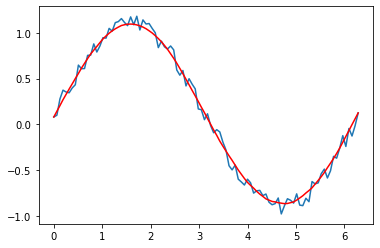

In [2]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
        if window_size % 2 != 1 or window_size < 1:
            raise TypeError("window_size size must be a positive odd number")
        if window_size < order + 2:
            raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
x = np.linspace(0,2*np.pi,100)
y = np.sin(x) + np.random.random(100) * 0.2
yhat = savitzky_golay(y, 51, 3) # window size 51, polynomial order 3

plt.plot(x,y)
plt.plot(x,yhat, color='red')
plt.show()

In [2]:


def get_for_learn_clean_df(statistic_df):
    feature = statistic_df.copy()
    del feature['datasetName']
    #feature = feature[feature["Facies"] >= -999]
    feature = feature[feature["MD"] * 10 % 2 < 0.001]
    feature = feature[feature["MD"] > 1850]
    return feature

def get_for_learn_clean_df_spk400(statistic_df):
    feature = statistic_df.copy()
    del feature['datasetName']
    #feature = feature[feature["Facies"] >= -999]
    feature = feature[feature["MD"] * 10 % 2 > 0.001]
    feature = feature[feature["MD"] > 1850]
    feature['wellName'] = 'spk400_shift'
    return feature

def get_well_dfs(all_well_df):
    wall_names_ = all_well_df['wellName'].unique()
    print(wall_names_)
    wells = []
    for name in wall_names_:
        well = all_well_df[all_well_df['wellName'] == name]
        wells.append(well)
    return wells

def get_for_learn_clean_df_spk427R(for_ml):
    def get_merge_df(one, two):
        one_copy =  one.copy()
        tho_copy = two.copy()
        new_df = pd.merge(one_copy, tho_copy,  how='inner', left_on=['wellName','MD'], right_on = ['wellName','MD'])
        return new_df

    for_ml_clone = for_ml.copy()
    for_ml_clone = for_ml_clone[for_ml_clone['wellName'] == 'spk427R']
    del for_ml_clone['BK']
    del for_ml_clone['SP']
    del for_ml_clone['NKTB']
    del for_ml_clone['LIT']
    del for_ml_clone['GR']
    del for_ml_clone['LAYER']

    spk427R = pd.read_csv('spk427R_TrainLogs.csv', sep=';')
    well = get_merge_df(for_ml_clone, spk427R)
    display(well.describe())
    del well['AGR']
    del well['ASP']
    del well['datasetName']
    return well

def get_well_dfs(all_well_df):
    wall_names_ = all_well_df['wellName'].unique()
    print(wall_names_)
    wells = []
    for name in wall_names_:
        well = all_well_df[all_well_df['wellName'] == name]
        wells.append(well)
    return wells

for_ml = get_for_learn_clean_df(pd.read_csv('DATATRAIN18+LAYER.csv', sep=';'))
spk427R = get_for_learn_clean_df_spk427R(for_ml)
spk400 = get_for_learn_clean_df_spk400(pd.read_csv('DATATRAIN18+LAYER.csv', sep=';'))
for_ml = for_ml[for_ml['wellName'] != 'spk427R']
for_ml = pd.concat([for_ml, spk400, spk427R])
display(for_ml.describe())
display(for_ml)
for_ml = for_ml.fillna(-9999)
wells_samples_df = get_well_dfs(for_ml)

MD       Facies         AGR         ASP          BK  \
count   310.000000   310.000000  310.000000  310.000000  310.000000   
mean   2586.900000 -2415.990323    0.443719    0.091886    9.137045   
std      17.926703  4290.816865    0.260089    0.094558    7.720558   
min    2556.000000 -9999.000000    0.000000    0.000000    5.345500   
25%    2571.450000     0.000000    0.214541    0.011352    7.181000   
50%    2586.900000     5.000000    0.417163    0.052764    7.973250   
75%    2602.350000     5.000000    0.643623    0.178180    8.979625   
max    2617.800000     8.000000    1.000000    0.317823  129.264500   

               GR         LIT        NKTB          SP  
count  310.000000  310.000000  310.000000  310.000000  
mean    10.891935    2.051613    3.933336  113.830968  
std      3.222438    1.422398    0.650787    4.948310  
min      5.300000    1.000000    3.033252  103.900000  
25%      9.000000    1.000000    3.550536  110.600000  
50%     10.900000    1.000000    3.795809  113.200000  
75%     12.600000    4.000000    4.129428  118.400000  
max     37.100000    5.000000    8.385099  123.600000

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



BK        Facies            GR           LIT            MD  \
count  65951.000000  69839.000000  69839.000000  69839.000000  69839.000000   
mean   -1579.525331  -9517.122396   -277.581893  -7693.602557   2297.936202   
std     3674.660162   2142.106428   1675.647925   4212.096414    265.521343   
min    -9999.000000  -9999.000000  -9999.000000  -9999.000000   1850.100000   
25%        4.383000  -9999.000000      7.949000  -9999.000000   2078.400000   
50%        6.770000  -9999.000000     10.080000  -9999.000000   2292.200000   
75%        9.380000  -9999.000000     12.600000  -9999.000000   2497.600000   
max    22739.520000     12.000000    142.370000      6.000000   3093.000000   

               NKTB            SP  
count  69839.000000  69839.000000  
mean    -275.478164      2.011366  
std     1647.951269   1028.578321  
min    -9999.000000  -9999.000000  
25%        3.250043     82.895565  
50%        3.750000    106.186100  
75%        4.200779    123.124450  
max       15.351170    578.255500

BK  Facies     GR  LAYER   LIT      MD      NKTB      SP wellName
0    4.420000   -9999  13.60  -9999 -9999  2011.0  2.968678   97.41  spk1521
1    4.300000   -9999  13.51  -9999 -9999  2011.2  2.937724   97.02  spk1521
2    4.310000   -9999  13.17  -9999 -9999  2011.4  2.973814   97.57  spk1521
3    4.280000   -9999  13.03  -9999 -9999  2011.6  2.989185   97.86  spk1521
4    4.260000   -9999  12.94  -9999 -9999  2011.8  2.968678   98.15  spk1521
..        ...     ...    ...    ...   ...     ...       ...     ...      ...
305  8.691000   -9999  12.60     U1     1  2617.0  3.698164  109.90  spk427R
306  8.563000   -9999  12.90     U1     1  2617.2  3.535424  110.70  spk427R
307  8.091500   -9999  13.70     U1     1  2617.4  3.577271  110.80  spk427R
308  8.374000   -9999  13.30     U1     1  2617.6  3.772560  110.60  spk427R
309  8.577499   -9999  13.50     U1     1  2617.8  3.647017  110.90  spk427R

[69839 rows x 9 columns]

['spk1521' 'spk1527' 'spk1769' 'spk400' 'spk402' 'spk403' 'spk405R'
 'spk406R' 'spk409R' 'spk420R' 'spk424R' 'spk426R' 'spk428R' 'spk429L'
 'spk432R' 'spk967' 'spk400_shift' 'spk427R']


In [5]:
for_ml[for_ml['Facies'] == 7]['wellName'].unique()

array(['spk1521', 'spk1527', 'spk400', 'spk424R', 'spk428R', 'spk429L',
       'spk432R', 'spk400_shift'], dtype=object)

In [7]:
spk428R = for_ml[for_ml['wellName'] == 'spk428R']

In [8]:
spk428R[spk428R['Facies'] == 7]

BK  Facies     GR LAYER  LIT      MD   NKTB        SP wellName
101221  11.42       7  12.21    U1    1  2598.0  4.043  155.3298  spk428R
101222  10.24       7  11.43    U1    1  2598.2  4.127  152.0694  spk428R
101223   9.27       7  10.62    U1    2  2598.4  4.134  148.6590  spk428R
101224   8.69       7  10.05    U1    2  2598.6  4.498  148.5785  spk428R
101225   8.62       7  10.47    U1    2  2598.8  4.603  151.6681  spk428R
...       ...     ...    ...   ...  ...     ...    ...       ...      ...
101290  16.57       7   7.56    U1    5  2611.8  5.583  150.5895  spk428R
101291  14.96       7   7.54    U1    5  2612.0  5.863  152.2490  spk428R
101292  23.56       7   7.67    U1    5  2612.2  5.800  151.7386  spk428R
101293  17.93       7   7.78    U1    5  2612.4  6.052  150.7582  spk428R
101294   9.38       7   8.06    U1    5  2612.6  6.143  149.4677  spk428R

[74 rows x 9 columns]

In [9]:
spk432R = for_ml[for_ml['wellName'] == 'spk432R']
spk432R[spk432R['Facies'] == 7]

BK  Facies      GR  LAYER  LIT      MD      NKTB        SP wellName
124727  7.997       7  12.734  UV1_2    1  2616.0  3.722444  193.4894  spk432R
124728  6.508       7  11.851  UV1_2    1  2616.2  3.647094  190.2336  spk432R
124729  6.203       7  10.376  UV1_2    2  2616.4  4.095605  184.3508  spk432R
124730  6.501       7   9.568  UV1_2    2  2616.6  4.576408  181.5879  spk432R
124731  6.928       7  10.585  UV1_2    2  2616.8  4.590163  180.3001  spk432R
...       ...     ...     ...    ...  ...     ...       ...       ...      ...
124815  5.914       7  11.686  UV1_2    1  2633.6  3.921583  187.6145  spk432R
124816  6.864       7  12.223  UV1_2    1  2633.8  4.418533  187.8437  spk432R
124817  6.950       7  13.268  UV1_2    1  2634.0  4.754019  192.4768  spk432R
124818  6.773       7  13.701  UV1_2    1  2634.2  4.581193  192.6070  spk432R
124819  7.369       7  13.306  UV1_2    1  2634.4  4.483716  191.7632  spk432R

[93 rows x 9 columns]

In [8]:
%load_ext autoreload
from feature_interval_extraction import get_interval_collector


def get_df_interval_result(well, intervals):
    dfs_parts = []
    for interval in intervals:
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            df_part_min = well[well['MD'] >= min_]
            df_part = df_part_min[df_part_min['MD'] <= max_]
        else:
            df_part_min = well[well['MD'] <= min_]
            df_part = df_part_min[df_part_min['MD'] >= max_]
        dfs_parts.append(df_part)
    all = pd.concat(dfs_parts)
    return all.drop_duplicates()


def get_df_intervals_result(well, intervals):
    dfs_parts = []
    for interval in intervals:
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            df_part_min = well[well['MD'] >= min_]
            df_part = df_part_min[df_part_min['MD'] <= max_]
        else:
            df_part_min = well[well['MD'] <= min_]
            df_part = df_part_min[df_part_min['MD'] >= max_]
        dfs_parts.append(df_part)
    return dfs_parts


def get_df_middle_intervals_result(well, intervals):
    def get_left_md(interval):
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            return min_
        else:
            return max_

    def get_right_md(interval):
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            return max_
        else:
            return min_

    if len(intervals) == 0:
        return 0
    well_copy = well.copy()
    if len(intervals) == 1:
        left = get_left_md(intervals[0])
        right = get_right_md(intervals[0])
        left_df = well_copy[well_copy['MD'] < left]
        right_df = well_copy[well_copy['MD'] > right]
        return [left_df, right_df]

    middle_interval_dfs = []
    for index, interval in enumerate(intervals):
        if index == 0:
            left = get_left_md(intervals[index])
            left_df = well_copy[well_copy['MD'] < left]
            middle_interval_dfs.append(left_df)
            continue
        if index == len(intervals) - 1:
            right = get_right_md(intervals[index])
            right_df = well_copy[well_copy['MD'] > right]
            middle_interval_dfs.append(right_df)
            continue
        right_current = get_right_md(intervals[index])
        left_next = get_left_md(intervals[index + 1])
        df_part_right = well_copy[well_copy['MD'] > right_current]
        df_part = df_part_right[df_part_right['MD'] < left_next]
        if not df_part.empty:
            middle_interval_dfs.append(df_part)
    return middle_interval_dfs


def add_statistic_for_interval(middle_interval_dfs, feature_names, new_feature_prefix):
    results = []
    for interval_df_ in middle_interval_dfs:
        part = interval_df_.copy()
        part['interval_lenght_' + new_feature_prefix] = interval_df_[feature_names[0]].count()
        for name in feature_names:
            part['max_' + new_feature_prefix + name] = part[name].max()
            part['min_' + new_feature_prefix + name] = part[name].min()
#             if part[name].max() == part[name].min():
#                 part['std_' + new_feature_prefix + name] = 0
#             else:
#                 part['std_' + new_feature_prefix + name] = part[name].std()
#             part['mean_' + new_feature_prefix + name] = part[name].mean()
        results.append(part)
    return pd.concat(results)

def min_shift_corrector(middle_interval_dfs, shift_corrector):
    results = []
    for interval_df_ in middle_interval_dfs:
        part = interval_df_.copy()
        for name in feature_names:
            ppart[name] = part[name] - abs(shift_corrector)
        results.append(part)
    return pd.concat(results)


def get_with_interval_feature_extraction(well, features_name_for_extraction,
                                         percent_change_border, new_feature_prefix, features_name_for_statistic):
    intervals = get_interval_collector(well, features_name_for_extraction, percent_change_border)
    interval_df = get_df_intervals_result(well, intervals)
    middle_interval_df = get_df_middle_intervals_result(well, intervals)
    with_statistic_middle = add_statistic_for_interval(middle_interval_df, features_name_for_statistic,
                                                       new_feature_prefix)
    with_statistic_intervals = add_statistic_for_interval(interval_df, features_name_for_statistic, new_feature_prefix)
    concat_df = pd.concat([with_statistic_middle, with_statistic_intervals])
    remove_duplicates = concat_df.drop_duplicates(subset='MD', keep="last")
    return remove_duplicates.sort_index()


def add_interval_column(middle_interval_dfs, new_column_name, feature_sp_gr):
    results = []
    for interval_df_ in middle_interval_dfs:
        part = interval_df_.copy()
        part['max_' + new_column_name] = part[feature_sp_gr].max()
        part['min_' + new_column_name] = part[feature_sp_gr].min()
        results.append(part)
    return pd.concat(results)


def add_interval_column_nulls(middle_interval_dfs, new_column_name):
    results = []
    for interval_df_ in middle_interval_dfs:
        part = interval_df_.copy()
        part['max_' + new_column_name] = -9999
        part['min_' + new_column_name] = -9999
        results.append(part)
    return pd.concat(results)


def get_column_with_interval(well, features_name_for_extraction,
                             percent_change_border, new_column_name, feature_sp_or_gr):
    intervals = get_interval_collector(well, features_name_for_extraction, percent_change_border)
    interval_df = get_df_intervals_result(well, intervals)
    middle_interval_df = get_df_middle_intervals_result(well, intervals)
    with_statistic_middle = add_interval_column_nulls(middle_interval_df, new_column_name)
    with_statistic_intervals = add_interval_column(interval_df, new_column_name, feature_sp_or_gr)
    concat_df = pd.concat([with_statistic_middle, with_statistic_intervals])
    remove_duplicates = concat_df.drop_duplicates(subset='MD', keep="last")
    return remove_duplicates.sort_index()


def get_well_with_features_df_intervals(wells, feature_names, percents_borders):
    wells_return = []
    wells_nulls = []
    index_well = 0
    for well in wells:
        well_copy = well.copy()

        name_feature_extraction = feature_names[0] + '_savitzky_golay'
        print(feature_names[0] + '_' + str(index_well))
        well_copy[name_feature_extraction] = savitzky_golay(well_copy[feature_names[0]].values, 4, 1, 1)
        index_well = index_well + 1
        #min_ = well_copy[name_feature_extraction].min()
        #well_copy[name_feature_extraction] = well_copy[name_feature_extraction].apply(lambda x: x + abs(min_))
        for border in percents_borders:
            new_feature_prefix = feature_names[0] + 'interval_' + str(border) + '_'
            well_copy = get_with_interval_feature_extraction(well=well_copy,
                                                             features_name_for_extraction=name_feature_extraction,
                                                             percent_change_border=border,
                                                             new_feature_prefix=new_feature_prefix,
                                                             features_name_for_statistic=feature_names)
            #well_copy[name_feature_extraction] = well_copy[name_feature_extraction].apply(lambda x: x - abs(min_))
#         upper, middle, lower = talib.BBANDS(well_copy['SP'].apply(change_null),
#                         timeperiod=2,
#                         nbdevup=2,
#                         nbdevdn=2,
#                         matype=talib.MA_Type.EMA)
#         well_copy['SP_upper'] = upper
#         well_copy['SP_middle'] = middle
#         well_copy['SP_lower'] = lower
        
#         upper, middle, lower = talib.BBANDS(well_copy['GR'].apply(change_null),
#                         timeperiod=2,
#                         nbdevup=2,
#                         nbdevdn=2,
#                         matype=talib.MA_Type.EMA)
#         well_copy['GR_upper'] = upper
#         well_copy['GR_middle'] = middle
#         well_copy['GR_lower'] = lower
        del well_copy[name_feature_extraction]
        well_copy.fillna(-9999)
        wells_return.append(well_copy)

    print(len(wells_nulls))
    return wells_return


well_with_features = get_well_with_features_df_intervals(wells_samples_df, ['SP'], [0.2])
#well_with_features = get_well_with_features_df(well_with_features, ['GR'], [0.20])


SP_0


KeyboardInterrupt: 

In [199]:
well_with_features[0]

BK  Facies     GR  LAYER   LIT      MD      NKTB      SP wellName  \
0     4.42   -9999  13.60  -9999 -9999  2011.0  2.968678   97.41  spk1521   
1     4.30   -9999  13.51  -9999 -9999  2011.2  2.937724   97.02  spk1521   
2     4.31   -9999  13.17  -9999 -9999  2011.4  2.973814   97.57  spk1521   
5     4.41   -9999  12.64  -9999 -9999  2012.0  3.024832   97.77  spk1521   
6     4.50   -9999  12.61  -9999 -9999  2012.2  3.055148   97.45  spk1521   
...    ...     ...    ...    ...   ...     ...       ...     ...      ...   
5406  7.85   -9999  18.86  UV1_3 -9999  3092.2  3.586331  131.68  spk1521   
5407  7.84   -9999  18.64  UV1_3 -9999  3092.4  3.550309  132.38  spk1521   
5408  7.85   -9999  18.49  UV1_3 -9999  3092.6  3.495778  132.12  spk1521   
5409  7.84   -9999  18.49  UV1_3 -9999  3092.8  3.675269  131.83  spk1521   
5410  7.84   -9999  18.49  UV1_3 -9999  3093.0  3.675269  131.83  spk1521   

      SP_savitzky_golay  interval_lenght  max_SPinterval_0.2_SP  \
0         -2.131628e-14                3                  97.57   
1          8.000000e-02                3                  97.57   
2          4.200000e-01                3                  97.57   
5         -3.500000e-01                5                 100.31   
6          4.300000e-01                5                 100.31   
...                 ...              ...                    ...   
5406       4.250000e-01                3                 132.38   
5407       2.200000e-01                3                 132.38   
5408      -2.750000e-01                3                 132.38   
5409      -1.450000e-01                2                 131.83   
5410      -1.421085e-14                2                 131.83   

      min_SPinterval_0.2_SP    SP_upper   SP_middle    SP_lower   GR_upper  \
0                     97.02         NaN         NaN         NaN        NaN   
1                     97.02   97.605000   97.215000   96.825000  13.645000   
2                     97.02   98.001667   97.451667   96.901667  13.638333   
5                     97.45   97.863889   97.663889   97.463889  13.389444   
6                     97.45   97.841296   97.521296   97.201296  12.723148   
...                     ...         ...         ...         ...        ...   
5406                 131.68  131.725386  131.575386  131.425386  19.122521   
5407                 131.68  132.811795  132.111795  131.411795  18.947507   
5408                 131.68  132.377265  132.117265  131.857265  18.719169   
5409                 131.83  132.215755  131.925755  131.635755  18.516394   
5410                 131.83  131.861918  131.861918  131.861918  18.498801   

      GR_middle   GR_lower  
0           NaN        NaN  
1     13.555000  13.465000  
2     13.298333  12.958333  
5     12.859444  12.329444  
6     12.693148  12.663148  
...         ...        ...  
5406  18.902521  18.682521  
5407  18.727507  18.507507  
5408  18.569169  18.419169  
5409  18.516390  18.516385  
5410  18.498797  18.498792  

[5409 rows x 19 columns]

['spk1521' 'spk1527' 'spk400' 'spk424R' 'spk428R' 'spk429L' 'spk432R'
 'spk400_shift']
['spk1521']
['spk1527']
['spk400']
['spk424R']
['spk428R']
['spk429L']
['spk432R']
['spk400_shift']


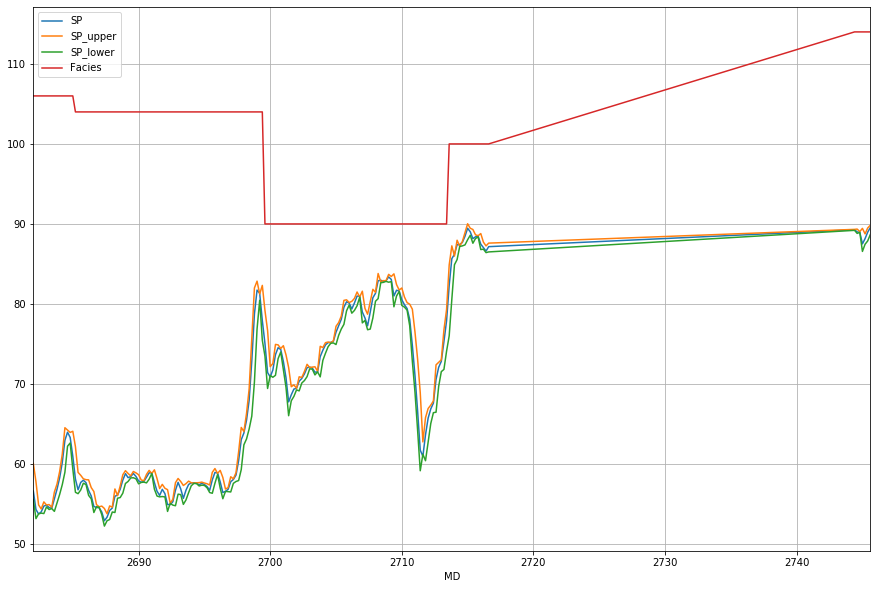

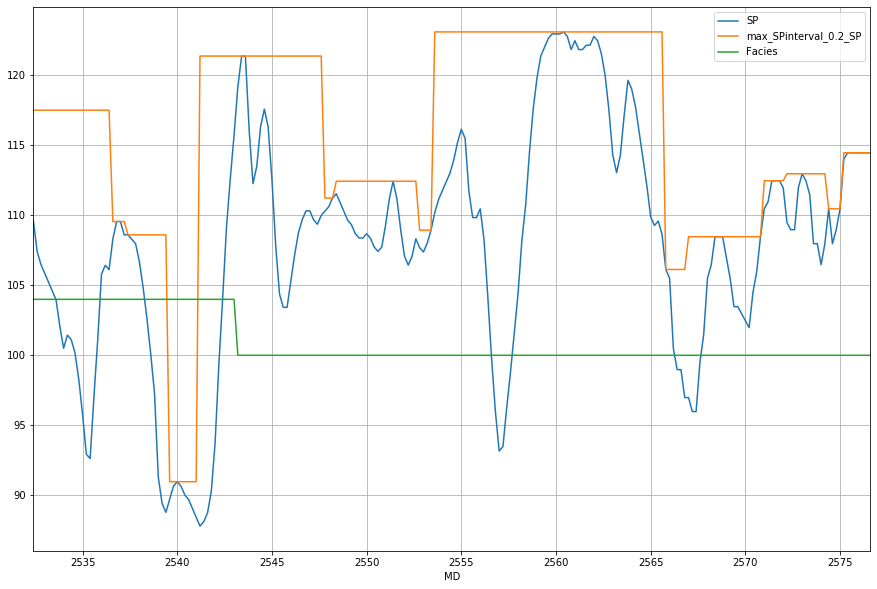

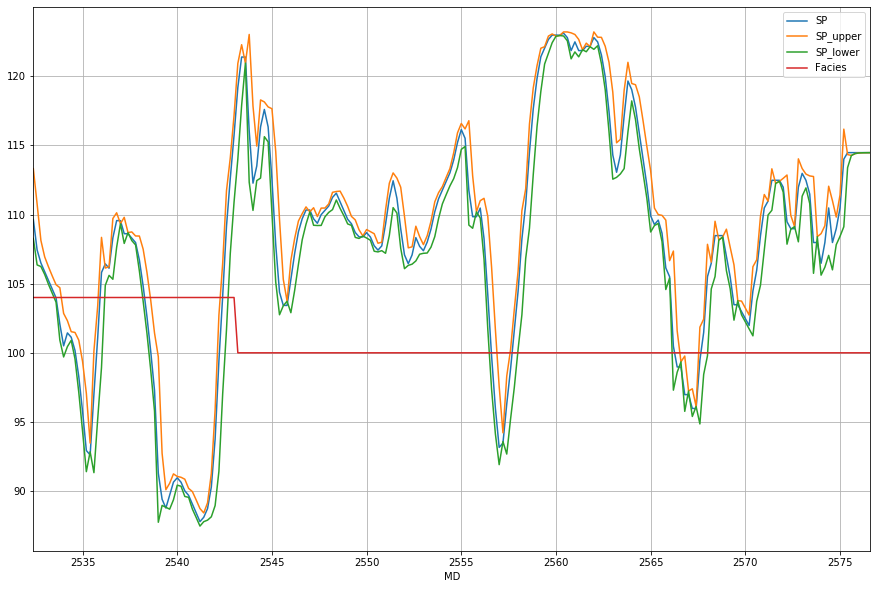

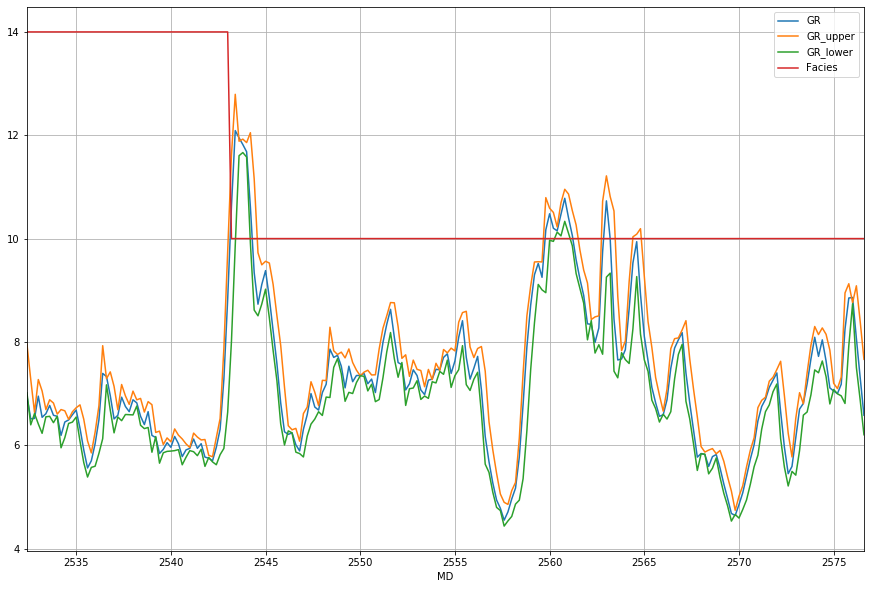

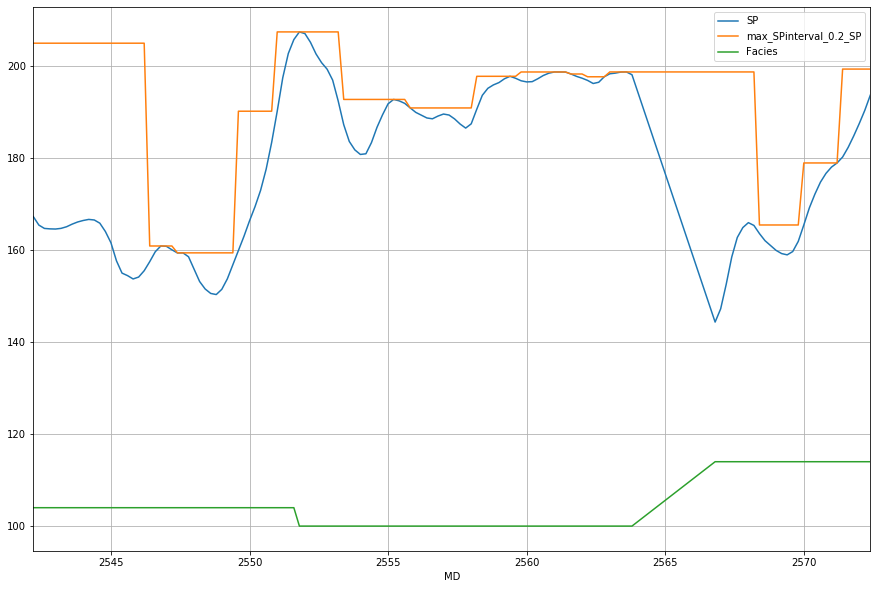

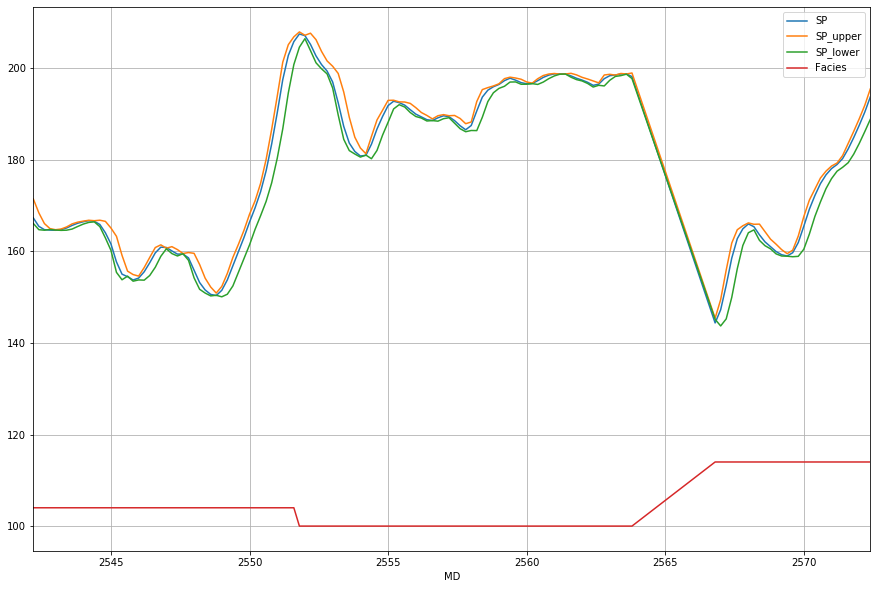

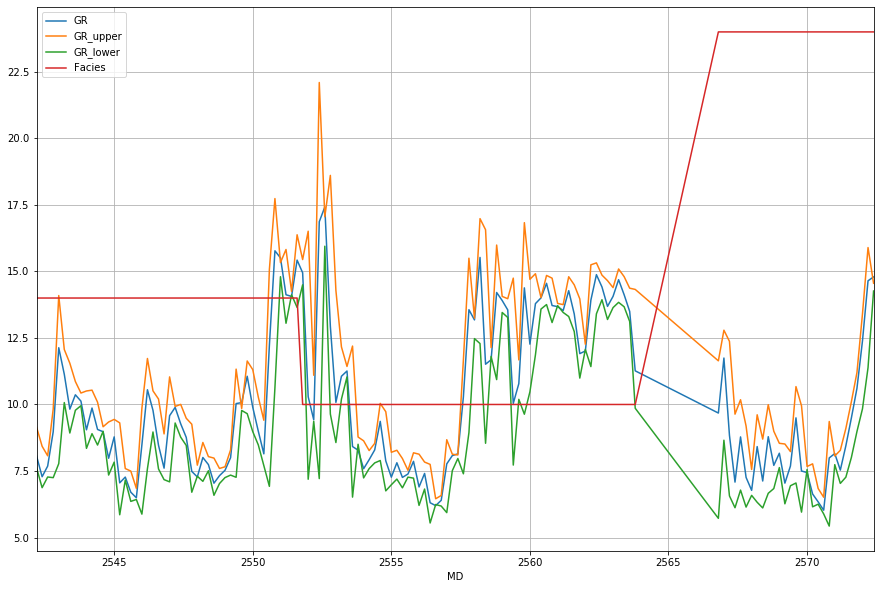

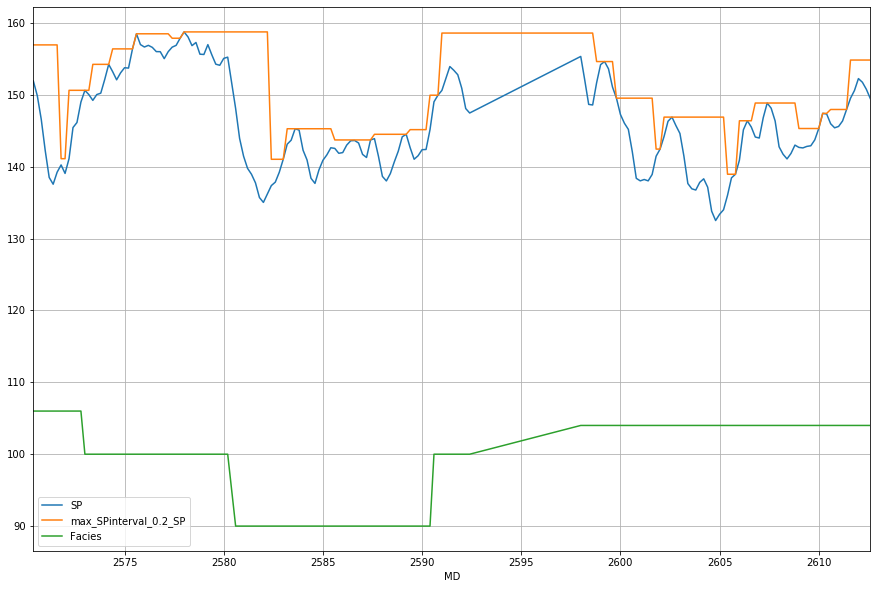

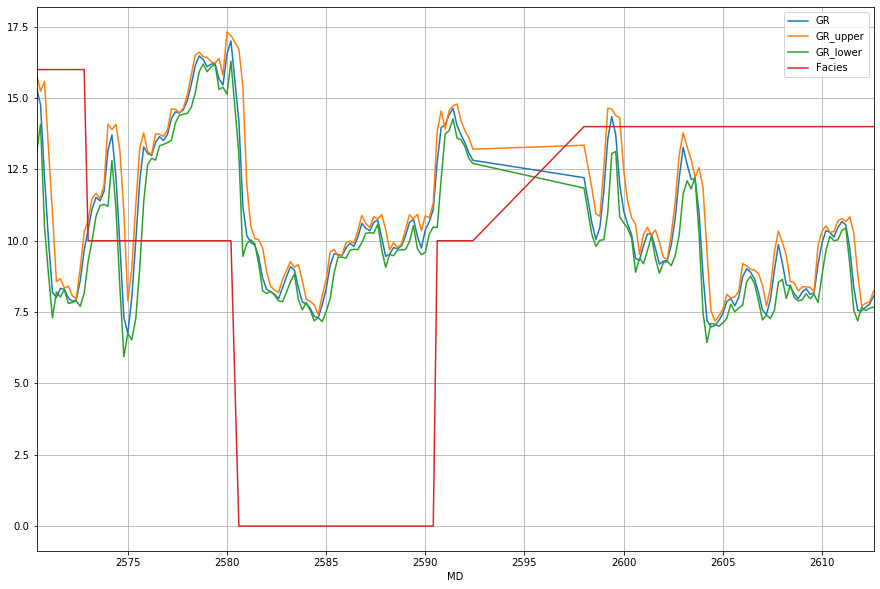

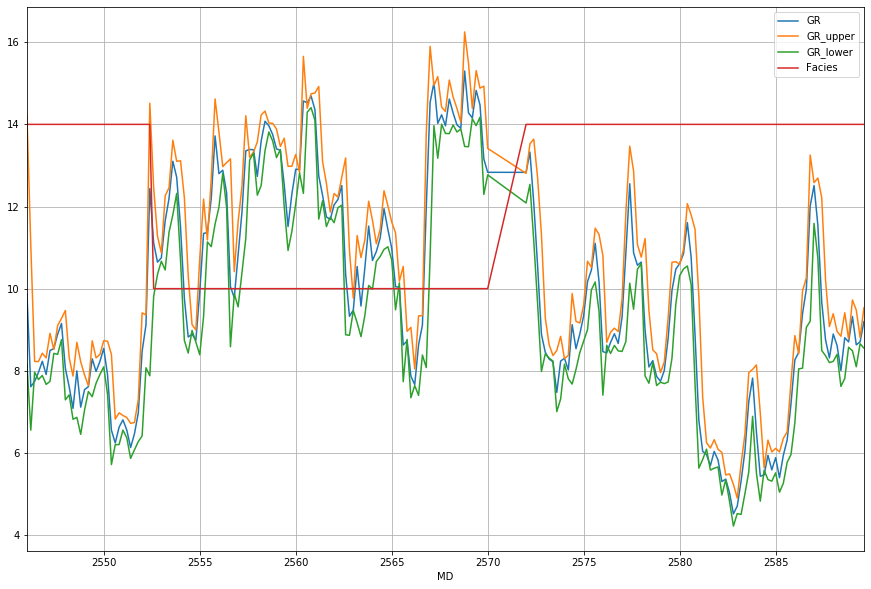

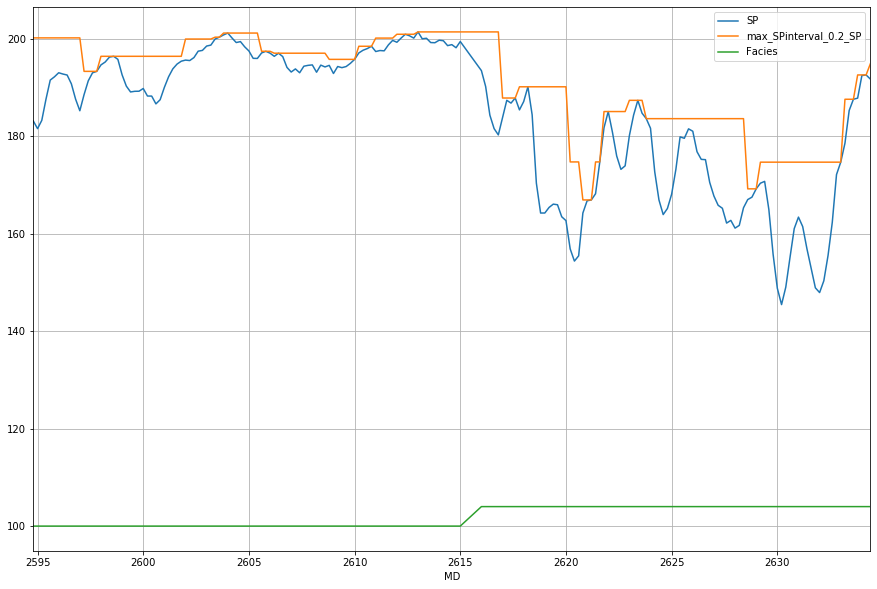

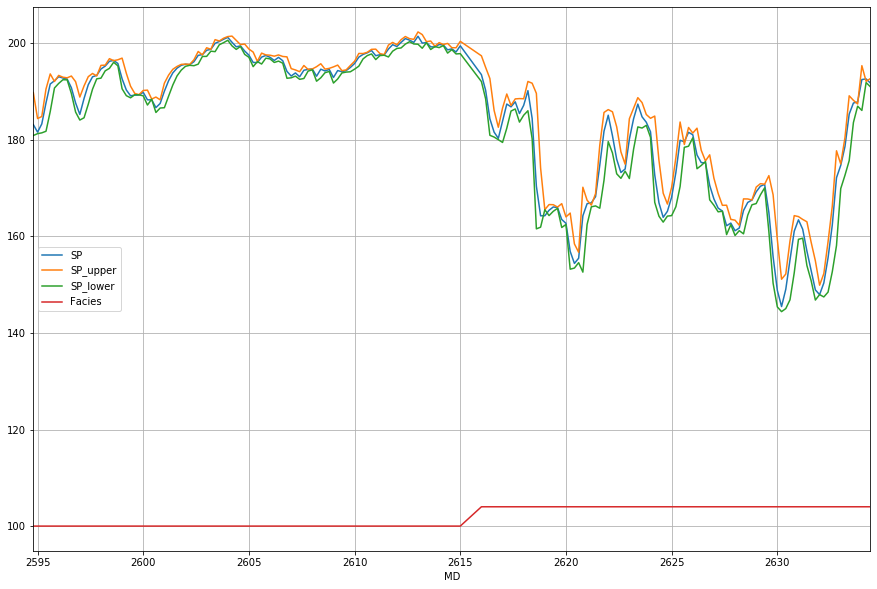

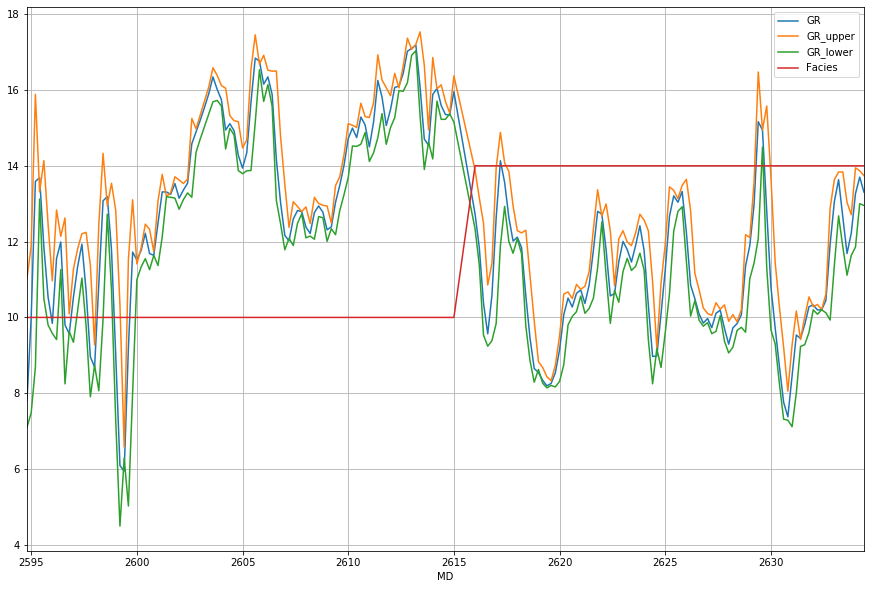

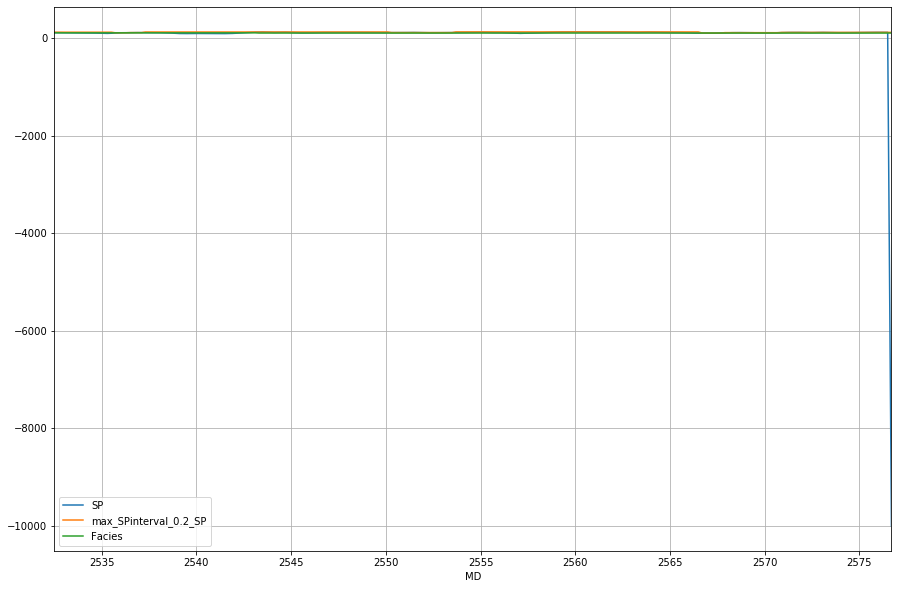

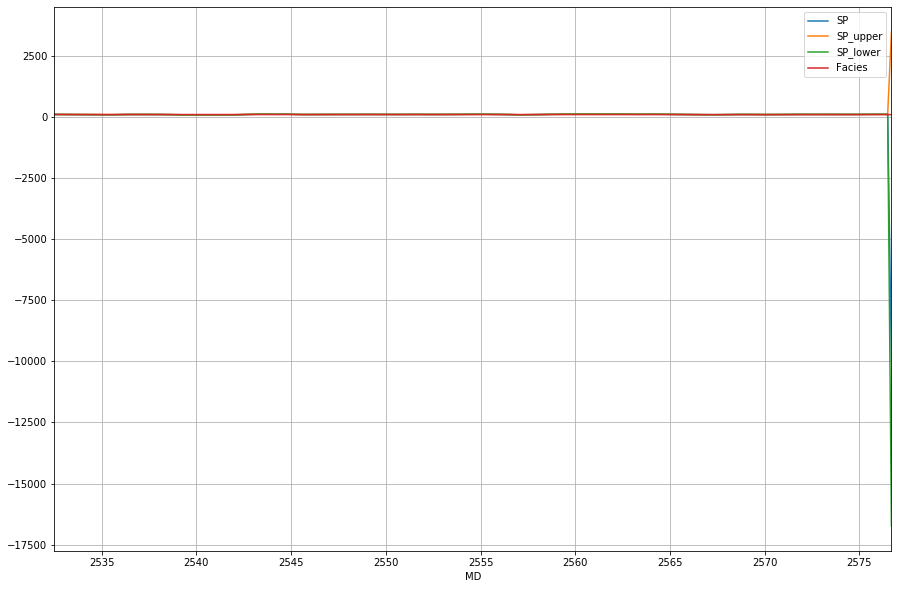

In [200]:
def vive_all(well_with_features):
#     def change_facies_for_plot(x)L

    
    wells_copy = well_with_features.copy()
    for well in wells_copy:
        first = well.copy()
        print(first['wellName'].unique())
        first['Facies'] = first['Facies']*2 + 90
        diference_border = -9

        first[first['Facies'] > diference_border].plot(x='MD', y=[ 
                                                                  'SP', 'max_SPinterval_0.2_SP',"Facies"], figsize=(15, 10), grid=True)
        
        first[first['Facies'] > diference_border].plot(x='MD', y=['SP', 
                                                                  'SP_upper', 'SP_lower', "Facies"], figsize=(15, 10), grid=True)

        first['Facies'] = first['Facies'] - 90
        first[first['Facies'] > diference_border].plot(x='MD', y=['GR', 
                                                                  'GR_upper', 'GR_lower', "Facies"], figsize=(15, 10), grid=True)
vive_all(get_well_with_7(pd.concat(well_with_features)))

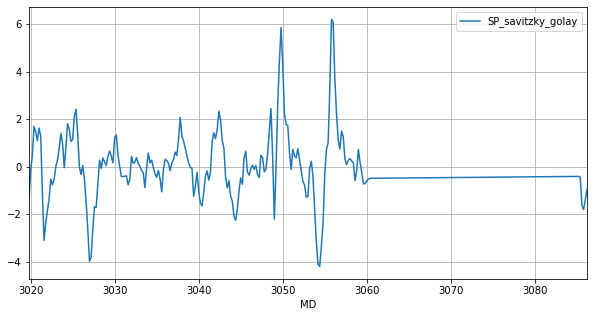

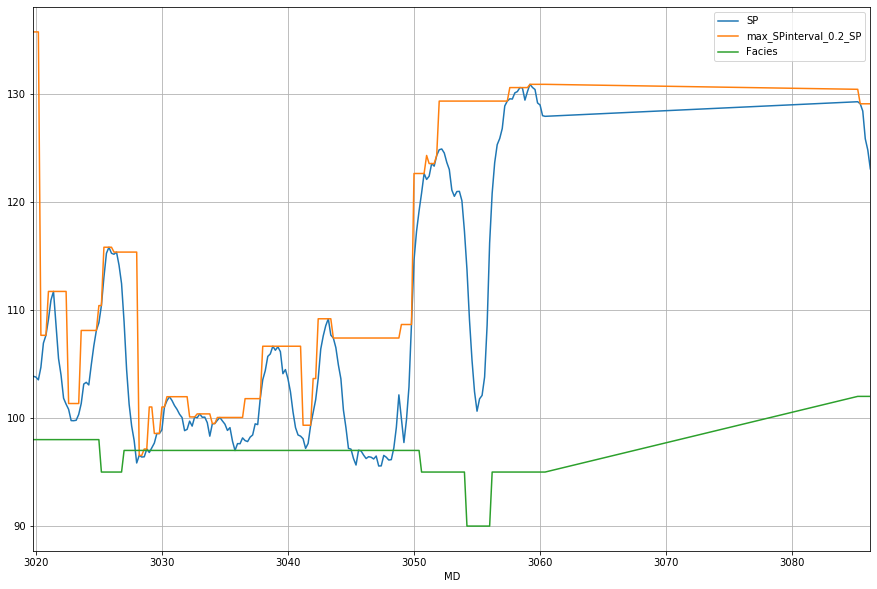

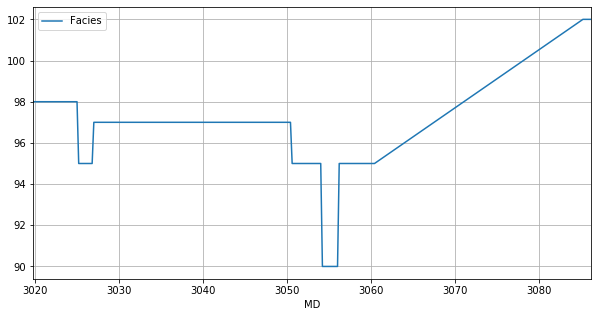

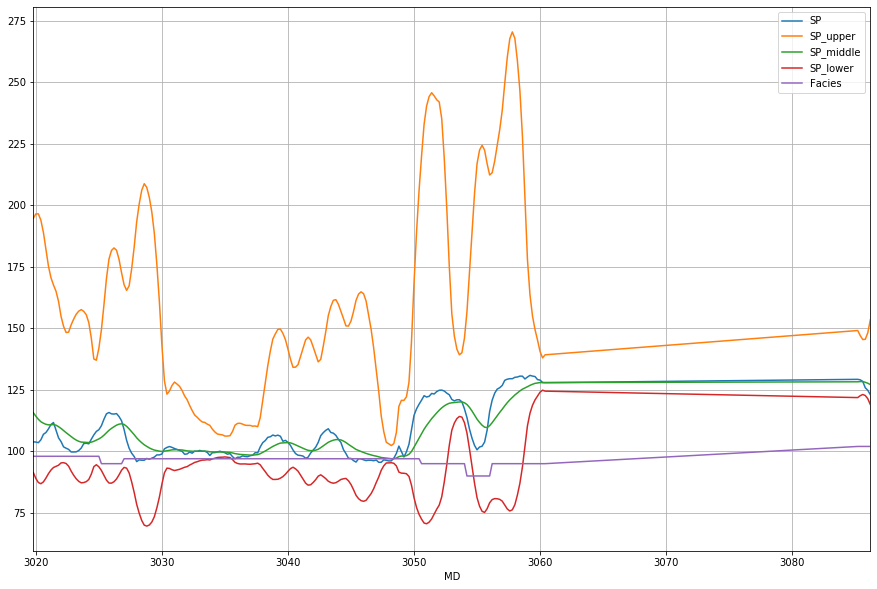

In [182]:
first = well_with_features[0].copy()
first['Facies'] = first['Facies'] + 90
diference_border = -9
#first[first['Facies'] > diference_border].plot(x='MD', y="SP", figsize=(10, 5), grid=True)
#first[first['Facies'] > diference_border].plot(x='MD', y="SP_savitzky_golay", figsize=(10, 5), grid=True)
first[first['Facies'] > diference_border].plot(x='MD', y=[ 
                                                          'SP', 'max_SPinterval_0.2_SP',"Facies"], figsize=(15, 10), grid=True)
first[first['Facies'] > diference_border].plot(x='MD', y="Facies", figsize=(10, 5), grid=True)
#first[first['Facies'] > diference_border].plot(x='MD', y=['min_GRinterval_0.2_GR', 
#                                                          'GR', 'max_GRinterval_0.2_GR'], figsize=(10, 5), grid=True)
first[first['Facies'] > diference_border].plot(x='MD', y=['SP', 
                                                          'SP_upper', 'SP_middle', 'SP_lower', "Facies"], figsize=(15, 10), grid=True)
#first[first['Facies'] > diference_border].plot(x='MD', y="GR", figsize=(10, 5), grid=True)
#first[first['Facies'] > diference_border].plot(x='MD', y="max_GRinterval_0.1_GR", figsize=(10, 5), grid=True)

In [142]:
import matplotlib.pyplot as plt
%matplotlib inline
def get_well_with_7(all_well_df):
    wall_names_ = all_well_df[all_well_df['Facies'] == 7]['wellName'].unique()
    print(wall_names_)
    wells = []
    for name in wall_names_:
        well = all_well_df[all_well_df['wellName'] == name]
        wells.append(well)
    return wells

def filter_middle_7(wells, period):
    results = []
    wells_copy = wells.copy()
    for well in wells_copy:
        well['shift_up'] = well["Facies"].shift(period)
        well['shift_dw'] = well["Facies"].shift(-period)
        well['is_middle'] = well['shift_up'] * well['shift_dw']
        well = well.fillna(0)
        display(well[well['is_middle'] == 49].describe())
        well = well[well['is_middle'] != 49]
        del well['shift_up']
        del well['shift_dw']
        del well['is_middle']
        results.append(well)
    return results
        
def well_with_7(wells):
    wells_copy = wells.copy()

    for well in wells_copy:
        #well = well[well["Facies"] == 7]
        #well = well[well["Facies"] < 13]
        display(well.describe())
        well_name = well['wellName'].unique()
        
        well.plot(x='MD', y=['Facies'], figsize=(15,8), grid=True)
        plt.xlabel('MD')
        plt.ylabel('Facies')
        plt.title(well_name + ' Facies')

        plt.title("Гистограмма Facies")
        #well['Facies'].hist(figsize=(15,8), x=well['MD'])
        plt.show()
        
    return wells


#wells_with_7 = get_well_with_7(pd.concat(well_with_features))
#wells_with_7_filered = filter_middle_7(wells_with_7, 15)
well_with_7(pd.concat(well_with_features))

AttributeError: 'str' object has no attribute 'describe'

In [202]:
def get_well_with_distance_features(well):
    def add_feature_last(well_in, shift_last, name):
        well_in[name + '_last_' + str(shift_last / 5)] = well_in[name].shift(periods=-shift_last)

    def add_feature_next(well_in, shift_next, name):
        well_in[name + '_next_' + str(shift_next / 5)] = well_in[name].shift(periods=+shift_next)

    distance_meter = [3, 6, 9, 12, 15]
    distance_shift = [meter * 5 for meter in distance_meter]
    well_copy = well.copy()

    for shift in distance_shift:
        add_feature_last(well_copy, shift, 'GR')
        add_feature_last(well_copy, shift, 'SP')
        add_feature_last(well_copy, shift, 'BK')
        add_feature_last(well_copy, shift, 'NKTB')

        add_feature_next(well_copy, shift, 'GR')
        add_feature_next(well_copy, shift, 'SP')
        add_feature_next(well_copy, shift, 'BK')
        add_feature_next(well_copy, shift, 'NKTB')

    return well_copy

def get_well_with_features_df(wells):
    def change_null(x):
        undefined_value = -9999
        if x == 'NaN':
            return undefined_value
        if math.isnan(x):
            return undefined_value
        if math.isinf(x):
            return undefined_value
        return x
    
    
    not_change_null = ['wellName', 'Facies', 'MD', 'LIT']
    wells_return = []
    import math
    for well in wells:
        print(well.head())
        well_copy = well.copy()  
        
        well_copy = get_well_with_distance_features(well_copy)

        wells_return.append(well_copy)
    return wells_return

def change_null(x):
        undefined_value = -9999
        if x == 'NaN':
            return undefined_value
        if math.isnan(x):
            return undefined_value
        if math.isinf(x):
            return undefined_value
        return x

 

def get_well_with_features_df1(wells):
    def change_null(x):
        undefined_value = -9999
        if x == 'NaN':
            return undefined_value
        if math.isnan(x):
            return undefined_value
        if math.isinf(x):
            return undefined_value
        return x
    
    
    not_change_null = ['wellName', 'Facies', 'MD', 'LIT', 'LAYER']
    wells_return = []
    import math
    for well in wells:
        print(well.head())
        well_copy = well.copy()  
        from talib import MA_Type

            
        for feature_name in well_copy.columns:
            if feature_name not in not_change_null:
                well_copy[feature_name] = well_copy[feature_name].apply(change_null)
            
        wells_return.append(well_copy)
    return wells_return

#well_with_features = get_well_with_features_df1(wells_samples_df)

# wells_with_7_filered = filter_middle_7(well_with_features, 10)
# for_ml_preprocessing = pd.concat(wells_with_7_filered)


for_ml_preprocessing = pd.concat(well_with_features)
display(for_ml_preprocessing)

BK  Facies     GR  LAYER   LIT      MD      NKTB      SP wellName  \
0    4.420000   -9999  13.60  -9999 -9999  2011.0  2.968678   97.41  spk1521   
1    4.300000   -9999  13.51  -9999 -9999  2011.2  2.937724   97.02  spk1521   
2    4.310000   -9999  13.17  -9999 -9999  2011.4  2.973814   97.57  spk1521   
5    4.410000   -9999  12.64  -9999 -9999  2012.0  3.024832   97.77  spk1521   
6    4.500000   -9999  12.61  -9999 -9999  2012.2  3.055148   97.45  spk1521   
..        ...     ...    ...    ...   ...     ...       ...     ...      ...   
305  8.691000   -9999  12.60     U1     1  2617.0  3.698164  109.90  spk427R   
306  8.563000   -9999  12.90     U1     1  2617.2  3.535424  110.70  spk427R   
307  8.091500   -9999  13.70     U1     1  2617.4  3.577271  110.80  spk427R   
308  8.374000   -9999  13.30     U1     1  2617.6  3.772560  110.60  spk427R   
309  8.577499   -9999  13.50     U1     1  2617.8  3.647017  110.90  spk427R   

     SP_savitzky_golay  interval_lenght  max_SPinterval_0.2_SP  \
0        -2.131628e-14                3                  97.57   
1         8.000000e-02                3                  97.57   
2         4.200000e-01                3                  97.57   
5        -3.500000e-01                5                 100.31   
6         4.300000e-01                5                 100.31   
..                 ...              ...                    ...   
305       2.000000e-01               13                 113.20   
306       4.500000e-01               13                 113.20   
307      -5.000000e-02                3                 110.90   
308       5.000000e-02                3                 110.90   
309       3.000000e-01                3                 110.90   

     min_SPinterval_0.2_SP    SP_upper   SP_middle    SP_lower   GR_upper  \
0                    97.02         NaN         NaN         NaN        NaN   
1                    97.02   97.605000   97.215000   96.825000  13.645000   
2                    97.02   98.001667   97.451667   96.901667  13.638333   
5                    97.45   97.863889   97.663889   97.463889  13.389444   
6                    97.45   97.841296   97.521296   97.201296  12.723148   
..                     ...         ...         ...         ...        ...   
305                 109.90  110.540027  110.140027  109.740027  12.773485   
306                 109.90  111.313342  110.513342  109.713342  13.124495   
307                 110.60  110.804447  110.704447  110.604447  14.208165   
308                 110.60  110.834816  110.634816  110.434816  13.736055   
309                 110.60  111.111605  110.811605  110.511605  13.645352   

     GR_middle   GR_lower  
0          NaN        NaN  
1    13.555000  13.465000  
2    13.298333  12.958333  
5    12.859444  12.329444  
6    12.693148  12.663148  
..         ...        ...  
305  12.673485  12.573485  
306  12.824495  12.524495  
307  13.408165  12.608165  
308  13.336055  12.936055  
309  13.445352  13.245352  

[69714 rows x 19 columns]

In [144]:
def change_facies(x):
    undefined_value = -9999
    if x == 7:
        return x
    if x > -1:
        return 3
    return x
for_ml_preprocessing['Facies'] = for_ml_preprocessing['Facies'].apply(change_facies)

In [203]:
for_ml_preprocessing.describe()

BK        Facies            GR           LIT            MD  \
count  65826.000000  69714.000000  69714.000000  69714.000000  69714.000000   
mean   -1570.225521  -9517.980721   -278.095976  -7691.333950   2298.593554   
std     3666.029284   2140.293532   1677.105503   4213.547073    265.146491   
min    -9999.000000  -9999.000000  -9999.000000  -9999.000000   1850.100000   
25%        4.400000  -9999.000000      7.950000  -9999.000000   2079.400000   
50%        6.780000  -9999.000000     10.080000  -9999.000000   2292.800000   
75%        9.390000  -9999.000000     12.600000  -9999.000000   2497.800000   
max    22739.520000     12.000000    142.370000      6.000000   3093.000000   

               NKTB            SP  SP_savitzky_golay  interval_lenght  \
count  69714.000000  69714.000000       69714.000000     69714.000000   
mean    -275.978521      1.802277          -1.736948        21.459377   
std     1649.385647   1029.487258         101.764953        22.645746   
min    -9999.000000  -9999.000000       -5288.627750         1.000000   
25%        3.250085     82.879025          -0.633700         7.000000   
50%        3.750000    106.177550          -0.002100        14.000000   
75%        4.201210    123.118400           0.632312        29.000000   
max       15.351170    578.255500        5089.099350       233.000000   

       max_SPinterval_0.2_SP  min_SPinterval_0.2_SP      SP_upper  \
count           69714.000000           69714.000000  69696.000000   
mean               83.378673             -27.864694      6.504228   
std               585.127286            1122.221985   1018.505437   
min             -9999.000000           -9999.000000  -9999.000000   
25%                97.022087              69.948070     84.724299   
50%               113.295200              97.675080    107.278446   
75%               129.323900             117.770000    123.988273   
max               578.255500             209.243700   6964.664500   

          SP_middle      SP_lower      GR_upper     GR_middle      GR_lower  
count  69696.000000  69696.000000  69696.000000  69696.000000  69696.000000  
mean       2.790233     -0.923762   -274.937572   -277.293840   -279.650108  
std     1020.930349   1043.383152   1671.455387   1672.912144   1685.488748  
min    -9999.000000 -17050.504262  -9999.000000  -9999.000000 -16675.596165  
25%       83.007909     80.316165      8.355462      7.978704      7.547971  
50%      106.087622    104.893185     10.494263     10.083960      9.638661  
75%      123.102936    122.420390     13.204252     12.590758     12.047449  
max      578.253714    578.253692   3354.203835    140.367331    137.935777

In [204]:
for_ml_preprocessing[for_ml_preprocessing["Facies"] > -999].describe()

BK       Facies           GR          LIT           MD  \
count  3178.000000  3352.000000  3352.000000  3352.000000  3352.000000   
mean     10.815017     5.110382  -542.863524  -126.074284  2621.875000   
std      11.022701     2.416073  2285.812877  1125.633177   140.118163   
min       3.414000     0.000000 -9999.000000 -9999.000000  2507.600000   
25%       6.855875     5.000000     7.040000     1.000000  2550.175000   
50%       8.490000     5.000000     8.978000     1.000000  2572.200000   
75%      11.410000     7.000000    11.120000     4.000000  2601.400000   
max     231.100000    12.000000    18.340000     5.000000  3086.200000   

              NKTB           SP  SP_savitzky_golay  interval_lenght  \
count  3352.000000  3352.000000        3352.000000      3352.000000   
mean   -547.736917   109.625919          -4.490159        19.327566   
std    2284.633290   177.359317         151.244189        16.336695   
min   -9999.000000 -9999.000000       -5056.737950         1.000000   
25%       3.737437    96.331715          -0.699996         7.000000   
50%       4.187031   109.378350           0.006050        14.000000   
75%       4.703472   122.487000           0.775000        27.000000   
max       8.589926   207.469100           8.670000        72.000000   

       max_SPinterval_0.2_SP  min_SPinterval_0.2_SP     SP_upper    SP_middle  \
count            3352.000000            3352.000000  3352.000000  3352.000000   
mean              119.731610              58.050265   114.856306   110.618380   
std                32.258664             697.280748    65.979175   120.439012   
min                56.730320           -9999.000000    50.275831 -6627.841925   
25%               103.825900              88.424460    97.785752    96.387320   
50%               116.800000             103.795200   110.512465   109.413135   
75%               127.060400             117.900000   123.163983   122.333197   
max               207.469100             199.974600  3485.633975   206.818837   

           SP_lower     GR_upper    GR_middle     GR_lower  
count   3352.000000  3352.000000  3352.000000  3352.000000  
mean     106.380455  -542.328462  -542.865697  -543.402933  
std      292.702040  2285.942343  2285.812287  2285.682374  
min   -16741.317825 -9999.000000 -9999.000000 -9999.000000  
25%       94.944093     7.453463     7.092854     6.598591  
50%      108.363288     9.547084     8.983735     8.384484  
75%      121.740219    11.885913    11.102096    10.419413  
max      206.451637    22.098691    18.059060    17.949060

In [9]:
def get_sorted_columns(df):
    result = pd.DataFrame()
    columns_all = df.columns
    #print(columns_all)
    sorted_columns = sorted(columns_all)
    for feature_name in sorted_columns:
        result[feature_name] = df[feature_name]
    return result

for_ml_preprocessing = get_sorted_columns(for_ml_preprocessing)

NameError: name 'for_ml_preprocessing' is not defined

In [10]:


def get_features_filtering(wells):
    well_copy = wells.copy()
    well_copy = well_copy[well_copy['Facies'] > -1]
    del well_copy['LAYER']
    for name_feature in well_copy.columns:
        if(name_feature != 'wellName' and name_feature != 'Facies'):
            #print(name_feature)
            well_copy = well_copy[well_copy[name_feature] > -299]
    return well_copy.dropna()


for_ml_with_features = get_features_filtering(for_ml_preprocessing)
display(for_ml_with_features.describe())

NameError: name 'for_ml_preprocessing' is not defined

In [207]:
for_ml_with_features

BK  Facies     GR   GR_lower  GR_middle   GR_upper  LIT      MD  \
5044   8.0400       8  12.41  11.939400  12.729400  13.519400    5  3019.8   
5045   7.9400       8  11.61  11.183133  11.983133  12.783133    5  3020.0   
5046   9.9000       8  11.46  11.484378  11.634378  11.784378    5  3020.2   
5047  13.3200       8  11.20  11.084793  11.344793  11.604793    5  3020.4   
5048  14.9900       8  11.38  11.188264  11.368264  11.548264    5  3020.6   
...       ...     ...    ...        ...        ...        ...  ...     ...   
240    7.0400       5   9.60   8.872335   9.472335  10.072335    1  2604.0   
241    7.0640       5   9.80   9.490778   9.690778   9.890778    1  2604.2   
242    6.9665       5  10.40   9.563593  10.163593  10.763593    1  2604.4   
243    7.2230       5  10.20   9.987864  10.187864  10.387864    1  2604.6   
244    6.6945       5   9.90   9.695955   9.995955  10.295955    1  2604.8   

          NKTB      SP    SP_lower   SP_middle  SP_savitzky_golay    SP_upper  \
5044  4.431441  103.86  102.559316  105.329316             -1.420  108.099316   
5045  4.680739  103.79  104.233105  104.303105             -0.165  104.373105   
5046  4.794586  103.53  103.527702  103.787702              0.450  104.047702   
5047  4.816397  104.69  103.229234  104.389234              1.700  105.549234   
5048  4.809134  106.93  103.843078  106.083078              1.480  108.323078   
...        ...     ...         ...         ...                ...         ...   
240   3.879504  115.70  113.301710  115.201710              0.400  117.101710   
241   3.846956  114.60  113.700570  114.800570             -2.000  115.900570   
242   3.912052  111.70  109.833523  112.733523             -1.900  115.633523   
243   3.795809  110.80  110.544508  111.444508             -0.400  112.344508   
244   3.744662  110.90  110.981503  111.081503              0.450  111.181503   

      interval_lenght  max_SPinterval_0.2_SP  min_SPinterval_0.2_SP wellName  
5044               40                 135.72                 103.53  spk1521  
5045               40                 135.72                 103.53  spk1521  
5046               40                 135.72                 103.53  spk1521  
5047                3                 107.65                 104.69  spk1521  
5048                3                 107.65                 104.69  spk1521  
...               ...                    ...                    ...      ...  
240                 7                 115.70                 110.80  spk427R  
241                 7                 115.70                 110.80  spk427R  
242                 7                 115.70                 110.80  spk427R  
243                 7                 115.70                 110.80  spk427R  
244                 7                 115.70                 110.80  spk427R  

[2946 rows x 18 columns]

In [11]:
def get_for_learn_featres(for_all_feature_df):
    feature = for_all_feature_df.copy()
    del feature['Facies']
    del feature['wellName']
    del feature['LIT']
    del feature['MD']
    return feature


def get_for_learn_target_class(for_all_feature_df):
    target_class = for_all_feature_df.copy()
    target_class = target_class['Facies']#.apply(lambda x: float(x))
    return target_class

def get_log_features(for_all_feature_df):
    import math
    well_copy = for_all_feature_df.copy()
    for name_feature in well_copy.columns:
        if(name_feature != 'wellName' and name_feature != 'Facies'):
            print(name_feature)
            well_copy[name_feature] = well_copy[name_feature].apply(lambda x: math.log10(x))
    return well_copy

features_no_preprocessing = get_for_learn_featres(for_ml_with_features)#[for_ml_with_features['Facies'] != 5]
features = features_no_preprocessing#get_log_features(features_no_preprocessing)
target_facies = get_for_learn_target_class(for_ml_with_features)#[for_ml_with_features['Facies'] != 5]
#features = get_for_learn_featres(for_ml_with_features[for_ml_with_features['Facies'] != 5])
#target_facies = get_for_learn_target_class(for_ml_with_features[for_ml_with_features['Facies'] != 5])
display(features)


NameError: name 'for_ml_with_features' is not defined

In [151]:
%matplotlib qt
def constructPCADiagram(features, target):
    from mpl_toolkits.mplot3d import Axes3D
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt
    
    def getNormalize(data):
        from sklearn import preprocessing
        return preprocessing.StandardScaler().fit_transform(data)
    
    def getReducedPCADatasets(points):
        pca = PCA(n_components=3)
        reducedDataset = pca.fit_transform(points)
        return reducedDataset

    def createPCADiagram(points, reaction):

        def getBaseFigure3D():
            #baseFigure = plt.figure(1, figsize=(8, 6))
            #ax = Axes3D(baseFigure, elev=-150, azim=110)
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            return ax

        def plotTrainingPoints(figure3D, reducedPoints, reaction):
            figure3D.scatter(reducedPoints[:, 0], reducedPoints[:, 1], reducedPoints[:, 2], c=reaction, cmap=plt.cm.Set1, edgecolor='k', s=40)
            return figure3D

        def createLabels(figure3D):
            figure3D.set_title("First three PCA directions")
            figure3D.set_xlabel("1st eigenvector")
            figure3D.w_xaxis.set_ticklabels([])
            figure3D.set_ylabel("2nd eigenvector")
            figure3D.w_yaxis.set_ticklabels([])
            figure3D.set_zlabel("3rd eigenvector")
            figure3D.w_zaxis.set_ticklabels([])
            return figure3D


        reducedPoints = getReducedPCADatasets(points)
        print('Our reduced X: \n', points)
        print('Sklearn reduced X: \n', reducedPoints)
        figure3D = getBaseFigure3D()
        figure3D = plotTrainingPoints(figure3D, reducedPoints, reaction)
        figure3D = createLabels(figure3D)

    points = features#getNormalize(features)
    reaction = target

    createPCADiagram(points , reaction)
    plt.show()
    
#constructPCADiagram(features, target_facies)

In [209]:
p = features.corr()

In [210]:
p['BK']

BK                       1.000000
GR                      -0.267302
GR_lower                -0.275732
GR_middle               -0.264830
GR_upper                -0.244579
NKTB                     0.456455
SP                      -0.046583
SP_lower                -0.044007
SP_middle               -0.046944
SP_savitzky_golay        0.016252
SP_upper                -0.049768
interval_lenght         -0.022616
max_SPinterval_0.2_SP   -0.047610
min_SPinterval_0.2_SP   -0.028518
Name: BK, dtype: float64

In [12]:
def p(target, labels):
    print('RMSE ошибка равна',mean_squared_error(target, labels))
    print(classification_report(target, labels))
    
def p_cross_val(model, train, labels):
    from sklearn.model_selection import StratifiedKFold
    
    print('cross_val_predict')
    skf = StratifiedKFold(n_splits=9)
    predicted = cross_val_predict(model, train, labels, cv=skf)
    print(classification_report(labels, predicted))
    
    #scores = cross_val_score(model, train, labels, cv=skf)
    #print("---cross_val_score---")
    #print("CV scores: {0}".format(scores))
    #print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    

In [212]:
#test indicators

def getPreprocessing(df):
    from sklearn import preprocessing
    return preprocessing.StandardScaler().fit_transform(df)
import math
def getLog(df):
    def change_null(x):
        undefined_value = -1
        if x == 'NaN':
            return undefined_value
        if math.isnan(x):
            return undefined_value
        if math.isinf(x):
            return undefined_value
        return x
    
    df_copy = df.copy()
    columns = df_copy.columns
    
    for col in columns:
        df_copy[col] = df_copy[col].apply(change_null)
        #df_copy[col] = df_copy[col] + abs(df_copy[col].min())
        df_copy[col] = np.log(df_copy[col])
        df_copy[col] = df_copy[col].apply(change_null)
        
    #display(df_copy.describe())
    return df_copy

def getLog1(df):
    def change_null(x):
        undefined_value = -1
        if x == 'NaN':
            return undefined_value
        if math.isnan(x):
            return undefined_value
        if math.isinf(x):
            return undefined_value
        return x

    def change_null_(x):
        if x < 0:
            return -np.log(abs(x))
        if x == 0:
            return 0
        return np.log(abs(x))

    df_copy = df.copy()
    columns = df_copy.columns

    #from sklearn.cluster import KMeans
    #from sklearn.cluster import OPTICS

    #kmeans = KMeans(n_clusters=2, random_state=0).fit(df_copy)
    #kmeans.labels_
    #print(kmeans)
    #print(kmeans.labels_)
    #df_copy['claster'] = kmeans.labels_

    for col in columns:
        df_copy[col] = df_copy[col].apply(change_null)
        dif = df_copy[col] < 0
        if dif.count() > 1:
            print(df_copy[col].mean())
            if abs(df_copy[col].mean()) + df_copy[col].std() > 10:
                df_copy[col] = df_copy[col].apply(change_null_) 
    #display(df_copy.describe())
    #display(df_copy)
    #display(df_copy.corr())
    corr_matrix = df_copy.corr().abs()
    display(corr_matrix)
            # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    #display(upper)
    to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
    display(to_drop)

    #df_copy = df_copy.drop(df_copy[to_drop], axis=1)

    corr_matrix = df_copy.corr().abs()
    print(df_copy.columns)
   # display(corr_matrix)
    return df_copy

def getReducedPCADatasets(points):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=100)
    reducedDataset = pca.fit_transform(points)
    return reducedDataset

def get_Ridge(train, labels, class_weight_=1):
    from sklearn.linear_model import RidgeClassifier
    ridge_model = RidgeClassifier(random_state = 18,class_weight={7: class_weight_})#class_weight={7: 1.1}
    
    from sklearn.feature_selection import RFE
    rfe = RFE(ridge_model, 8)

    #fit = rfe.fit(train, labels)

    #print("Num Features: ", fit.n_features_)

    #print("Selected Features: ", fit.support_)

    #print("Feature Ranking: ", fit.ranking_)
    
    #print(sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), train.columns)))
    
    p_cross_val(ridge_model, train, labels)
    ridge_model.fit(train, labels)
    return ridge_model

#get_Ridge(getReducedPCADatasets(getLog(features)), target_facies)
prod_Ridge = get_Ridge(features, target_facies, 1)
prod_Ridge_up_05 = get_Ridge(getLog1(features), target_facies, 1)
prod_Ridge_up_04 = get_Ridge(getLog1(features), target_facies, 0.4)
prod_Ridge_up_03 = get_Ridge(getLog1(features), target_facies, 0.3)
prod_Ridge_up_02 = get_Ridge(getLog1(features), target_facies, 0.2)
get_Ridge(getPreprocessing(features), target_facies)
get_Ridge(features, target_facies)

cross_val_predict
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       293
           1       0.46      0.14      0.21        86
           3       0.00      0.00      0.00        85
           5       0.60      0.90      0.72      1609
           7       0.34      0.26      0.29       635
           8       0.00      0.00      0.00       133
          12       0.00      0.00      0.00       105

    accuracy                           0.55      2946
   macro avg       0.20      0.19      0.18      2946
weighted avg       0.41      0.55      0.46      2946

10.948589691821113
9.472785811269507

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



8.910320799731284
9.467981365429234
10.025641931127195
4.367066227427021
111.58383274609648
110.29898398610018
111.56019842932639
0.05723098778002242
112.82141287255264
18.85336048879837
117.9805165852006
105.168312063815


BK        GR  GR_lower  GR_middle  GR_upper  \
BK                     1.000000  0.403094  0.413083   0.399474  0.376809   
GR                     0.403094  1.000000  0.971374   0.993874  0.976640   
GR_lower               0.413083  0.971374  1.000000   0.975183  0.921276   
GR_middle              0.399474  0.993874  0.975183   1.000000  0.984359   
GR_upper               0.376809  0.976640  0.921276   0.984359  1.000000   
NKTB                   0.448632  0.334840  0.354271   0.336504  0.310862   
SP                     0.131777  0.475816  0.438407   0.483134  0.501372   
SP_lower               0.127625  0.482606  0.448084   0.490835  0.507129   
SP_middle              0.132220  0.473624  0.437184   0.482149  0.500599   
SP_savitzky_golay      0.026096  0.017701  0.013229   0.023269  0.029324   
SP_upper               0.136274  0.463934  0.425751   0.472708  0.493163   
interval_lenght        0.012254  0.121395  0.121370   0.117258  0.108277   
max_SPinterval_0.2_SP  0.118574  0.357061  0.318234   0.364790  0.389130   
min_SPinterval_0.2_SP  0.100794  0.456989  0.422563   0.462963  0.478399   

                           NKTB        SP  SP_lower  SP_middle  \
BK                     0.448632  0.131777  0.127625   0.132220   
GR                     0.334840  0.475816  0.482606   0.473624   
GR_lower               0.354271  0.438407  0.448084   0.437184   
GR_middle              0.336504  0.483134  0.490835   0.482149   
GR_upper               0.310862  0.501372  0.507129   0.500599   
NKTB                   1.000000  0.142137  0.142779   0.143014   
SP                     0.142137  1.000000  0.998412   0.999575   
SP_lower               0.142779  0.998412  1.000000   0.998730   
SP_middle              0.143014  0.999575  0.998730   1.000000   
SP_savitzky_golay      0.051746  0.018182  0.004614   0.005831   
SP_upper               0.142822  0.998347  0.995193   0.998862   
interval_lenght        0.012670  0.046057  0.046719   0.041537   
max_SPinterval_0.2_SP  0.114957  0.953190  0.948042   0.955010   
min_SPinterval_0.2_SP  0.085945  0.946389  0.949347   0.946382   

                       SP_savitzky_golay  SP_upper  interval_lenght  \
BK                              0.026096  0.136274         0.012254   
GR                              0.017701  0.463934         0.121395   
GR_lower                        0.013229  0.425751         0.121370   
GR_middle                       0.023269  0.472708         0.117258   
GR_upper                        0.029324  0.493163         0.108277   
NKTB                            0.051746  0.142822         0.012670   
SP                              0.018182  0.998347         0.046057   
SP_lower                        0.004614  0.995193         0.046719   
SP_middle                       0.005831  0.998862         0.041537   
SP_savitzky_golay               1.000000  0.006680         0.152269   
SP_upper                        0.006680  1.000000         0.036420   
interval_lenght                 0.152269  0.036420         1.000000   
max_SPinterval_0.2_SP           0.003037  0.959338         0.091668   
min_SPinterval_0.2_SP           0.047776  0.941411         0.186063   

                       max_SPinterval_0.2_SP  min_SPinterval_0.2_SP  
BK                                  0.118574               0.100794  
GR                                  0.357061               0.456989  
GR_lower                            0.318234               0.422563  
GR_middle                           0.364790               0.462963  
GR_upper                            0.389130               0.478399  
NKTB                                0.114957               0.085945  
SP                                  0.953190               0.946389  
SP_lower                            0.948042               0.949347  
SP_middle                           0.955010               0.946382  
SP_savitzky_golay                   0.003037               0.047776  
SP_upper                            0.959338               0.

['GR_lower',
 'GR_middle',
 'GR_upper',
 'SP_lower',
 'SP_middle',
 'SP_upper',
 'max_SPinterval_0.2_SP',
 'min_SPinterval_0.2_SP']

Index(['BK', 'GR', 'GR_lower', 'GR_middle', 'GR_upper', 'NKTB', 'SP',
       'SP_lower', 'SP_middle', 'SP_savitzky_golay', 'SP_upper',
       'interval_lenght', 'max_SPinterval_0.2_SP', 'min_SPinterval_0.2_SP'],
      dtype='object')
cross_val_predict
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       293
           1       0.87      0.55      0.67        86
           3       0.00      0.00      0.00        85
           5       0.57      0.89      0.70      1609
           7       0.30      0.18      0.22       635
           8       0.00      0.00      0.00       133
          12       0.00      0.00      0.00       105

    accuracy                           0.54      2946
   macro avg       0.25      0.23      0.23      2946
weighted avg       0.40      0.54      0.45      2946


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



10.948589691821113
9.472785811269507
8.910320799731284
9.467981365429234
10.025641931127195
4.367066227427021
111.58383274609648
110.29898398610018
111.56019842932639
0.05723098778002242
112.82141287255264
18.85336048879837
117.9805165852006
105.168312063815


BK        GR  GR_lower  GR_middle  GR_upper  \
BK                     1.000000  0.403094  0.413083   0.399474  0.376809   
GR                     0.403094  1.000000  0.971374   0.993874  0.976640   
GR_lower               0.413083  0.971374  1.000000   0.975183  0.921276   
GR_middle              0.399474  0.993874  0.975183   1.000000  0.984359   
GR_upper               0.376809  0.976640  0.921276   0.984359  1.000000   
NKTB                   0.448632  0.334840  0.354271   0.336504  0.310862   
SP                     0.131777  0.475816  0.438407   0.483134  0.501372   
SP_lower               0.127625  0.482606  0.448084   0.490835  0.507129   
SP_middle              0.132220  0.473624  0.437184   0.482149  0.500599   
SP_savitzky_golay      0.026096  0.017701  0.013229   0.023269  0.029324   
SP_upper               0.136274  0.463934  0.425751   0.472708  0.493163   
interval_lenght        0.012254  0.121395  0.121370   0.117258  0.108277   
max_SPinterval_0.2_SP  0.118574  0.357061  0.318234   0.364790  0.389130   
min_SPinterval_0.2_SP  0.100794  0.456989  0.422563   0.462963  0.478399   

                           NKTB        SP  SP_lower  SP_middle  \
BK                     0.448632  0.131777  0.127625   0.132220   
GR                     0.334840  0.475816  0.482606   0.473624   
GR_lower               0.354271  0.438407  0.448084   0.437184   
GR_middle              0.336504  0.483134  0.490835   0.482149   
GR_upper               0.310862  0.501372  0.507129   0.500599   
NKTB                   1.000000  0.142137  0.142779   0.143014   
SP                     0.142137  1.000000  0.998412   0.999575   
SP_lower               0.142779  0.998412  1.000000   0.998730   
SP_middle              0.143014  0.999575  0.998730   1.000000   
SP_savitzky_golay      0.051746  0.018182  0.004614   0.005831   
SP_upper               0.142822  0.998347  0.995193   0.998862   
interval_lenght        0.012670  0.046057  0.046719   0.041537   
max_SPinterval_0.2_SP  0.114957  0.953190  0.948042   0.955010   
min_SPinterval_0.2_SP  0.085945  0.946389  0.949347   0.946382   

                       SP_savitzky_golay  SP_upper  interval_lenght  \
BK                              0.026096  0.136274         0.012254   
GR                              0.017701  0.463934         0.121395   
GR_lower                        0.013229  0.425751         0.121370   
GR_middle                       0.023269  0.472708         0.117258   
GR_upper                        0.029324  0.493163         0.108277   
NKTB                            0.051746  0.142822         0.012670   
SP                              0.018182  0.998347         0.046057   
SP_lower                        0.004614  0.995193         0.046719   
SP_middle                       0.005831  0.998862         0.041537   
SP_savitzky_golay               1.000000  0.006680         0.152269   
SP_upper                        0.006680  1.000000         0.036420   
interval_lenght                 0.152269  0.036420         1.000000   
max_SPinterval_0.2_SP           0.003037  0.959338         0.091668   
min_SPinterval_0.2_SP           0.047776  0.941411         0.186063   

                       max_SPinterval_0.2_SP  min_SPinterval_0.2_SP  
BK                                  0.118574               0.100794  
GR                                  0.357061               0.456989  
GR_lower                            0.318234               0.422563  
GR_middle                           0.364790               0.462963  
GR_upper                            0.389130               0.478399  
NKTB                                0.114957               0.085945  
SP                                  0.953190               0.946389  
SP_lower                            0.948042               0.949347  
SP_middle                           0.955010               0.946382  
SP_savitzky_golay                   0.003037               0.047776  
SP_upper                            0.959338               0.

['GR_lower',
 'GR_middle',
 'GR_upper',
 'SP_lower',
 'SP_middle',
 'SP_upper',
 'max_SPinterval_0.2_SP',
 'min_SPinterval_0.2_SP']

Index(['BK', 'GR', 'GR_lower', 'GR_middle', 'GR_upper', 'NKTB', 'SP',
       'SP_lower', 'SP_middle', 'SP_savitzky_golay', 'SP_upper',
       'interval_lenght', 'max_SPinterval_0.2_SP', 'min_SPinterval_0.2_SP'],
      dtype='object')
cross_val_predict
              precision    recall  f1-score   support

           0       0.05      0.00      0.01       293
           1       0.75      0.59      0.66        86
           3       0.00      0.00      0.00        85
           5       0.55      0.96      0.70      1609
           7       0.11      0.01      0.02       635
           8       0.00      0.00      0.00       133
          12       0.00      0.00      0.00       105

    accuracy                           0.55      2946
   macro avg       0.21      0.22      0.20      2946
weighted avg       0.35      0.55      0.41      2946

10.948589691821113

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



9.472785811269507
8.910320799731284
9.467981365429234
10.025641931127195
4.367066227427021
111.58383274609648
110.29898398610018
111.56019842932639
0.05723098778002242
112.82141287255264
18.85336048879837
117.9805165852006
105.168312063815


BK        GR  GR_lower  GR_middle  GR_upper  \
BK                     1.000000  0.403094  0.413083   0.399474  0.376809   
GR                     0.403094  1.000000  0.971374   0.993874  0.976640   
GR_lower               0.413083  0.971374  1.000000   0.975183  0.921276   
GR_middle              0.399474  0.993874  0.975183   1.000000  0.984359   
GR_upper               0.376809  0.976640  0.921276   0.984359  1.000000   
NKTB                   0.448632  0.334840  0.354271   0.336504  0.310862   
SP                     0.131777  0.475816  0.438407   0.483134  0.501372   
SP_lower               0.127625  0.482606  0.448084   0.490835  0.507129   
SP_middle              0.132220  0.473624  0.437184   0.482149  0.500599   
SP_savitzky_golay      0.026096  0.017701  0.013229   0.023269  0.029324   
SP_upper               0.136274  0.463934  0.425751   0.472708  0.493163   
interval_lenght        0.012254  0.121395  0.121370   0.117258  0.108277   
max_SPinterval_0.2_SP  0.118574  0.357061  0.318234   0.364790  0.389130   
min_SPinterval_0.2_SP  0.100794  0.456989  0.422563   0.462963  0.478399   

                           NKTB        SP  SP_lower  SP_middle  \
BK                     0.448632  0.131777  0.127625   0.132220   
GR                     0.334840  0.475816  0.482606   0.473624   
GR_lower               0.354271  0.438407  0.448084   0.437184   
GR_middle              0.336504  0.483134  0.490835   0.482149   
GR_upper               0.310862  0.501372  0.507129   0.500599   
NKTB                   1.000000  0.142137  0.142779   0.143014   
SP                     0.142137  1.000000  0.998412   0.999575   
SP_lower               0.142779  0.998412  1.000000   0.998730   
SP_middle              0.143014  0.999575  0.998730   1.000000   
SP_savitzky_golay      0.051746  0.018182  0.004614   0.005831   
SP_upper               0.142822  0.998347  0.995193   0.998862   
interval_lenght        0.012670  0.046057  0.046719   0.041537   
max_SPinterval_0.2_SP  0.114957  0.953190  0.948042   0.955010   
min_SPinterval_0.2_SP  0.085945  0.946389  0.949347   0.946382   

                       SP_savitzky_golay  SP_upper  interval_lenght  \
BK                              0.026096  0.136274         0.012254   
GR                              0.017701  0.463934         0.121395   
GR_lower                        0.013229  0.425751         0.121370   
GR_middle                       0.023269  0.472708         0.117258   
GR_upper                        0.029324  0.493163         0.108277   
NKTB                            0.051746  0.142822         0.012670   
SP                              0.018182  0.998347         0.046057   
SP_lower                        0.004614  0.995193         0.046719   
SP_middle                       0.005831  0.998862         0.041537   
SP_savitzky_golay               1.000000  0.006680         0.152269   
SP_upper                        0.006680  1.000000         0.036420   
interval_lenght                 0.152269  0.036420         1.000000   
max_SPinterval_0.2_SP           0.003037  0.959338         0.091668   
min_SPinterval_0.2_SP           0.047776  0.941411         0.186063   

                       max_SPinterval_0.2_SP  min_SPinterval_0.2_SP  
BK                                  0.118574               0.100794  
GR                                  0.357061               0.456989  
GR_lower                            0.318234               0.422563  
GR_middle                           0.364790               0.462963  
GR_upper                            0.389130               0.478399  
NKTB                                0.114957               0.085945  
SP                                  0.953190               0.946389  
SP_lower                            0.948042               0.949347  
SP_middle                           0.955010               0.946382  
SP_savitzky_golay                   0.003037               0.047776  
SP_upper                            0.959338               0.

['GR_lower',
 'GR_middle',
 'GR_upper',
 'SP_lower',
 'SP_middle',
 'SP_upper',
 'max_SPinterval_0.2_SP',
 'min_SPinterval_0.2_SP']

Index(['BK', 'GR', 'GR_lower', 'GR_middle', 'GR_upper', 'NKTB', 'SP',
       'SP_lower', 'SP_middle', 'SP_savitzky_golay', 'SP_upper',
       'interval_lenght', 'max_SPinterval_0.2_SP', 'min_SPinterval_0.2_SP'],
      dtype='object')
cross_val_predict
              precision    recall  f1-score   support

           0       0.04      0.00      0.01       293
           1       0.75      0.59      0.66        86
           3       0.00      0.00      0.00        85
           5       0.56      0.97      0.71      1609
           7       0.00      0.00      0.00       635
           8       0.00      0.00      0.00       133
          12       0.00      0.00      0.00       105

    accuracy                           0.55      2946
   macro avg       0.19      0.22      0.20      2946
weighted avg       0.33      0.55      0.41      2946

10.948589691821113
9.472785811269507
8.910320799731284
9.467981365429234
10.025641931127195


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4.367066227427021
111.58383274609648
110.29898398610018
111.56019842932639
0.05723098778002242
112.82141287255264
18.85336048879837
117.9805165852006
105.168312063815


BK        GR  GR_lower  GR_middle  GR_upper  \
BK                     1.000000  0.403094  0.413083   0.399474  0.376809   
GR                     0.403094  1.000000  0.971374   0.993874  0.976640   
GR_lower               0.413083  0.971374  1.000000   0.975183  0.921276   
GR_middle              0.399474  0.993874  0.975183   1.000000  0.984359   
GR_upper               0.376809  0.976640  0.921276   0.984359  1.000000   
NKTB                   0.448632  0.334840  0.354271   0.336504  0.310862   
SP                     0.131777  0.475816  0.438407   0.483134  0.501372   
SP_lower               0.127625  0.482606  0.448084   0.490835  0.507129   
SP_middle              0.132220  0.473624  0.437184   0.482149  0.500599   
SP_savitzky_golay      0.026096  0.017701  0.013229   0.023269  0.029324   
SP_upper               0.136274  0.463934  0.425751   0.472708  0.493163   
interval_lenght        0.012254  0.121395  0.121370   0.117258  0.108277   
max_SPinterval_0.2_SP  0.118574  0.357061  0.318234   0.364790  0.389130   
min_SPinterval_0.2_SP  0.100794  0.456989  0.422563   0.462963  0.478399   

                           NKTB        SP  SP_lower  SP_middle  \
BK                     0.448632  0.131777  0.127625   0.132220   
GR                     0.334840  0.475816  0.482606   0.473624   
GR_lower               0.354271  0.438407  0.448084   0.437184   
GR_middle              0.336504  0.483134  0.490835   0.482149   
GR_upper               0.310862  0.501372  0.507129   0.500599   
NKTB                   1.000000  0.142137  0.142779   0.143014   
SP                     0.142137  1.000000  0.998412   0.999575   
SP_lower               0.142779  0.998412  1.000000   0.998730   
SP_middle              0.143014  0.999575  0.998730   1.000000   
SP_savitzky_golay      0.051746  0.018182  0.004614   0.005831   
SP_upper               0.142822  0.998347  0.995193   0.998862   
interval_lenght        0.012670  0.046057  0.046719   0.041537   
max_SPinterval_0.2_SP  0.114957  0.953190  0.948042   0.955010   
min_SPinterval_0.2_SP  0.085945  0.946389  0.949347   0.946382   

                       SP_savitzky_golay  SP_upper  interval_lenght  \
BK                              0.026096  0.136274         0.012254   
GR                              0.017701  0.463934         0.121395   
GR_lower                        0.013229  0.425751         0.121370   
GR_middle                       0.023269  0.472708         0.117258   
GR_upper                        0.029324  0.493163         0.108277   
NKTB                            0.051746  0.142822         0.012670   
SP                              0.018182  0.998347         0.046057   
SP_lower                        0.004614  0.995193         0.046719   
SP_middle                       0.005831  0.998862         0.041537   
SP_savitzky_golay               1.000000  0.006680         0.152269   
SP_upper                        0.006680  1.000000         0.036420   
interval_lenght                 0.152269  0.036420         1.000000   
max_SPinterval_0.2_SP           0.003037  0.959338         0.091668   
min_SPinterval_0.2_SP           0.047776  0.941411         0.186063   

                       max_SPinterval_0.2_SP  min_SPinterval_0.2_SP  
BK                                  0.118574               0.100794  
GR                                  0.357061               0.456989  
GR_lower                            0.318234               0.422563  
GR_middle                           0.364790               0.462963  
GR_upper                            0.389130               0.478399  
NKTB                                0.114957               0.085945  
SP                                  0.953190               0.946389  
SP_lower                            0.948042               0.949347  
SP_middle                           0.955010               0.946382  
SP_savitzky_golay                   0.003037               0.047776  
SP_upper                            0.959338               0.

['GR_lower',
 'GR_middle',
 'GR_upper',
 'SP_lower',
 'SP_middle',
 'SP_upper',
 'max_SPinterval_0.2_SP',
 'min_SPinterval_0.2_SP']

Index(['BK', 'GR', 'GR_lower', 'GR_middle', 'GR_upper', 'NKTB', 'SP',
       'SP_lower', 'SP_middle', 'SP_savitzky_golay', 'SP_upper',
       'interval_lenght', 'max_SPinterval_0.2_SP', 'min_SPinterval_0.2_SP'],
      dtype='object')
cross_val_predict
              precision    recall  f1-score   support

           0       0.04      0.00      0.01       293
           1       0.76      0.59      0.67        86
           3       0.00      0.00      0.00        85
           5       0.56      0.99      0.71      1609
           7       0.00      0.00      0.00       635
           8       0.00      0.00      0.00       133
          12       0.00      0.00      0.00       105

    accuracy                           0.56      2946
   macro avg       0.19      0.23      0.20      2946
weighted avg       0.33      0.56      0.41      2946


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



cross_val_predict
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       293
           1       0.61      0.16      0.26        86
           3       0.00      0.00      0.00        85
           5       0.59      0.90      0.72      1609
           7       0.34      0.26      0.30       635
           8       0.00      0.00      0.00       133
          12       0.00      0.00      0.00       105

    accuracy                           0.55      2946
   macro avg       0.22      0.19      0.18      2946
weighted avg       0.42      0.55      0.46      2946

cross_val_predict
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       293
           1       0.46      0.14      0.21        86
           3       0.00      0.00      0.00        85
           5       0.60      0.90      0.72      1609
           7       0.34      0.26      0.29       635
           8       0.00      0.00      0.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RidgeClassifier(alpha=1.0, class_weight={7: 1}, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=18, solver='auto',
                tol=0.001)

In [20]:

import math

def change_null(x):
    undefined_value = -9999
    if x == 'NaN':
        return undefined_value
    if math.isnan(x):
        return undefined_value
    if math.isinf(x):
        return undefined_value
    return x

def getReboost(df):
    from sklearn import preprocessing
    return preprocessing.RobustScaler().fit_transform(df)

def getReducedPCADatasets(points, components):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=components)
    reducedDataset = pca.fit_transform(points)
    return reducedDataset


def optimisator(wells_samples_df, timeperiod_, nbdevup_, nbdevdn_):
    def filter_middle_7(wells, period):
        def change_facies(row):
            if row['is_middle'] == 49:
                return 3

            undefined_value = -9999
            if row["Facies"] == 7:
                return row["Facies"]
            if row["Facies"] > -1:
                return 3
            return row["Facies"]

        results = []
        wells_copy = wells.copy()
        for well in wells_copy:
            well['shift_up'] = well["Facies"].shift(period)
            well['is_middle'] = well['shift_up'] * well["Facies"]
            well = well.fillna(0)
            well["Facies"] = well.apply(change_facies, axis=1)
            well["Facies"] = well["Facies"].shift(1)
            del well['shift_up']
            del well['is_middle']

            results.append(well)
        return results
#     def filter_middle_7(wells, period):
#         results = []
#         wells_copy = wells.copy()
#         for well in wells_copy:
#             well['shift_up'] = well["Facies"].shift(period)
#             well['shift_dw'] = well["Facies"].shift(-period)
#             well['is_middle'] = well['shift_up'] * well['shift_dw']
#             well = well.fillna(0)
#             well = well[well['is_middle'] != 49]
#             del well['shift_up']
#             del well['shift_dw']
#             del well['is_middle']
#             results.append(well)
#         return results

    def getLog1(df):
        def change_null(x):
            undefined_value = -1
            if x == 'NaN':
                return undefined_value
            if math.isnan(x):
                return undefined_value
            if math.isinf(x):
                return undefined_value
            return x
        
        def change_null_(x):
            if x < 0:
                return -np.log(abs(x))
            if x == 0:
                return 0
            return np.log(abs(x))

        df_copy = df.copy()
        columns = df_copy.columns


        for col in columns:
            df_copy[col] = df_copy[col].apply(change_null)
            dif = df_copy[col] < 0
            if dif.count() > 1:
                print(df_copy[col].mean())
                if abs(df_copy[col].mean()) + df_copy[col].std() > 10:
                    df_copy[col] = df_copy[col].apply(change_null_) 
        #display(df_copy.describe())
        #display(df_copy)
        #display(df_copy.corr())
        corr_matrix = df_copy.corr().abs()
        display(corr_matrix)

        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

        #display(upper)
        to_drop = [column for column in upper.columns if any(upper[column] > 0.98)]
        display(to_drop)

        df_copy = df_copy.drop(df_copy[to_drop], axis=1)
                    
        corr_matrix = df_copy.corr().abs()
        display(corr_matrix)
        return df_copy
    
    def get_well_with_features_df1(wells):
        def change_null(x):
            undefined_value = -9999
            if x == 'NaN':
                return undefined_value
            if math.isnan(x):
                return undefined_value
            if math.isinf(x):
                return undefined_value
            return x
        
        def change_true(x):
            #print(x)
            if x:
                return 1
            return 0

        not_change_null = ['wellName', 'Facies', 'MD', 'LIT', 'LAYER']
        wells_return = []
        import math
        for well in wells:
            well_copy = well.copy()
            
            from talib import MA_Type
            

            well_copy['SP'] = well_copy['SP'].apply(change_null)
            well_copy['GR'] = well_copy['GR'].apply(change_null)
            well_copy['BK'] = well_copy['BK'].apply(change_null)
            well_copy['NKTB'] = well_copy['NKTB'].apply(change_null)
            
            
            #well_copy['LIT_COPY'] = well_copy['LIT'].apply(change_null)
            
            #well_copy = get_well_with_distance_features(well_copy)


#             upper, middle, lower = talib.BBANDS(well_copy['LIT_COPY'].apply(change_null),
#                                      timeperiod=10)
            
#             well_copy['NKTB_upper'] = upper
#             well_copy['NKTB_middle'] = middle
#             well_copy['NKTB_lower'] = lower
#             well_copy['atr'] = talib.ATR(upper, lower, well_copy['LIT_COPY'], timeperiod=timeperiod_)
#             well_copy['NKTB_SMA'] = talib.TRIX(well_copy['NKTB'], timeperiod=22)
            
#             upper, middle, lower = talib.BBANDS(well_copy['NKTB'].apply(change_null),
#                                     timeperiod=31)
#             well_copy['NKTB_lower_two'] = lower
#             well_copy['NKTB_lower_shift'] = well_copy['NKTB_lower'].shift(-12)
            
#             reverse = well_copy[nbdevdn_][::-1]
#             upper, middle, lower = talib.BBANDS(reverse.apply(change_null), timeperiod=timeperiod_)
#             well_copy['BK_middle_reverse'] = middle[::-1]
#             well_copy['BK_lower_reverse'] = lower[::-1]
#             well_copy['BK_upper_reverse'] = upper[::-1]
            
#             reverse = well_copy['GR'][::-1]
#             upper, middle, lower = talib.BBANDS(reverse.apply(change_null), timeperiod=28)
#             well_copy['GR_middle_reverse'] = middle[::-1]
#             well_copy['GR_lower_reverse'] = lower[::-1]            
            
#             well_copy['NKTB_SMA'] = talib.TRIX(well_copy['NKTB'], timeperiod=37)
            
            #display(well_copy)
            #display(well_copy.describe())
            for feature_name in well_copy.columns:
                if feature_name not in not_change_null:
                    well_copy[feature_name] = well_copy[feature_name].apply(change_null)

            wells_return.append(well_copy)
        return wells_return

    def change_facies(x):
        undefined_value = -9999
        if x == 7:
            return x
        if x > -1:
            return 3
        return x

    def get_Ridge(train, labels):
        def p_cross_val(model, train, labels):
            from sklearn.model_selection import StratifiedKFold
            skf = StratifiedKFold(n_splits=9)
            #print('cross_val_predict')
            predicted = cross_val_predict(model, train, labels, cv=skf)
            from sklearn.metrics import f1_score
            print(classification_report(labels, predicted))
            rmse = mean_squared_error(labels, predicted)
            print('RMSE ошибка равна ', rmse)
            return rmse
        
        from sklearn.linear_model import RidgeClassifier
        from sklearn.linear_model import LogisticRegression
        from sklearn.ensemble import RandomForestClassifier
        model = LogisticRegression(random_state=18)
        #for i in range(1, 5):
        
        ridge_model = RidgeClassifier(random_state=18, class_weight={7: 1})  # class_weight={7: 1.1}
        reg = RandomForestClassifier(random_state = 18, bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, verbose=0, warm_start=False)
        #r = p_cross_val(ridge_model, train, labels)
        #display(train.corr())
        classifier = KNeighborsClassifier(n_neighbors=1)
        #p_cross_val(KNeighborsClassifier(n_neighbors=1), train, labels)
        p_cross_val(KNeighborsClassifier(n_neighbors=2), train, labels)
        p_cross_val(KNeighborsClassifier(n_neighbors=3), train, labels)
        p_cross_val(KNeighborsClassifier(n_neighbors=4), train, labels)
        print(4)
        p_cross_val(KNeighborsClassifier(n_neighbors=5), train, labels)

        return p_cross_val(classifier, train, labels)
    
    well_with_features =   get_well_with_features_df_intervals(wells_samples_df, [nbdevdn_], [0.01 + timeperiod_*0.01])
    wells_with_7_filered = filter_middle_7(well_with_features, 10)
    for_ml_preprocessing = pd.concat(wells_with_7_filered)
    
    

    for_ml_preprocessing['Facies'] = for_ml_preprocessing['Facies'].apply(change_facies)
    for_ml_preprocessing = get_sorted_columns(for_ml_preprocessing)
    for_ml_with_features = get_features_filtering(for_ml_preprocessing)
    features_no_preprocessing = get_for_learn_featres(for_ml_with_features)
    features = features_no_preprocessing

    
    target_facies = get_for_learn_target_class(for_ml_with_features)
    rmse_ridge = get_Ridge(getLog1(features), target_facies)
    #constructPCADiagram(getLog1(features), target_facies)
    return rmse_ridge


def start_optimizator(wells_samples_df):
    well_with_features =   get_well_with_features_df_intervals(wells_samples_df, ['SP'], [0.01 + 19*0.01])
    well_with_features =   get_well_with_features_df_intervals(wells_samples_df, ['NKTB'], [0.01 + 19*0.01])
    step_md = 2
    max_count = 30
    rmse_min = 12
    for shift_periods_depth in range(2, 25, 2):
        for nbdevup in range(2, 3, 1):
            for nbdevdn in ['GR', 'NKTB']:
                rmse = optimisator(well_with_features, shift_periods_depth, nbdevup, nbdevdn)
                if rmse < rmse_min:
                    rmse_min = rmse
                    print('Rmse ' + str(rmse_min) + ' shift_periods_depth ' + str(shift_periods_depth))
                    print('nbdevup ' + str(nbdevup))
                    print('nbdevdn ' + str(nbdevdn))


start_optimizator(wells_samples_df)


SP_0
SP_1
SP_2


C:\Users\Burdinskiy\YandexDisk\1Рабочие\ml_gazprom\feature_interval_extraction.py:199: RuntimeWarning: divide by zero encountered in double_scalars
  distance_values_percent = abs(value_min) / abs(value_max)


SP_3
SP_4
SP_5
SP_6
SP_7
SP_8
SP_9
SP_10
SP_11
SP_12
SP_13
SP_14
SP_15
SP_16
SP_17
0
NKTB_0
NKTB_1
NKTB_2
NKTB_3
NKTB_4
NKTB_5
NKTB_6
NKTB_7
NKTB_8
NKTB_9
NKTB_10
NKTB_11
NKTB_12
NKTB_13
NKTB_14
NKTB_15
NKTB_16
NKTB_17
0
GR_0
GR_1
GR_2
GR_3
GR_4
GR_5
GR_6
GR_7
GR_8
GR_9
GR_10
GR_11
GR_12
GR_13
GR_14
GR_15
GR_16
GR_17
0
10.821552916839954
9.469362215426422
4.360876096160382
111.64043159701004
16.80632008154944
16.85728848114169
12.866342507645193
5.15962163880391
7.875277947672449
3.835387976554515


BK        GR      NKTB        SP  \
BK                                 1.000000  0.400933  0.448415  0.138535   
GR                                 0.400933  1.000000  0.332855  0.476813   
NKTB                               0.448415  0.332855  1.000000  0.144702   
SP                                 0.138535  0.476813  0.144702  1.000000   
interval_lenght_GRinterval_0.03_   0.082503  0.153891  0.016022  0.057077   
interval_lenght_NKTBinterval_0.2_  0.073264  0.018528  0.089192  0.001833   
max_GRinterval_0.03_GR             0.112566  0.457481  0.095625  0.336434   
max_NKTBinterval_0.2_NKTB          0.285486  0.097672  0.545552  0.012301   
min_GRinterval_0.03_GR             0.325017  0.770617  0.197830  0.397166   
min_NKTBinterval_0.2_NKTB          0.095903  0.145855  0.604509  0.211807   

                                   interval_lenght_GRinterval_0.03_  \
BK                                                         0.082503   
GR                                                         0.153891   
NKTB                                                       0.016022   
SP                                                         0.057077   
interval_lenght_GRinterval_0.03_                           1.000000   
interval_lenght_NKTBinterval_0.2_                          0.025589   
max_GRinterval_0.03_GR                                     0.338496   
max_NKTBinterval_0.2_NKTB                                  0.018659   
min_GRinterval_0.03_GR                                     0.488337   
min_NKTBinterval_0.2_NKTB                                  0.076013   

                                   interval_lenght_NKTBinterval_0.2_  \
BK                                                          0.073264   
GR                                                          0.018528   
NKTB                                                        0.089192   
SP                                                          0.001833   
interval_lenght_GRinterval_0.03_                            0.025589   
interval_lenght_NKTBinterval_0.2_                           1.000000   
max_GRinterval_0.03_GR                                      0.015584   
max_NKTBinterval_0.2_NKTB                                   0.504556   
min_GRinterval_0.03_GR                                      0.006687   
min_NKTBinterval_0.2_NKTB                                   0.345931   

                                   max_GRinterval_0.03_GR  \
BK                                               0.112566   
GR                                               0.457481   
NKTB                                             0.095625   
SP                                               0.336434   
interval_lenght_GRinterval_0.03_                 0.338496   
interval_lenght_NKTBinterval_0.2_                0.015584   
max_GRinterval_0.03_GR                           1.000000   
max_NKTBinterval_0.2_NKTB                        0.012524   
min_GRinterval_0.03_GR                           0.281832   
min_NKTBinterval_0.2_NKTB                        0.151901   

                                   max_NKTBinterval_0.2_NKTB  \
BK                                                  0.285486   
GR                                                  0.097672   
NKTB                                                0.545552   
SP                                                  0.012301   
interval_lenght_GRinterval_0.03_                    0.018659   
interval_lenght_NKTBinterval_0.2_                   0.504556   
max_GRinterval_0.03_GR                              0.012524   
max_NKTBinterval_0.2_NKTB                           1.000000   
min_GRinterval_0.03_GR                              0.101542   
min_NKTBinterval_0.2_NKTB                           0.197114   

                                   min_GRinterval_0.03_GR  \
BK                                               0.325017   
GR                                               0.770617   
NKTB                                             0.197830 

[]

BK        GR      NKTB        SP  \
BK                                 1.000000  0.400933  0.448415  0.138535   
GR                                 0.400933  1.000000  0.332855  0.476813   
NKTB                               0.448415  0.332855  1.000000  0.144702   
SP                                 0.138535  0.476813  0.144702  1.000000   
interval_lenght_GRinterval_0.03_   0.082503  0.153891  0.016022  0.057077   
interval_lenght_NKTBinterval_0.2_  0.073264  0.018528  0.089192  0.001833   
max_GRinterval_0.03_GR             0.112566  0.457481  0.095625  0.336434   
max_NKTBinterval_0.2_NKTB          0.285486  0.097672  0.545552  0.012301   
min_GRinterval_0.03_GR             0.325017  0.770617  0.197830  0.397166   
min_NKTBinterval_0.2_NKTB          0.095903  0.145855  0.604509  0.211807   

                                   interval_lenght_GRinterval_0.03_  \
BK                                                         0.082503   
GR                                                         0.153891   
NKTB                                                       0.016022   
SP                                                         0.057077   
interval_lenght_GRinterval_0.03_                           1.000000   
interval_lenght_NKTBinterval_0.2_                          0.025589   
max_GRinterval_0.03_GR                                     0.338496   
max_NKTBinterval_0.2_NKTB                                  0.018659   
min_GRinterval_0.03_GR                                     0.488337   
min_NKTBinterval_0.2_NKTB                                  0.076013   

                                   interval_lenght_NKTBinterval_0.2_  \
BK                                                          0.073264   
GR                                                          0.018528   
NKTB                                                        0.089192   
SP                                                          0.001833   
interval_lenght_GRinterval_0.03_                            0.025589   
interval_lenght_NKTBinterval_0.2_                           1.000000   
max_GRinterval_0.03_GR                                      0.015584   
max_NKTBinterval_0.2_NKTB                                   0.504556   
min_GRinterval_0.03_GR                                      0.006687   
min_NKTBinterval_0.2_NKTB                                   0.345931   

                                   max_GRinterval_0.03_GR  \
BK                                               0.112566   
GR                                               0.457481   
NKTB                                             0.095625   
SP                                               0.336434   
interval_lenght_GRinterval_0.03_                 0.338496   
interval_lenght_NKTBinterval_0.2_                0.015584   
max_GRinterval_0.03_GR                           1.000000   
max_NKTBinterval_0.2_NKTB                        0.012524   
min_GRinterval_0.03_GR                           0.281832   
min_NKTBinterval_0.2_NKTB                        0.151901   

                                   max_NKTBinterval_0.2_NKTB  \
BK                                                  0.285486   
GR                                                  0.097672   
NKTB                                                0.545552   
SP                                                  0.012301   
interval_lenght_GRinterval_0.03_                    0.018659   
interval_lenght_NKTBinterval_0.2_                   0.504556   
max_GRinterval_0.03_GR                              0.012524   
max_NKTBinterval_0.2_NKTB                           1.000000   
min_GRinterval_0.03_GR                              0.101542   
min_NKTBinterval_0.2_NKTB                           0.197114   

                                   min_GRinterval_0.03_GR  \
BK                                               0.325017   
GR                                               0.770617   
NKTB                                             0.197830 

              precision    recall  f1-score   support

         3.0       0.97      0.98      0.97      2853
         7.0       0.00      0.00      0.00        90

    accuracy                           0.95      2943
   macro avg       0.48      0.49      0.49      2943
weighted avg       0.94      0.95      0.94      2943

RMSE ошибка равна  0.8209310227658851
              precision    recall  f1-score   support

         3.0       0.97      0.97      0.97      2853
         7.0       0.01      0.01      0.01        90

    accuracy                           0.94      2943
   macro avg       0.49      0.49      0.49      2943
weighted avg       0.94      0.94      0.94      2943

RMSE ошибка равна  0.8916072035338091
              precision    recall  f1-score   support

         3.0       0.97      0.98      0.97      2853
         7.0       0.00      0.00      0.00        90

    accuracy                           0.95      2943
   macro avg       0.48      0.49      0.49      294

C:\Users\Burdinskiy\YandexDisk\1Рабочие\ml_gazprom\feature_interval_extraction.py:199: RuntimeWarning: divide by zero encountered in double_scalars
  distance_values_percent = abs(value_min) / abs(value_max)


NKTB_2
NKTB_3
NKTB_4
NKTB_5
NKTB_6
NKTB_7
NKTB_8
NKTB_9
NKTB_10
NKTB_11
NKTB_12
NKTB_13
NKTB_14
NKTB_15
NKTB_16
NKTB_17
0
10.859715401032732
9.478006412419832
4.359580613567331
111.68224441107002
14.779277759028012
16.80728990887614
5.082847607154878
5.158579343233176
3.8631768852514154
3.8345480377995074


BK        GR      NKTB        SP  \
BK                                  1.000000  0.399015  0.447874  0.136197   
GR                                  0.399015  1.000000  0.335724  0.476682   
NKTB                                0.447874  0.335724  1.000000  0.145022   
SP                                  0.136197  0.476682  0.145022  1.000000   
interval_lenght_NKTBinterval_0.03_  0.070879  0.009993  0.105131  0.011682   
interval_lenght_NKTBinterval_0.2_   0.072216  0.019983  0.090765  0.000764   
max_NKTBinterval_0.03_NKTB          0.292940  0.109819  0.586954  0.006575   
max_NKTBinterval_0.2_NKTB           0.284856  0.098341  0.544569  0.012488   
min_NKTBinterval_0.03_NKTB          0.127306  0.180767  0.627523  0.205160   
min_NKTBinterval_0.2_NKTB           0.093251  0.147407  0.603528  0.212429   

                                    interval_lenght_NKTBinterval_0.03_  \
BK                                                            0.070879   
GR                                                            0.009993   
NKTB                                                          0.105131   
SP                                                            0.011682   
interval_lenght_NKTBinterval_0.03_                            1.000000   
interval_lenght_NKTBinterval_0.2_                             0.894291   
max_NKTBinterval_0.03_NKTB                                    0.509282   
max_NKTBinterval_0.2_NKTB                                     0.451881   
min_NKTBinterval_0.03_NKTB                                    0.325920   
min_NKTBinterval_0.2_NKTB                                     0.295649   

                                    interval_lenght_NKTBinterval_0.2_  \
BK                                                           0.072216   
GR                                                           0.019983   
NKTB                                                         0.090765   
SP                                                           0.000764   
interval_lenght_NKTBinterval_0.03_                           0.894291   
interval_lenght_NKTBinterval_0.2_                            1.000000   
max_NKTBinterval_0.03_NKTB                                   0.449973   
max_NKTBinterval_0.2_NKTB                                    0.504960   
min_NKTBinterval_0.03_NKTB                                   0.305093   
min_NKTBinterval_0.2_NKTB                                    0.343542   

                                    max_NKTBinterval_0.03_NKTB  \
BK                                                    0.292940   
GR                                                    0.109819   
NKTB                                                  0.586954   
SP                                                    0.006575   
interval_lenght_NKTBinterval_0.03_                    0.509282   
interval_lenght_NKTBinterval_0.2_                     0.449973   
max_NKTBinterval_0.03_NKTB                            1.000000   
max_NKTBinterval_0.2_NKTB                             0.928018   
min_NKTBinterval_0.03_NKTB                            0.240576   
min_NKTBinterval_0.2_NKTB                             0.231873   

                                    max_NKTBinterval_0.2_NKTB  \
BK                                                   0.284856   
GR                                                   0.098341   
NKTB                                                 0.544569   
SP                                                   0.012488   
interval_lenght_NKTBinterval_0.03_                   0.451881   
interval_lenght_NKTBinterval_0.2_                    0.504960   
max_NKTBinterval_0.03_NKTB                           0.928018   
max_NKTBinterval_0.2_NKTB                            1.000000   
min_NKTBinterval_0.03_NKTB                           0.224808   
min_NKTBinterval_0.2_NKTB                            0.196345   

                                    min_NKTBinterval_0.03_NKTB  \
BK                                                    0

[]

BK        GR      NKTB        SP  \
BK                                  1.000000  0.399015  0.447874  0.136197   
GR                                  0.399015  1.000000  0.335724  0.476682   
NKTB                                0.447874  0.335724  1.000000  0.145022   
SP                                  0.136197  0.476682  0.145022  1.000000   
interval_lenght_NKTBinterval_0.03_  0.070879  0.009993  0.105131  0.011682   
interval_lenght_NKTBinterval_0.2_   0.072216  0.019983  0.090765  0.000764   
max_NKTBinterval_0.03_NKTB          0.292940  0.109819  0.586954  0.006575   
max_NKTBinterval_0.2_NKTB           0.284856  0.098341  0.544569  0.012488   
min_NKTBinterval_0.03_NKTB          0.127306  0.180767  0.627523  0.205160   
min_NKTBinterval_0.2_NKTB           0.093251  0.147407  0.603528  0.212429   

                                    interval_lenght_NKTBinterval_0.03_  \
BK                                                            0.070879   
GR                                                            0.009993   
NKTB                                                          0.105131   
SP                                                            0.011682   
interval_lenght_NKTBinterval_0.03_                            1.000000   
interval_lenght_NKTBinterval_0.2_                             0.894291   
max_NKTBinterval_0.03_NKTB                                    0.509282   
max_NKTBinterval_0.2_NKTB                                     0.451881   
min_NKTBinterval_0.03_NKTB                                    0.325920   
min_NKTBinterval_0.2_NKTB                                     0.295649   

                                    interval_lenght_NKTBinterval_0.2_  \
BK                                                           0.072216   
GR                                                           0.019983   
NKTB                                                         0.090765   
SP                                                           0.000764   
interval_lenght_NKTBinterval_0.03_                           0.894291   
interval_lenght_NKTBinterval_0.2_                            1.000000   
max_NKTBinterval_0.03_NKTB                                   0.449973   
max_NKTBinterval_0.2_NKTB                                    0.504960   
min_NKTBinterval_0.03_NKTB                                   0.305093   
min_NKTBinterval_0.2_NKTB                                    0.343542   

                                    max_NKTBinterval_0.03_NKTB  \
BK                                                    0.292940   
GR                                                    0.109819   
NKTB                                                  0.586954   
SP                                                    0.006575   
interval_lenght_NKTBinterval_0.03_                    0.509282   
interval_lenght_NKTBinterval_0.2_                     0.449973   
max_NKTBinterval_0.03_NKTB                            1.000000   
max_NKTBinterval_0.2_NKTB                             0.928018   
min_NKTBinterval_0.03_NKTB                            0.240576   
min_NKTBinterval_0.2_NKTB                             0.231873   

                                    max_NKTBinterval_0.2_NKTB  \
BK                                                   0.284856   
GR                                                   0.098341   
NKTB                                                 0.544569   
SP                                                   0.012488   
interval_lenght_NKTBinterval_0.03_                   0.451881   
interval_lenght_NKTBinterval_0.2_                    0.504960   
max_NKTBinterval_0.03_NKTB                           0.928018   
max_NKTBinterval_0.2_NKTB                            1.000000   
min_NKTBinterval_0.03_NKTB                           0.224808   
min_NKTBinterval_0.2_NKTB                            0.196345   

                                    min_NKTBinterval_0.03_NKTB  \
BK                                                    0

              precision    recall  f1-score   support

         3.0       0.97      0.97      0.97      2873
         7.0       0.03      0.02      0.02        90

    accuracy                           0.94      2963
   macro avg       0.50      0.50      0.50      2963
weighted avg       0.94      0.94      0.94      2963

RMSE ошибка равна  0.8909888626392171
              precision    recall  f1-score   support

         3.0       0.97      0.97      0.97      2873
         7.0       0.03      0.03      0.03        90

    accuracy                           0.94      2963
   macro avg       0.50      0.50      0.50      2963
weighted avg       0.94      0.94      0.94      2963

RMSE ошибка равна  0.9719878501518731
              precision    recall  f1-score   support

         3.0       0.97      0.98      0.97      2873
         7.0       0.01      0.01      0.01        90

    accuracy                           0.95      2963
   macro avg       0.49      0.49      0.49      296

C:\Users\Burdinskiy\YandexDisk\1Рабочие\ml_gazprom\feature_interval_extraction.py:199: RuntimeWarning: divide by zero encountered in double_scalars
  distance_values_percent = abs(value_min) / abs(value_max)


GR_1
GR_2
GR_3
GR_4
GR_5
GR_6
GR_7
GR_8
GR_9
GR_10
GR_11
GR_12
GR_13
GR_14
GR_15
GR_16
GR_17
0
10.821552916839954
9.469362215426422
4.360876096160382
111.64043159701004
17.317023445463814
16.85728848114169
12.93378729187897
5.15962163880391
7.849379204892974
3.835387976554515


BK        GR      NKTB        SP  \
BK                                 1.000000  0.400933  0.448415  0.138535   
GR                                 0.400933  1.000000  0.332855  0.476813   
NKTB                               0.448415  0.332855  1.000000  0.144702   
SP                                 0.138535  0.476813  0.144702  1.000000   
interval_lenght_GRinterval_0.05_   0.084898  0.155779  0.005990  0.057853   
interval_lenght_NKTBinterval_0.2_  0.073264  0.018528  0.089192  0.001833   
max_GRinterval_0.05_GR             0.112898  0.446782  0.093455  0.327629   
max_NKTBinterval_0.2_NKTB          0.285486  0.097672  0.545552  0.012301   
min_GRinterval_0.05_GR             0.326751  0.765707  0.186697  0.394770   
min_NKTBinterval_0.2_NKTB          0.095903  0.145855  0.604509  0.211807   

                                   interval_lenght_GRinterval_0.05_  \
BK                                                         0.084898   
GR                                                         0.155779   
NKTB                                                       0.005990   
SP                                                         0.057853   
interval_lenght_GRinterval_0.05_                           1.000000   
interval_lenght_NKTBinterval_0.2_                          0.026735   
max_GRinterval_0.05_GR                                     0.342210   
max_NKTBinterval_0.2_NKTB                                  0.011668   
min_GRinterval_0.05_GR                                     0.498342   
min_NKTBinterval_0.2_NKTB                                  0.085984   

                                   interval_lenght_NKTBinterval_0.2_  \
BK                                                          0.073264   
GR                                                          0.018528   
NKTB                                                        0.089192   
SP                                                          0.001833   
interval_lenght_GRinterval_0.05_                            0.026735   
interval_lenght_NKTBinterval_0.2_                           1.000000   
max_GRinterval_0.05_GR                                      0.017616   
max_NKTBinterval_0.2_NKTB                                   0.504556   
min_GRinterval_0.05_GR                                      0.005041   
min_NKTBinterval_0.2_NKTB                                   0.345931   

                                   max_GRinterval_0.05_GR  \
BK                                               0.112898   
GR                                               0.446782   
NKTB                                             0.093455   
SP                                               0.327629   
interval_lenght_GRinterval_0.05_                 0.342210   
interval_lenght_NKTBinterval_0.2_                0.017616   
max_GRinterval_0.05_GR                           1.000000   
max_NKTBinterval_0.2_NKTB                        0.009167   
min_GRinterval_0.05_GR                           0.268309   
min_NKTBinterval_0.2_NKTB                        0.149463   

                                   max_NKTBinterval_0.2_NKTB  \
BK                                                  0.285486   
GR                                                  0.097672   
NKTB                                                0.545552   
SP                                                  0.012301   
interval_lenght_GRinterval_0.05_                    0.011668   
interval_lenght_NKTBinterval_0.2_                   0.504556   
max_GRinterval_0.05_GR                              0.009167   
max_NKTBinterval_0.2_NKTB                           1.000000   
min_GRinterval_0.05_GR                              0.097855   
min_NKTBinterval_0.2_NKTB                           0.197114   

                                   min_GRinterval_0.05_GR  \
BK                                               0.326751   
GR                                               0.765707   
NKTB                                             0.186697 

[]

BK        GR      NKTB        SP  \
BK                                 1.000000  0.400933  0.448415  0.138535   
GR                                 0.400933  1.000000  0.332855  0.476813   
NKTB                               0.448415  0.332855  1.000000  0.144702   
SP                                 0.138535  0.476813  0.144702  1.000000   
interval_lenght_GRinterval_0.05_   0.084898  0.155779  0.005990  0.057853   
interval_lenght_NKTBinterval_0.2_  0.073264  0.018528  0.089192  0.001833   
max_GRinterval_0.05_GR             0.112898  0.446782  0.093455  0.327629   
max_NKTBinterval_0.2_NKTB          0.285486  0.097672  0.545552  0.012301   
min_GRinterval_0.05_GR             0.326751  0.765707  0.186697  0.394770   
min_NKTBinterval_0.2_NKTB          0.095903  0.145855  0.604509  0.211807   

                                   interval_lenght_GRinterval_0.05_  \
BK                                                         0.084898   
GR                                                         0.155779   
NKTB                                                       0.005990   
SP                                                         0.057853   
interval_lenght_GRinterval_0.05_                           1.000000   
interval_lenght_NKTBinterval_0.2_                          0.026735   
max_GRinterval_0.05_GR                                     0.342210   
max_NKTBinterval_0.2_NKTB                                  0.011668   
min_GRinterval_0.05_GR                                     0.498342   
min_NKTBinterval_0.2_NKTB                                  0.085984   

                                   interval_lenght_NKTBinterval_0.2_  \
BK                                                          0.073264   
GR                                                          0.018528   
NKTB                                                        0.089192   
SP                                                          0.001833   
interval_lenght_GRinterval_0.05_                            0.026735   
interval_lenght_NKTBinterval_0.2_                           1.000000   
max_GRinterval_0.05_GR                                      0.017616   
max_NKTBinterval_0.2_NKTB                                   0.504556   
min_GRinterval_0.05_GR                                      0.005041   
min_NKTBinterval_0.2_NKTB                                   0.345931   

                                   max_GRinterval_0.05_GR  \
BK                                               0.112898   
GR                                               0.446782   
NKTB                                             0.093455   
SP                                               0.327629   
interval_lenght_GRinterval_0.05_                 0.342210   
interval_lenght_NKTBinterval_0.2_                0.017616   
max_GRinterval_0.05_GR                           1.000000   
max_NKTBinterval_0.2_NKTB                        0.009167   
min_GRinterval_0.05_GR                           0.268309   
min_NKTBinterval_0.2_NKTB                        0.149463   

                                   max_NKTBinterval_0.2_NKTB  \
BK                                                  0.285486   
GR                                                  0.097672   
NKTB                                                0.545552   
SP                                                  0.012301   
interval_lenght_GRinterval_0.05_                    0.011668   
interval_lenght_NKTBinterval_0.2_                   0.504556   
max_GRinterval_0.05_GR                              0.009167   
max_NKTBinterval_0.2_NKTB                           1.000000   
min_GRinterval_0.05_GR                              0.097855   
min_NKTBinterval_0.2_NKTB                           0.197114   

                                   min_GRinterval_0.05_GR  \
BK                                               0.326751   
GR                                               0.765707   
NKTB                                             0.186697 

              precision    recall  f1-score   support

         3.0       0.97      0.98      0.97      2853
         7.0       0.00      0.00      0.00        90

    accuracy                           0.95      2943
   macro avg       0.48      0.49      0.49      2943
weighted avg       0.94      0.95      0.94      2943

RMSE ошибка равна  0.8209310227658851
              precision    recall  f1-score   support

         3.0       0.97      0.97      0.97      2853
         7.0       0.01      0.01      0.01        90

    accuracy                           0.94      2943
   macro avg       0.49      0.49      0.49      2943
weighted avg       0.94      0.94      0.94      2943

RMSE ошибка равна  0.8916072035338091
              precision    recall  f1-score   support

         3.0       0.97      0.98      0.97      2853
         7.0       0.00      0.00      0.00        90

    accuracy                           0.95      2943
   macro avg       0.48      0.49      0.49      294

C:\Users\Burdinskiy\YandexDisk\1Рабочие\ml_gazprom\feature_interval_extraction.py:199: RuntimeWarning: divide by zero encountered in double_scalars
  distance_values_percent = abs(value_min) / abs(value_max)


NKTB_2
NKTB_3
NKTB_4
NKTB_5
NKTB_6
NKTB_7
NKTB_8
NKTB_9
NKTB_10
NKTB_11
NKTB_12
NKTB_13
NKTB_14
NKTB_15
NKTB_16
NKTB_17
0
10.859715401032732
9.478006412419832
4.359580613567331
111.68224441107002
14.854201822477219
16.80728990887614
5.086769362807931
5.158579343233176
3.8627543320958293
3.8345480377995074


BK        GR      NKTB        SP  \
BK                                  1.000000  0.399015  0.447874  0.136197   
GR                                  0.399015  1.000000  0.335724  0.476682   
NKTB                                0.447874  0.335724  1.000000  0.145022   
SP                                  0.136197  0.476682  0.145022  1.000000   
interval_lenght_NKTBinterval_0.05_  0.062556  0.001921  0.105119  0.016175   
interval_lenght_NKTBinterval_0.2_   0.072216  0.019983  0.090765  0.000764   
max_NKTBinterval_0.05_NKTB          0.288019  0.104785  0.585126  0.008937   
max_NKTBinterval_0.2_NKTB           0.284856  0.098341  0.544569  0.012488   
min_NKTBinterval_0.05_NKTB          0.128220  0.181768  0.627766  0.204854   
min_NKTBinterval_0.2_NKTB           0.093251  0.147407  0.603528  0.212429   

                                    interval_lenght_NKTBinterval_0.05_  \
BK                                                            0.062556   
GR                                                            0.001921   
NKTB                                                          0.105119   
SP                                                            0.016175   
interval_lenght_NKTBinterval_0.05_                            1.000000   
interval_lenght_NKTBinterval_0.2_                             0.900851   
max_NKTBinterval_0.05_NKTB                                    0.511070   
max_NKTBinterval_0.2_NKTB                                     0.460194   
min_NKTBinterval_0.05_NKTB                                    0.324101   
min_NKTBinterval_0.2_NKTB                                     0.295006   

                                    interval_lenght_NKTBinterval_0.2_  \
BK                                                           0.072216   
GR                                                           0.019983   
NKTB                                                         0.090765   
SP                                                           0.000764   
interval_lenght_NKTBinterval_0.05_                           0.900851   
interval_lenght_NKTBinterval_0.2_                            1.000000   
max_NKTBinterval_0.05_NKTB                                   0.452492   
max_NKTBinterval_0.2_NKTB                                    0.504960   
min_NKTBinterval_0.05_NKTB                                   0.305502   
min_NKTBinterval_0.2_NKTB                                    0.343542   

                                    max_NKTBinterval_0.05_NKTB  \
BK                                                    0.288019   
GR                                                    0.104785   
NKTB                                                  0.585126   
SP                                                    0.008937   
interval_lenght_NKTBinterval_0.05_                    0.511070   
interval_lenght_NKTBinterval_0.2_                     0.452492   
max_NKTBinterval_0.05_NKTB                            1.000000   
max_NKTBinterval_0.2_NKTB                             0.931756   
min_NKTBinterval_0.05_NKTB                            0.240633   
min_NKTBinterval_0.2_NKTB                             0.231517   

                                    max_NKTBinterval_0.2_NKTB  \
BK                                                   0.284856   
GR                                                   0.098341   
NKTB                                                 0.544569   
SP                                                   0.012488   
interval_lenght_NKTBinterval_0.05_                   0.460194   
interval_lenght_NKTBinterval_0.2_                    0.504960   
max_NKTBinterval_0.05_NKTB                           0.931756   
max_NKTBinterval_0.2_NKTB                            1.000000   
min_NKTBinterval_0.05_NKTB                           0.224295   
min_NKTBinterval_0.2_NKTB                            0.196345   

                                    min_NKTBinterval_0.05_NKTB  \
BK                                                    0

[]

BK        GR      NKTB        SP  \
BK                                  1.000000  0.399015  0.447874  0.136197   
GR                                  0.399015  1.000000  0.335724  0.476682   
NKTB                                0.447874  0.335724  1.000000  0.145022   
SP                                  0.136197  0.476682  0.145022  1.000000   
interval_lenght_NKTBinterval_0.05_  0.062556  0.001921  0.105119  0.016175   
interval_lenght_NKTBinterval_0.2_   0.072216  0.019983  0.090765  0.000764   
max_NKTBinterval_0.05_NKTB          0.288019  0.104785  0.585126  0.008937   
max_NKTBinterval_0.2_NKTB           0.284856  0.098341  0.544569  0.012488   
min_NKTBinterval_0.05_NKTB          0.128220  0.181768  0.627766  0.204854   
min_NKTBinterval_0.2_NKTB           0.093251  0.147407  0.603528  0.212429   

                                    interval_lenght_NKTBinterval_0.05_  \
BK                                                            0.062556   
GR                                                            0.001921   
NKTB                                                          0.105119   
SP                                                            0.016175   
interval_lenght_NKTBinterval_0.05_                            1.000000   
interval_lenght_NKTBinterval_0.2_                             0.900851   
max_NKTBinterval_0.05_NKTB                                    0.511070   
max_NKTBinterval_0.2_NKTB                                     0.460194   
min_NKTBinterval_0.05_NKTB                                    0.324101   
min_NKTBinterval_0.2_NKTB                                     0.295006   

                                    interval_lenght_NKTBinterval_0.2_  \
BK                                                           0.072216   
GR                                                           0.019983   
NKTB                                                         0.090765   
SP                                                           0.000764   
interval_lenght_NKTBinterval_0.05_                           0.900851   
interval_lenght_NKTBinterval_0.2_                            1.000000   
max_NKTBinterval_0.05_NKTB                                   0.452492   
max_NKTBinterval_0.2_NKTB                                    0.504960   
min_NKTBinterval_0.05_NKTB                                   0.305502   
min_NKTBinterval_0.2_NKTB                                    0.343542   

                                    max_NKTBinterval_0.05_NKTB  \
BK                                                    0.288019   
GR                                                    0.104785   
NKTB                                                  0.585126   
SP                                                    0.008937   
interval_lenght_NKTBinterval_0.05_                    0.511070   
interval_lenght_NKTBinterval_0.2_                     0.452492   
max_NKTBinterval_0.05_NKTB                            1.000000   
max_NKTBinterval_0.2_NKTB                             0.931756   
min_NKTBinterval_0.05_NKTB                            0.240633   
min_NKTBinterval_0.2_NKTB                             0.231517   

                                    max_NKTBinterval_0.2_NKTB  \
BK                                                   0.284856   
GR                                                   0.098341   
NKTB                                                 0.544569   
SP                                                   0.012488   
interval_lenght_NKTBinterval_0.05_                   0.460194   
interval_lenght_NKTBinterval_0.2_                    0.504960   
max_NKTBinterval_0.05_NKTB                           0.931756   
max_NKTBinterval_0.2_NKTB                            1.000000   
min_NKTBinterval_0.05_NKTB                           0.224295   
min_NKTBinterval_0.2_NKTB                            0.196345   

                                    min_NKTBinterval_0.05_NKTB  \
BK                                                    0

              precision    recall  f1-score   support

         3.0       0.97      0.97      0.97      2873
         7.0       0.03      0.02      0.02        90

    accuracy                           0.94      2963
   macro avg       0.50      0.50      0.50      2963
weighted avg       0.94      0.94      0.94      2963

RMSE ошибка равна  0.8909888626392171
              precision    recall  f1-score   support

         3.0       0.97      0.97      0.97      2873
         7.0       0.03      0.03      0.03        90

    accuracy                           0.94      2963
   macro avg       0.50      0.50      0.50      2963
weighted avg       0.94      0.94      0.94      2963

RMSE ошибка равна  0.9719878501518731
              precision    recall  f1-score   support

         3.0       0.97      0.98      0.97      2873
         7.0       0.01      0.01      0.01        90

    accuracy                           0.95      2963
   macro avg       0.49      0.49      0.49      296

C:\Users\Burdinskiy\YandexDisk\1Рабочие\ml_gazprom\feature_interval_extraction.py:199: RuntimeWarning: divide by zero encountered in double_scalars
  distance_values_percent = abs(value_min) / abs(value_max)


GR_1
GR_2
GR_3
GR_4
GR_5
GR_6
GR_7
GR_8
GR_9
GR_10
GR_11
GR_12
GR_13
GR_14
GR_15
GR_16
GR_17
0
10.821552916839954
9.469362215426422
4.360876096160382
111.64043159701004
17.96262317363235
16.85728848114169
12.977338090383894
5.15962163880391
7.841815494393482
3.835387976554515


BK        GR      NKTB  \
BK                                               1.000000  0.400933  0.448415   
GR                                               0.400933  1.000000  0.332855   
NKTB                                             0.448415  0.332855  1.000000   
SP                                               0.138535  0.476813  0.144702   
interval_lenght_GRinterval_0.06999999999999999_  0.078904  0.175244  0.010366   
interval_lenght_NKTBinterval_0.2_                0.073264  0.018528  0.089192   
max_GRinterval_0.06999999999999999_GR            0.113905  0.442103  0.088416   
max_NKTBinterval_0.2_NKTB                        0.285486  0.097672  0.545552   
min_GRinterval_0.06999999999999999_GR            0.323724  0.767031  0.185699   
min_NKTBinterval_0.2_NKTB                        0.095903  0.145855  0.604509   

                                                       SP  \
BK                                               0.138535   
GR                                               0.476813   
NKTB                                             0.144702   
SP                                               1.000000   
interval_lenght_GRinterval_0.06999999999999999_  0.065907   
interval_lenght_NKTBinterval_0.2_                0.001833   
max_GRinterval_0.06999999999999999_GR            0.326600   
max_NKTBinterval_0.2_NKTB                        0.012301   
min_GRinterval_0.06999999999999999_GR            0.394748   
min_NKTBinterval_0.2_NKTB                        0.211807   

                                                 interval_lenght_GRinterval_0.06999999999999999_  \
BK                                                                                      0.078904   
GR                                                                                      0.175244   
NKTB                                                                                    0.010366   
SP                                                                                      0.065907   
interval_lenght_GRinterval_0.06999999999999999_                                         1.000000   
interval_lenght_NKTBinterval_0.2_                                                       0.014833   
max_GRinterval_0.06999999999999999_GR                                                   0.325252   
max_NKTBinterval_0.2_NKTB                                                               0.029689   
min_GRinterval_0.06999999999999999_GR                                                   0.512266   
min_NKTBinterval_0.2_NKTB                                                               0.093353   

                                                 interval_lenght_NKTBinterval_0.2_  \
BK                                                                        0.073264   
GR                                                                        0.018528   
NKTB                                                                      0.089192   
SP                                                                        0.001833   
interval_lenght_GRinterval_0.06999999999999999_                           0.014833   
interval_lenght_NKTBinterval_0.2_                                         1.000000   
max_GRinterval_0.06999999999999999_GR                                     0.011243   
max_NKTBinterval_0.2_NKTB                                                 0.504556   
min_GRinterval_0.06999999999999999_GR                                     0.002577   
min_NKTBinterval_0.2_NKTB                                                 0.345931   

                                                 max_GRinterval_0.06999999999999999_GR  \
BK                                                                            0.113905   
GR                                                                            0.442103   
NKTB                                                                          0.088416   
SP                                                                            0.326

[]

BK        GR      NKTB  \
BK                                               1.000000  0.400933  0.448415   
GR                                               0.400933  1.000000  0.332855   
NKTB                                             0.448415  0.332855  1.000000   
SP                                               0.138535  0.476813  0.144702   
interval_lenght_GRinterval_0.06999999999999999_  0.078904  0.175244  0.010366   
interval_lenght_NKTBinterval_0.2_                0.073264  0.018528  0.089192   
max_GRinterval_0.06999999999999999_GR            0.113905  0.442103  0.088416   
max_NKTBinterval_0.2_NKTB                        0.285486  0.097672  0.545552   
min_GRinterval_0.06999999999999999_GR            0.323724  0.767031  0.185699   
min_NKTBinterval_0.2_NKTB                        0.095903  0.145855  0.604509   

                                                       SP  \
BK                                               0.138535   
GR                                               0.476813   
NKTB                                             0.144702   
SP                                               1.000000   
interval_lenght_GRinterval_0.06999999999999999_  0.065907   
interval_lenght_NKTBinterval_0.2_                0.001833   
max_GRinterval_0.06999999999999999_GR            0.326600   
max_NKTBinterval_0.2_NKTB                        0.012301   
min_GRinterval_0.06999999999999999_GR            0.394748   
min_NKTBinterval_0.2_NKTB                        0.211807   

                                                 interval_lenght_GRinterval_0.06999999999999999_  \
BK                                                                                      0.078904   
GR                                                                                      0.175244   
NKTB                                                                                    0.010366   
SP                                                                                      0.065907   
interval_lenght_GRinterval_0.06999999999999999_                                         1.000000   
interval_lenght_NKTBinterval_0.2_                                                       0.014833   
max_GRinterval_0.06999999999999999_GR                                                   0.325252   
max_NKTBinterval_0.2_NKTB                                                               0.029689   
min_GRinterval_0.06999999999999999_GR                                                   0.512266   
min_NKTBinterval_0.2_NKTB                                                               0.093353   

                                                 interval_lenght_NKTBinterval_0.2_  \
BK                                                                        0.073264   
GR                                                                        0.018528   
NKTB                                                                      0.089192   
SP                                                                        0.001833   
interval_lenght_GRinterval_0.06999999999999999_                           0.014833   
interval_lenght_NKTBinterval_0.2_                                         1.000000   
max_GRinterval_0.06999999999999999_GR                                     0.011243   
max_NKTBinterval_0.2_NKTB                                                 0.504556   
min_GRinterval_0.06999999999999999_GR                                     0.002577   
min_NKTBinterval_0.2_NKTB                                                 0.345931   

                                                 max_GRinterval_0.06999999999999999_GR  \
BK                                                                            0.113905   
GR                                                                            0.442103   
NKTB                                                                          0.088416   
SP                                                                            0.326

              precision    recall  f1-score   support

         3.0       0.97      0.98      0.97      2853
         7.0       0.00      0.00      0.00        90

    accuracy                           0.95      2943
   macro avg       0.48      0.49      0.49      2943
weighted avg       0.94      0.95      0.94      2943

RMSE ошибка равна  0.8209310227658851
              precision    recall  f1-score   support

         3.0       0.97      0.97      0.97      2853
         7.0       0.01      0.01      0.01        90

    accuracy                           0.94      2943
   macro avg       0.49      0.49      0.49      2943
weighted avg       0.94      0.94      0.94      2943

RMSE ошибка равна  0.8970438328236493
              precision    recall  f1-score   support

         3.0       0.97      0.98      0.97      2853
         7.0       0.00      0.00      0.00        90

    accuracy                           0.95      2943
   macro avg       0.48      0.49      0.49      294

C:\Users\Burdinskiy\YandexDisk\1Рабочие\ml_gazprom\feature_interval_extraction.py:199: RuntimeWarning: divide by zero encountered in double_scalars
  distance_values_percent = abs(value_min) / abs(value_max)


NKTB_2
NKTB_3
NKTB_4
NKTB_5
NKTB_6
NKTB_7
NKTB_8
NKTB_9
NKTB_10
NKTB_11
NKTB_12
NKTB_13
NKTB_14
NKTB_15
NKTB_16
NKTB_17
0
10.859715401032732
9.478006412419832
4.359580613567331
111.68224441107002
15.03341208234897
16.80728990887614
5.09083391326355
5.158579343233176
3.8604239959500326
3.8345480377995074


BK        GR  \
BK                                                 1.000000  0.399015   
GR                                                 0.399015  1.000000   
NKTB                                               0.447874  0.335724   
SP                                                 0.136197  0.476682   
interval_lenght_NKTBinterval_0.06999999999999999_  0.059490  0.004162   
interval_lenght_NKTBinterval_0.2_                  0.072216  0.019983   
max_NKTBinterval_0.06999999999999999_NKTB          0.287167  0.102518   
max_NKTBinterval_0.2_NKTB                          0.284856  0.098341   
min_NKTBinterval_0.06999999999999999_NKTB          0.130262  0.182589   
min_NKTBinterval_0.2_NKTB                          0.093251  0.147407   

                                                       NKTB        SP  \
BK                                                 0.447874  0.136197   
GR                                                 0.335724  0.476682   
NKTB                                               1.000000  0.145022   
SP                                                 0.145022  1.000000   
interval_lenght_NKTBinterval_0.06999999999999999_  0.093853  0.009879   
interval_lenght_NKTBinterval_0.2_                  0.090765  0.000764   
max_NKTBinterval_0.06999999999999999_NKTB          0.582646  0.007547   
max_NKTBinterval_0.2_NKTB                          0.544569  0.012488   
min_NKTBinterval_0.06999999999999999_NKTB          0.627963  0.205059   
min_NKTBinterval_0.2_NKTB                          0.603528  0.212429   

                                                   interval_lenght_NKTBinterval_0.06999999999999999_  \
BK                                                                                          0.059490   
GR                                                                                          0.004162   
NKTB                                                                                        0.093853   
SP                                                                                          0.009879   
interval_lenght_NKTBinterval_0.06999999999999999_                                           1.000000   
interval_lenght_NKTBinterval_0.2_                                                           0.909491   
max_NKTBinterval_0.06999999999999999_NKTB                                                   0.502504   
max_NKTBinterval_0.2_NKTB                                                                   0.454220   
min_NKTBinterval_0.06999999999999999_NKTB                                                   0.335242   
min_NKTBinterval_0.2_NKTB                                                                   0.305338   

                                                   interval_lenght_NKTBinterval_0.2_  \
BK                                                                          0.072216   
GR                                                                          0.019983   
NKTB                                                                        0.090765   
SP                                                                          0.000764   
interval_lenght_NKTBinterval_0.06999999999999999_                           0.909491   
interval_lenght_NKTBinterval_0.2_                                           1.000000   
max_NKTBinterval_0.06999999999999999_NKTB                                   0.456573   
max_NKTBinterval_0.2_NKTB                                                   0.504960   
min_NKTBinterval_0.06999999999999999_NKTB                                   0.307858   
min_NKTBinterval_0.2_NKTB                                                   0.343542   

                                                   max_NKTBinterval_0.06999999999999999_NKTB  \
BK                                                                                  0.287167   
GR                                                                                  0.102518   
NKTB                                           

[]

BK        GR  \
BK                                                 1.000000  0.399015   
GR                                                 0.399015  1.000000   
NKTB                                               0.447874  0.335724   
SP                                                 0.136197  0.476682   
interval_lenght_NKTBinterval_0.06999999999999999_  0.059490  0.004162   
interval_lenght_NKTBinterval_0.2_                  0.072216  0.019983   
max_NKTBinterval_0.06999999999999999_NKTB          0.287167  0.102518   
max_NKTBinterval_0.2_NKTB                          0.284856  0.098341   
min_NKTBinterval_0.06999999999999999_NKTB          0.130262  0.182589   
min_NKTBinterval_0.2_NKTB                          0.093251  0.147407   

                                                       NKTB        SP  \
BK                                                 0.447874  0.136197   
GR                                                 0.335724  0.476682   
NKTB                                               1.000000  0.145022   
SP                                                 0.145022  1.000000   
interval_lenght_NKTBinterval_0.06999999999999999_  0.093853  0.009879   
interval_lenght_NKTBinterval_0.2_                  0.090765  0.000764   
max_NKTBinterval_0.06999999999999999_NKTB          0.582646  0.007547   
max_NKTBinterval_0.2_NKTB                          0.544569  0.012488   
min_NKTBinterval_0.06999999999999999_NKTB          0.627963  0.205059   
min_NKTBinterval_0.2_NKTB                          0.603528  0.212429   

                                                   interval_lenght_NKTBinterval_0.06999999999999999_  \
BK                                                                                          0.059490   
GR                                                                                          0.004162   
NKTB                                                                                        0.093853   
SP                                                                                          0.009879   
interval_lenght_NKTBinterval_0.06999999999999999_                                           1.000000   
interval_lenght_NKTBinterval_0.2_                                                           0.909491   
max_NKTBinterval_0.06999999999999999_NKTB                                                   0.502504   
max_NKTBinterval_0.2_NKTB                                                                   0.454220   
min_NKTBinterval_0.06999999999999999_NKTB                                                   0.335242   
min_NKTBinterval_0.2_NKTB                                                                   0.305338   

                                                   interval_lenght_NKTBinterval_0.2_  \
BK                                                                          0.072216   
GR                                                                          0.019983   
NKTB                                                                        0.090765   
SP                                                                          0.000764   
interval_lenght_NKTBinterval_0.06999999999999999_                           0.909491   
interval_lenght_NKTBinterval_0.2_                                           1.000000   
max_NKTBinterval_0.06999999999999999_NKTB                                   0.456573   
max_NKTBinterval_0.2_NKTB                                                   0.504960   
min_NKTBinterval_0.06999999999999999_NKTB                                   0.307858   
min_NKTBinterval_0.2_NKTB                                                   0.343542   

                                                   max_NKTBinterval_0.06999999999999999_NKTB  \
BK                                                                                  0.287167   
GR                                                                                  0.102518   
NKTB                                           

              precision    recall  f1-score   support

         3.0       0.97      0.97      0.97      2873
         7.0       0.03      0.02      0.02        90

    accuracy                           0.94      2963
   macro avg       0.50      0.50      0.50      2963
weighted avg       0.94      0.94      0.94      2963

RMSE ошибка равна  0.8963887951400608
              precision    recall  f1-score   support

         3.0       0.97      0.97      0.97      2873
         7.0       0.03      0.03      0.03        90

    accuracy                           0.94      2963
   macro avg       0.50      0.50      0.50      2963
weighted avg       0.94      0.94      0.94      2963

RMSE ошибка равна  0.9773877826527169
              precision    recall  f1-score   support

         3.0       0.97      0.98      0.97      2873
         7.0       0.01      0.01      0.01        90

    accuracy                           0.95      2963
   macro avg       0.49      0.49      0.49      296

C:\Users\Burdinskiy\YandexDisk\1Рабочие\ml_gazprom\feature_interval_extraction.py:199: RuntimeWarning: divide by zero encountered in double_scalars
  distance_values_percent = abs(value_min) / abs(value_max)


GR_1
GR_2
GR_3
GR_4
GR_5
GR_6
GR_7
GR_8
GR_9
GR_10
GR_11
GR_12
GR_13
GR_14
GR_15
GR_16
GR_17
0
10.82334877057463
9.467743284597061
4.361382102686162
111.63546079224771
18.348180890853452
16.861951717103025
13.003125807548388
5.159372819109115
7.81509588575315
3.835671014960876


BK        GR      NKTB        SP  \
BK                                 1.000000  0.400891  0.448391  0.138480   
GR                                 0.400891  1.000000  0.332486  0.476741   
NKTB                               0.448391  0.332486  1.000000  0.144520   
SP                                 0.138480  0.476741  0.144520  1.000000   
interval_lenght_GRinterval_0.09_   0.074051  0.172005  0.003802  0.063144   
interval_lenght_NKTBinterval_0.2_  0.073236  0.018432  0.089111  0.001875   
max_GRinterval_0.09_GR             0.115339  0.441861  0.086557  0.325044   
max_NKTBinterval_0.2_NKTB          0.285562  0.097894  0.545941  0.012384   
min_GRinterval_0.09_GR             0.323492  0.765330  0.179976  0.394395   
min_NKTBinterval_0.2_NKTB          0.095801  0.145521  0.604358  0.211683   

                                   interval_lenght_GRinterval_0.09_  \
BK                                                         0.074051   
GR                                                         0.172005   
NKTB                                                       0.003802   
SP                                                         0.063144   
interval_lenght_GRinterval_0.09_                           1.000000   
interval_lenght_NKTBinterval_0.2_                          0.012433   
max_GRinterval_0.09_GR                                     0.323047   
max_NKTBinterval_0.2_NKTB                                  0.028908   
min_GRinterval_0.09_GR                                     0.509573   
min_NKTBinterval_0.2_NKTB                                  0.097976   

                                   interval_lenght_NKTBinterval_0.2_  \
BK                                                          0.073236   
GR                                                          0.018432   
NKTB                                                        0.089111   
SP                                                          0.001875   
interval_lenght_GRinterval_0.09_                            0.012433   
interval_lenght_NKTBinterval_0.2_                           1.000000   
max_GRinterval_0.09_GR                                      0.009243   
max_NKTBinterval_0.2_NKTB                                   0.504617   
min_GRinterval_0.09_GR                                      0.000391   
min_NKTBinterval_0.2_NKTB                                   0.346063   

                                   max_GRinterval_0.09_GR  \
BK                                               0.115339   
GR                                               0.441861   
NKTB                                             0.086557   
SP                                               0.325044   
interval_lenght_GRinterval_0.09_                 0.323047   
interval_lenght_NKTBinterval_0.2_                0.009243   
max_GRinterval_0.09_GR                           1.000000   
max_NKTBinterval_0.2_NKTB                        0.024534   
min_GRinterval_0.09_GR                           0.268232   
min_NKTBinterval_0.2_NKTB                        0.146997   

                                   max_NKTBinterval_0.2_NKTB  \
BK                                                  0.285562   
GR                                                  0.097894   
NKTB                                                0.545941   
SP                                                  0.012384   
interval_lenght_GRinterval_0.09_                    0.028908   
interval_lenght_NKTBinterval_0.2_                   0.504617   
max_GRinterval_0.09_GR                              0.024534   
max_NKTBinterval_0.2_NKTB                           1.000000   
min_GRinterval_0.09_GR                              0.099301   
min_NKTBinterval_0.2_NKTB                           0.197298   

                                   min_GRinterval_0.09_GR  \
BK                                               0.323492   
GR                                               0.765330   
NKTB                                             0.179976 

[]

BK        GR      NKTB        SP  \
BK                                 1.000000  0.400891  0.448391  0.138480   
GR                                 0.400891  1.000000  0.332486  0.476741   
NKTB                               0.448391  0.332486  1.000000  0.144520   
SP                                 0.138480  0.476741  0.144520  1.000000   
interval_lenght_GRinterval_0.09_   0.074051  0.172005  0.003802  0.063144   
interval_lenght_NKTBinterval_0.2_  0.073236  0.018432  0.089111  0.001875   
max_GRinterval_0.09_GR             0.115339  0.441861  0.086557  0.325044   
max_NKTBinterval_0.2_NKTB          0.285562  0.097894  0.545941  0.012384   
min_GRinterval_0.09_GR             0.323492  0.765330  0.179976  0.394395   
min_NKTBinterval_0.2_NKTB          0.095801  0.145521  0.604358  0.211683   

                                   interval_lenght_GRinterval_0.09_  \
BK                                                         0.074051   
GR                                                         0.172005   
NKTB                                                       0.003802   
SP                                                         0.063144   
interval_lenght_GRinterval_0.09_                           1.000000   
interval_lenght_NKTBinterval_0.2_                          0.012433   
max_GRinterval_0.09_GR                                     0.323047   
max_NKTBinterval_0.2_NKTB                                  0.028908   
min_GRinterval_0.09_GR                                     0.509573   
min_NKTBinterval_0.2_NKTB                                  0.097976   

                                   interval_lenght_NKTBinterval_0.2_  \
BK                                                          0.073236   
GR                                                          0.018432   
NKTB                                                        0.089111   
SP                                                          0.001875   
interval_lenght_GRinterval_0.09_                            0.012433   
interval_lenght_NKTBinterval_0.2_                           1.000000   
max_GRinterval_0.09_GR                                      0.009243   
max_NKTBinterval_0.2_NKTB                                   0.504617   
min_GRinterval_0.09_GR                                      0.000391   
min_NKTBinterval_0.2_NKTB                                   0.346063   

                                   max_GRinterval_0.09_GR  \
BK                                               0.115339   
GR                                               0.441861   
NKTB                                             0.086557   
SP                                               0.325044   
interval_lenght_GRinterval_0.09_                 0.323047   
interval_lenght_NKTBinterval_0.2_                0.009243   
max_GRinterval_0.09_GR                           1.000000   
max_NKTBinterval_0.2_NKTB                        0.024534   
min_GRinterval_0.09_GR                           0.268232   
min_NKTBinterval_0.2_NKTB                        0.146997   

                                   max_NKTBinterval_0.2_NKTB  \
BK                                                  0.285562   
GR                                                  0.097894   
NKTB                                                0.545941   
SP                                                  0.012384   
interval_lenght_GRinterval_0.09_                    0.028908   
interval_lenght_NKTBinterval_0.2_                   0.504617   
max_GRinterval_0.09_GR                              0.024534   
max_NKTBinterval_0.2_NKTB                           1.000000   
min_GRinterval_0.09_GR                              0.099301   
min_NKTBinterval_0.2_NKTB                           0.197298   

                                   min_GRinterval_0.09_GR  \
BK                                               0.323492   
GR                                               0.765330   
NKTB                                             0.179976 

              precision    recall  f1-score   support

         3.0       0.97      0.98      0.97      2851
         7.0       0.00      0.00      0.00        90

    accuracy                           0.95      2941
   macro avg       0.48      0.49      0.49      2941
weighted avg       0.94      0.95      0.94      2941

RMSE ошибка равна  0.8214892893573614
              precision    recall  f1-score   support

         3.0       0.97      0.97      0.97      2851
         7.0       0.01      0.01      0.01        90

    accuracy                           0.94      2941
   macro avg       0.49      0.49      0.49      2941
weighted avg       0.94      0.94      0.94      2941

RMSE ошибка равна  0.8976538592315539
              precision    recall  f1-score   support

         3.0       0.97      0.98      0.97      2851
         7.0       0.00      0.00      0.00        90

    accuracy                           0.95      2941
   macro avg       0.48      0.49      0.49      294

C:\Users\Burdinskiy\YandexDisk\1Рабочие\ml_gazprom\feature_interval_extraction.py:199: RuntimeWarning: divide by zero encountered in double_scalars
  distance_values_percent = abs(value_min) / abs(value_max)


NKTB_2
NKTB_3
NKTB_4
NKTB_5
NKTB_6
NKTB_7
NKTB_8
NKTB_9
NKTB_10
NKTB_11
NKTB_12
NKTB_13
NKTB_14
NKTB_15
NKTB_16
NKTB_17
0
10.859715401032732
9.478006412419832
4.359580613567331
111.68224441107002
15.566992912588592
16.80728990887614
5.106170238946983
5.158579343233176
3.853916856901764
3.8345480377995074


BK        GR      NKTB        SP  \
BK                                  1.000000  0.399015  0.447874  0.136197   
GR                                  0.399015  1.000000  0.335724  0.476682   
NKTB                                0.447874  0.335724  1.000000  0.145022   
SP                                  0.136197  0.476682  0.145022  1.000000   
interval_lenght_NKTBinterval_0.09_  0.057535  0.013903  0.087467  0.004972   
interval_lenght_NKTBinterval_0.2_   0.072216  0.019983  0.090765  0.000764   
max_NKTBinterval_0.09_NKTB          0.287585  0.097299  0.573062  0.018592   
max_NKTBinterval_0.2_NKTB           0.284856  0.098341  0.544569  0.012488   
min_NKTBinterval_0.09_NKTB          0.128339  0.183802  0.625901  0.210580   
min_NKTBinterval_0.2_NKTB           0.093251  0.147407  0.603528  0.212429   

                                    interval_lenght_NKTBinterval_0.09_  \
BK                                                            0.057535   
GR                                                            0.013903   
NKTB                                                          0.087467   
SP                                                            0.004972   
interval_lenght_NKTBinterval_0.09_                            1.000000   
interval_lenght_NKTBinterval_0.2_                             0.933306   
max_NKTBinterval_0.09_NKTB                                    0.495409   
max_NKTBinterval_0.2_NKTB                                     0.454068   
min_NKTBinterval_0.09_NKTB                                    0.341782   
min_NKTBinterval_0.2_NKTB                                     0.320671   

                                    interval_lenght_NKTBinterval_0.2_  \
BK                                                           0.072216   
GR                                                           0.019983   
NKTB                                                         0.090765   
SP                                                           0.000764   
interval_lenght_NKTBinterval_0.09_                           0.933306   
interval_lenght_NKTBinterval_0.2_                            1.000000   
max_NKTBinterval_0.09_NKTB                                   0.468260   
max_NKTBinterval_0.2_NKTB                                    0.504960   
min_NKTBinterval_0.09_NKTB                                   0.316290   
min_NKTBinterval_0.2_NKTB                                    0.343542   

                                    max_NKTBinterval_0.09_NKTB  \
BK                                                    0.287585   
GR                                                    0.097299   
NKTB                                                  0.573062   
SP                                                    0.018592   
interval_lenght_NKTBinterval_0.09_                    0.495409   
interval_lenght_NKTBinterval_0.2_                     0.468260   
max_NKTBinterval_0.09_NKTB                            1.000000   
max_NKTBinterval_0.2_NKTB                             0.946946   
min_NKTBinterval_0.09_NKTB                            0.233084   
min_NKTBinterval_0.2_NKTB                             0.221606   

                                    max_NKTBinterval_0.2_NKTB  \
BK                                                   0.284856   
GR                                                   0.098341   
NKTB                                                 0.544569   
SP                                                   0.012488   
interval_lenght_NKTBinterval_0.09_                   0.454068   
interval_lenght_NKTBinterval_0.2_                    0.504960   
max_NKTBinterval_0.09_NKTB                           0.946946   
max_NKTBinterval_0.2_NKTB                            1.000000   
min_NKTBinterval_0.09_NKTB                           0.225101   
min_NKTBinterval_0.2_NKTB                            0.196345   

                                    min_NKTBinterval_0.09_NKTB  \
BK                                                    0

[]

BK        GR      NKTB        SP  \
BK                                  1.000000  0.399015  0.447874  0.136197   
GR                                  0.399015  1.000000  0.335724  0.476682   
NKTB                                0.447874  0.335724  1.000000  0.145022   
SP                                  0.136197  0.476682  0.145022  1.000000   
interval_lenght_NKTBinterval_0.09_  0.057535  0.013903  0.087467  0.004972   
interval_lenght_NKTBinterval_0.2_   0.072216  0.019983  0.090765  0.000764   
max_NKTBinterval_0.09_NKTB          0.287585  0.097299  0.573062  0.018592   
max_NKTBinterval_0.2_NKTB           0.284856  0.098341  0.544569  0.012488   
min_NKTBinterval_0.09_NKTB          0.128339  0.183802  0.625901  0.210580   
min_NKTBinterval_0.2_NKTB           0.093251  0.147407  0.603528  0.212429   

                                    interval_lenght_NKTBinterval_0.09_  \
BK                                                            0.057535   
GR                                                            0.013903   
NKTB                                                          0.087467   
SP                                                            0.004972   
interval_lenght_NKTBinterval_0.09_                            1.000000   
interval_lenght_NKTBinterval_0.2_                             0.933306   
max_NKTBinterval_0.09_NKTB                                    0.495409   
max_NKTBinterval_0.2_NKTB                                     0.454068   
min_NKTBinterval_0.09_NKTB                                    0.341782   
min_NKTBinterval_0.2_NKTB                                     0.320671   

                                    interval_lenght_NKTBinterval_0.2_  \
BK                                                           0.072216   
GR                                                           0.019983   
NKTB                                                         0.090765   
SP                                                           0.000764   
interval_lenght_NKTBinterval_0.09_                           0.933306   
interval_lenght_NKTBinterval_0.2_                            1.000000   
max_NKTBinterval_0.09_NKTB                                   0.468260   
max_NKTBinterval_0.2_NKTB                                    0.504960   
min_NKTBinterval_0.09_NKTB                                   0.316290   
min_NKTBinterval_0.2_NKTB                                    0.343542   

                                    max_NKTBinterval_0.09_NKTB  \
BK                                                    0.287585   
GR                                                    0.097299   
NKTB                                                  0.573062   
SP                                                    0.018592   
interval_lenght_NKTBinterval_0.09_                    0.495409   
interval_lenght_NKTBinterval_0.2_                     0.468260   
max_NKTBinterval_0.09_NKTB                            1.000000   
max_NKTBinterval_0.2_NKTB                             0.946946   
min_NKTBinterval_0.09_NKTB                            0.233084   
min_NKTBinterval_0.2_NKTB                             0.221606   

                                    max_NKTBinterval_0.2_NKTB  \
BK                                                   0.284856   
GR                                                   0.098341   
NKTB                                                 0.544569   
SP                                                   0.012488   
interval_lenght_NKTBinterval_0.09_                   0.454068   
interval_lenght_NKTBinterval_0.2_                    0.504960   
max_NKTBinterval_0.09_NKTB                           0.946946   
max_NKTBinterval_0.2_NKTB                            1.000000   
min_NKTBinterval_0.09_NKTB                           0.225101   
min_NKTBinterval_0.2_NKTB                            0.196345   

                                    min_NKTBinterval_0.09_NKTB  \
BK                                                    0

              precision    recall  f1-score   support

         3.0       0.97      0.97      0.97      2873
         7.0       0.04      0.03      0.04        90

    accuracy                           0.94      2963
   macro avg       0.50      0.50      0.50      2963
weighted avg       0.94      0.94      0.94      2963

RMSE ошибка равна  0.8909888626392171
              precision    recall  f1-score   support

         3.0       0.97      0.97      0.97      2873
         7.0       0.04      0.04      0.04        90

    accuracy                           0.94      2963
   macro avg       0.51      0.51      0.51      2963
weighted avg       0.94      0.94      0.94      2963

RMSE ошибка равна  0.9719878501518731
              precision    recall  f1-score   support

         3.0       0.97      0.98      0.97      2873
         7.0       0.01      0.01      0.01        90

    accuracy                           0.95      2963
   macro avg       0.49      0.49      0.49      296

C:\Users\Burdinskiy\YandexDisk\1Рабочие\ml_gazprom\feature_interval_extraction.py:199: RuntimeWarning: divide by zero encountered in double_scalars
  distance_values_percent = abs(value_min) / abs(value_max)


GR_1
GR_2
GR_3
GR_4
GR_5
GR_6
GR_7
GR_8
GR_9
GR_10
GR_11
GR_12
GR_13
GR_14
GR_15
GR_16
GR_17
0
10.82334877057463
9.467743284597061
4.361382102686162
111.63546079224771
18.83134988099286
16.861951717103025
13.142207752465074
5.159372819109115
7.8027191431485985
3.835671014960876


BK        GR      NKTB        SP  \
BK                                 1.000000  0.400891  0.448391  0.138480   
GR                                 0.400891  1.000000  0.332486  0.476741   
NKTB                               0.448391  0.332486  1.000000  0.144520   
SP                                 0.138480  0.476741  0.144520  1.000000   
interval_lenght_GRinterval_0.11_   0.073244  0.183448  0.005716  0.081321   
interval_lenght_NKTBinterval_0.2_  0.073236  0.018432  0.089111  0.001875   
max_GRinterval_0.11_GR             0.115198  0.431225  0.082704  0.318572   
max_NKTBinterval_0.2_NKTB          0.285562  0.097894  0.545941  0.012384   
min_GRinterval_0.11_GR             0.322045  0.765548  0.177411  0.400274   
min_NKTBinterval_0.2_NKTB          0.095801  0.145521  0.604358  0.211683   

                                   interval_lenght_GRinterval_0.11_  \
BK                                                         0.073244   
GR                                                         0.183448   
NKTB                                                       0.005716   
SP                                                         0.081321   
interval_lenght_GRinterval_0.11_                           1.000000   
interval_lenght_NKTBinterval_0.2_                          0.011493   
max_GRinterval_0.11_GR                                     0.320568   
max_NKTBinterval_0.2_NKTB                                  0.038938   
min_GRinterval_0.11_GR                                     0.519713   
min_NKTBinterval_0.2_NKTB                                  0.097291   

                                   interval_lenght_NKTBinterval_0.2_  \
BK                                                          0.073236   
GR                                                          0.018432   
NKTB                                                        0.089111   
SP                                                          0.001875   
interval_lenght_GRinterval_0.11_                            0.011493   
interval_lenght_NKTBinterval_0.2_                           1.000000   
max_GRinterval_0.11_GR                                      0.012475   
max_NKTBinterval_0.2_NKTB                                   0.504617   
min_GRinterval_0.11_GR                                      0.002183   
min_NKTBinterval_0.2_NKTB                                   0.346063   

                                   max_GRinterval_0.11_GR  \
BK                                               0.115198   
GR                                               0.431225   
NKTB                                             0.082704   
SP                                               0.318572   
interval_lenght_GRinterval_0.11_                 0.320568   
interval_lenght_NKTBinterval_0.2_                0.012475   
max_GRinterval_0.11_GR                           1.000000   
max_NKTBinterval_0.2_NKTB                        0.029301   
min_GRinterval_0.11_GR                           0.258951   
min_NKTBinterval_0.2_NKTB                        0.145837   

                                   max_NKTBinterval_0.2_NKTB  \
BK                                                  0.285562   
GR                                                  0.097894   
NKTB                                                0.545941   
SP                                                  0.012384   
interval_lenght_GRinterval_0.11_                    0.038938   
interval_lenght_NKTBinterval_0.2_                   0.504617   
max_GRinterval_0.11_GR                              0.029301   
max_NKTBinterval_0.2_NKTB                           1.000000   
min_GRinterval_0.11_GR                              0.102927   
min_NKTBinterval_0.2_NKTB                           0.197298   

                                   min_GRinterval_0.11_GR  \
BK                                               0.322045   
GR                                               0.765548   
NKTB                                             0.177411 

[]

BK        GR      NKTB        SP  \
BK                                 1.000000  0.400891  0.448391  0.138480   
GR                                 0.400891  1.000000  0.332486  0.476741   
NKTB                               0.448391  0.332486  1.000000  0.144520   
SP                                 0.138480  0.476741  0.144520  1.000000   
interval_lenght_GRinterval_0.11_   0.073244  0.183448  0.005716  0.081321   
interval_lenght_NKTBinterval_0.2_  0.073236  0.018432  0.089111  0.001875   
max_GRinterval_0.11_GR             0.115198  0.431225  0.082704  0.318572   
max_NKTBinterval_0.2_NKTB          0.285562  0.097894  0.545941  0.012384   
min_GRinterval_0.11_GR             0.322045  0.765548  0.177411  0.400274   
min_NKTBinterval_0.2_NKTB          0.095801  0.145521  0.604358  0.211683   

                                   interval_lenght_GRinterval_0.11_  \
BK                                                         0.073244   
GR                                                         0.183448   
NKTB                                                       0.005716   
SP                                                         0.081321   
interval_lenght_GRinterval_0.11_                           1.000000   
interval_lenght_NKTBinterval_0.2_                          0.011493   
max_GRinterval_0.11_GR                                     0.320568   
max_NKTBinterval_0.2_NKTB                                  0.038938   
min_GRinterval_0.11_GR                                     0.519713   
min_NKTBinterval_0.2_NKTB                                  0.097291   

                                   interval_lenght_NKTBinterval_0.2_  \
BK                                                          0.073236   
GR                                                          0.018432   
NKTB                                                        0.089111   
SP                                                          0.001875   
interval_lenght_GRinterval_0.11_                            0.011493   
interval_lenght_NKTBinterval_0.2_                           1.000000   
max_GRinterval_0.11_GR                                      0.012475   
max_NKTBinterval_0.2_NKTB                                   0.504617   
min_GRinterval_0.11_GR                                      0.002183   
min_NKTBinterval_0.2_NKTB                                   0.346063   

                                   max_GRinterval_0.11_GR  \
BK                                               0.115198   
GR                                               0.431225   
NKTB                                             0.082704   
SP                                               0.318572   
interval_lenght_GRinterval_0.11_                 0.320568   
interval_lenght_NKTBinterval_0.2_                0.012475   
max_GRinterval_0.11_GR                           1.000000   
max_NKTBinterval_0.2_NKTB                        0.029301   
min_GRinterval_0.11_GR                           0.258951   
min_NKTBinterval_0.2_NKTB                        0.145837   

                                   max_NKTBinterval_0.2_NKTB  \
BK                                                  0.285562   
GR                                                  0.097894   
NKTB                                                0.545941   
SP                                                  0.012384   
interval_lenght_GRinterval_0.11_                    0.038938   
interval_lenght_NKTBinterval_0.2_                   0.504617   
max_GRinterval_0.11_GR                              0.029301   
max_NKTBinterval_0.2_NKTB                           1.000000   
min_GRinterval_0.11_GR                              0.102927   
min_NKTBinterval_0.2_NKTB                           0.197298   

                                   min_GRinterval_0.11_GR  \
BK                                               0.322045   
GR                                               0.765548   
NKTB                                             0.177411 

              precision    recall  f1-score   support

         3.0       0.97      0.98      0.97      2851
         7.0       0.00      0.00      0.00        90

    accuracy                           0.95      2941
   macro avg       0.48      0.49      0.49      2941
weighted avg       0.94      0.95      0.94      2941

RMSE ошибка равна  0.8323699421965318
              precision    recall  f1-score   support

         3.0       0.97      0.97      0.97      2851
         7.0       0.01      0.01      0.01        90

    accuracy                           0.94      2941
   macro avg       0.49      0.49      0.49      2941
weighted avg       0.94      0.94      0.94      2941

RMSE ошибка равна  0.8976538592315539
              precision    recall  f1-score   support

         3.0       0.97      0.98      0.97      2851
         7.0       0.00      0.00      0.00        90

    accuracy                           0.95      2941
   macro avg       0.48      0.49      0.49      294

C:\Users\Burdinskiy\YandexDisk\1Рабочие\ml_gazprom\feature_interval_extraction.py:199: RuntimeWarning: divide by zero encountered in double_scalars
  distance_values_percent = abs(value_min) / abs(value_max)


NKTB_2
NKTB_3
NKTB_4
NKTB_5
NKTB_6
NKTB_7
NKTB_8
NKTB_9
NKTB_10
NKTB_11
NKTB_12
NKTB_13
NKTB_14
NKTB_15
NKTB_16
NKTB_17
0
10.859715401032732
9.478006412419832
4.359580613567331
111.68224441107002
15.705703678704015
16.80728990887614
5.111330746540638
5.158579343233176
3.8509432828214396
3.8345480377995074


BK        GR      NKTB        SP  \
BK                                  1.000000  0.399015  0.447874  0.136197   
GR                                  0.399015  1.000000  0.335724  0.476682   
NKTB                                0.447874  0.335724  1.000000  0.145022   
SP                                  0.136197  0.476682  0.145022  1.000000   
interval_lenght_NKTBinterval_0.11_  0.065516  0.000496  0.091492  0.007023   
interval_lenght_NKTBinterval_0.2_   0.072216  0.019983  0.090765  0.000764   
max_NKTBinterval_0.11_NKTB          0.288637  0.103705  0.572416  0.018435   
max_NKTBinterval_0.2_NKTB           0.284856  0.098341  0.544569  0.012488   
min_NKTBinterval_0.11_NKTB          0.123366  0.177060  0.624238  0.209893   
min_NKTBinterval_0.2_NKTB           0.093251  0.147407  0.603528  0.212429   

                                    interval_lenght_NKTBinterval_0.11_  \
BK                                                            0.065516   
GR                                                            0.000496   
NKTB                                                          0.091492   
SP                                                            0.007023   
interval_lenght_NKTBinterval_0.11_                            1.000000   
interval_lenght_NKTBinterval_0.2_                             0.942116   
max_NKTBinterval_0.11_NKTB                                    0.499843   
max_NKTBinterval_0.2_NKTB                                     0.466540   
min_NKTBinterval_0.11_NKTB                                    0.339802   
min_NKTBinterval_0.2_NKTB                                     0.325528   

                                    interval_lenght_NKTBinterval_0.2_  \
BK                                                           0.072216   
GR                                                           0.019983   
NKTB                                                         0.090765   
SP                                                           0.000764   
interval_lenght_NKTBinterval_0.11_                           0.942116   
interval_lenght_NKTBinterval_0.2_                            1.000000   
max_NKTBinterval_0.11_NKTB                                   0.470655   
max_NKTBinterval_0.2_NKTB                                    0.504960   
min_NKTBinterval_0.11_NKTB                                   0.320046   
min_NKTBinterval_0.2_NKTB                                    0.343542   

                                    max_NKTBinterval_0.11_NKTB  \
BK                                                    0.288637   
GR                                                    0.103705   
NKTB                                                  0.572416   
SP                                                    0.018435   
interval_lenght_NKTBinterval_0.11_                    0.499843   
interval_lenght_NKTBinterval_0.2_                     0.470655   
max_NKTBinterval_0.11_NKTB                            1.000000   
max_NKTBinterval_0.2_NKTB                             0.951983   
min_NKTBinterval_0.11_NKTB                            0.231385   
min_NKTBinterval_0.2_NKTB                             0.219413   

                                    max_NKTBinterval_0.2_NKTB  \
BK                                                   0.284856   
GR                                                   0.098341   
NKTB                                                 0.544569   
SP                                                   0.012488   
interval_lenght_NKTBinterval_0.11_                   0.466540   
interval_lenght_NKTBinterval_0.2_                    0.504960   
max_NKTBinterval_0.11_NKTB                           0.951983   
max_NKTBinterval_0.2_NKTB                            1.000000   
min_NKTBinterval_0.11_NKTB                           0.220054   
min_NKTBinterval_0.2_NKTB                            0.196345   

                                    min_NKTBinterval_0.11_NKTB  \
BK                                                    0

[]

BK        GR      NKTB        SP  \
BK                                  1.000000  0.399015  0.447874  0.136197   
GR                                  0.399015  1.000000  0.335724  0.476682   
NKTB                                0.447874  0.335724  1.000000  0.145022   
SP                                  0.136197  0.476682  0.145022  1.000000   
interval_lenght_NKTBinterval_0.11_  0.065516  0.000496  0.091492  0.007023   
interval_lenght_NKTBinterval_0.2_   0.072216  0.019983  0.090765  0.000764   
max_NKTBinterval_0.11_NKTB          0.288637  0.103705  0.572416  0.018435   
max_NKTBinterval_0.2_NKTB           0.284856  0.098341  0.544569  0.012488   
min_NKTBinterval_0.11_NKTB          0.123366  0.177060  0.624238  0.209893   
min_NKTBinterval_0.2_NKTB           0.093251  0.147407  0.603528  0.212429   

                                    interval_lenght_NKTBinterval_0.11_  \
BK                                                            0.065516   
GR                                                            0.000496   
NKTB                                                          0.091492   
SP                                                            0.007023   
interval_lenght_NKTBinterval_0.11_                            1.000000   
interval_lenght_NKTBinterval_0.2_                             0.942116   
max_NKTBinterval_0.11_NKTB                                    0.499843   
max_NKTBinterval_0.2_NKTB                                     0.466540   
min_NKTBinterval_0.11_NKTB                                    0.339802   
min_NKTBinterval_0.2_NKTB                                     0.325528   

                                    interval_lenght_NKTBinterval_0.2_  \
BK                                                           0.072216   
GR                                                           0.019983   
NKTB                                                         0.090765   
SP                                                           0.000764   
interval_lenght_NKTBinterval_0.11_                           0.942116   
interval_lenght_NKTBinterval_0.2_                            1.000000   
max_NKTBinterval_0.11_NKTB                                   0.470655   
max_NKTBinterval_0.2_NKTB                                    0.504960   
min_NKTBinterval_0.11_NKTB                                   0.320046   
min_NKTBinterval_0.2_NKTB                                    0.343542   

                                    max_NKTBinterval_0.11_NKTB  \
BK                                                    0.288637   
GR                                                    0.103705   
NKTB                                                  0.572416   
SP                                                    0.018435   
interval_lenght_NKTBinterval_0.11_                    0.499843   
interval_lenght_NKTBinterval_0.2_                     0.470655   
max_NKTBinterval_0.11_NKTB                            1.000000   
max_NKTBinterval_0.2_NKTB                             0.951983   
min_NKTBinterval_0.11_NKTB                            0.231385   
min_NKTBinterval_0.2_NKTB                             0.219413   

                                    max_NKTBinterval_0.2_NKTB  \
BK                                                   0.284856   
GR                                                   0.098341   
NKTB                                                 0.544569   
SP                                                   0.012488   
interval_lenght_NKTBinterval_0.11_                   0.466540   
interval_lenght_NKTBinterval_0.2_                    0.504960   
max_NKTBinterval_0.11_NKTB                           0.951983   
max_NKTBinterval_0.2_NKTB                            1.000000   
min_NKTBinterval_0.11_NKTB                           0.220054   
min_NKTBinterval_0.2_NKTB                            0.196345   

                                    min_NKTBinterval_0.11_NKTB  \
BK                                                    0

              precision    recall  f1-score   support

         3.0       0.97      0.97      0.97      2873
         7.0       0.04      0.03      0.04        90

    accuracy                           0.94      2963
   macro avg       0.50      0.50      0.50      2963
weighted avg       0.94      0.94      0.94      2963

RMSE ошибка равна  0.8909888626392171
              precision    recall  f1-score   support

         3.0       0.97      0.97      0.97      2873
         7.0       0.04      0.04      0.04        90

    accuracy                           0.94      2963
   macro avg       0.51      0.51      0.51      2963
weighted avg       0.94      0.94      0.94      2963

RMSE ошибка равна  0.9719878501518731
              precision    recall  f1-score   support

         3.0       0.97      0.98      0.97      2873
         7.0       0.01      0.01      0.01        90

    accuracy                           0.95      2963
   macro avg       0.49      0.49      0.49      296

C:\Users\Burdinskiy\YandexDisk\1Рабочие\ml_gazprom\feature_interval_extraction.py:199: RuntimeWarning: divide by zero encountered in double_scalars
  distance_values_percent = abs(value_min) / abs(value_max)


GR_1
GR_2
GR_3
GR_4
GR_5
GR_6
GR_7
GR_8
GR_9
GR_10
GR_11
GR_12
GR_13
GR_14
GR_15
GR_16
GR_17
0
10.85512613187057
9.478373104145588
4.360425319851703
111.67984165487039
19.3592854735423
16.7896865520728
13.387075834175851
5.158428360970644
7.778564206268981
3.8359454260195287


BK        GR      NKTB        SP  \
BK                                 1.000000  0.399074  0.447143  0.136232   
GR                                 0.399074  1.000000  0.335302  0.476683   
NKTB                               0.447143  0.335302  1.000000  0.144875   
SP                                 0.136232  0.476683  0.144875  1.000000   
interval_lenght_GRinterval_0.13_   0.075209  0.175954  0.012003  0.075606   
interval_lenght_NKTBinterval_0.2_  0.072890  0.020383  0.089269  0.000624   
max_GRinterval_0.13_GR             0.106546  0.423196  0.078979  0.313787   
max_NKTBinterval_0.2_NKTB          0.284881  0.098363  0.544233  0.012501   
min_GRinterval_0.13_GR             0.320630  0.759683  0.178598  0.397082   
min_NKTBinterval_0.2_NKTB          0.092044  0.146583  0.603918  0.211849   

                                   interval_lenght_GRinterval_0.13_  \
BK                                                         0.075209   
GR                                                         0.175954   
NKTB                                                       0.012003   
SP                                                         0.075606   
interval_lenght_GRinterval_0.13_                           1.000000   
interval_lenght_NKTBinterval_0.2_                          0.019463   
max_GRinterval_0.13_GR                                     0.352049   
max_NKTBinterval_0.2_NKTB                                  0.041601   
min_GRinterval_0.13_GR                                     0.521152   
min_NKTBinterval_0.2_NKTB                                  0.083370   

                                   interval_lenght_NKTBinterval_0.2_  \
BK                                                          0.072890   
GR                                                          0.020383   
NKTB                                                        0.089269   
SP                                                          0.000624   
interval_lenght_GRinterval_0.13_                            0.019463   
interval_lenght_NKTBinterval_0.2_                           1.000000   
max_GRinterval_0.13_GR                                      0.021967   
max_NKTBinterval_0.2_NKTB                                   0.504567   
min_GRinterval_0.13_GR                                      0.000366   
min_NKTBinterval_0.2_NKTB                                   0.345368   

                                   max_GRinterval_0.13_GR  \
BK                                               0.106546   
GR                                               0.423196   
NKTB                                             0.078979   
SP                                               0.313787   
interval_lenght_GRinterval_0.13_                 0.352049   
interval_lenght_NKTBinterval_0.2_                0.021967   
max_GRinterval_0.13_GR                           1.000000   
max_NKTBinterval_0.2_NKTB                        0.025633   
min_GRinterval_0.13_GR                           0.230377   
min_NKTBinterval_0.2_NKTB                        0.133910   

                                   max_NKTBinterval_0.2_NKTB  \
BK                                                  0.284881   
GR                                                  0.098363   
NKTB                                                0.544233   
SP                                                  0.012501   
interval_lenght_GRinterval_0.13_                    0.041601   
interval_lenght_NKTBinterval_0.2_                   0.504567   
max_GRinterval_0.13_GR                              0.025633   
max_NKTBinterval_0.2_NKTB                           1.000000   
min_GRinterval_0.13_GR                              0.105035   
min_NKTBinterval_0.2_NKTB                           0.195761   

                                   min_GRinterval_0.13_GR  \
BK                                               0.320630   
GR                                               0.759683   
NKTB                                             0.178598 

[]

BK        GR      NKTB        SP  \
BK                                 1.000000  0.399074  0.447143  0.136232   
GR                                 0.399074  1.000000  0.335302  0.476683   
NKTB                               0.447143  0.335302  1.000000  0.144875   
SP                                 0.136232  0.476683  0.144875  1.000000   
interval_lenght_GRinterval_0.13_   0.075209  0.175954  0.012003  0.075606   
interval_lenght_NKTBinterval_0.2_  0.072890  0.020383  0.089269  0.000624   
max_GRinterval_0.13_GR             0.106546  0.423196  0.078979  0.313787   
max_NKTBinterval_0.2_NKTB          0.284881  0.098363  0.544233  0.012501   
min_GRinterval_0.13_GR             0.320630  0.759683  0.178598  0.397082   
min_NKTBinterval_0.2_NKTB          0.092044  0.146583  0.603918  0.211849   

                                   interval_lenght_GRinterval_0.13_  \
BK                                                         0.075209   
GR                                                         0.175954   
NKTB                                                       0.012003   
SP                                                         0.075606   
interval_lenght_GRinterval_0.13_                           1.000000   
interval_lenght_NKTBinterval_0.2_                          0.019463   
max_GRinterval_0.13_GR                                     0.352049   
max_NKTBinterval_0.2_NKTB                                  0.041601   
min_GRinterval_0.13_GR                                     0.521152   
min_NKTBinterval_0.2_NKTB                                  0.083370   

                                   interval_lenght_NKTBinterval_0.2_  \
BK                                                          0.072890   
GR                                                          0.020383   
NKTB                                                        0.089269   
SP                                                          0.000624   
interval_lenght_GRinterval_0.13_                            0.019463   
interval_lenght_NKTBinterval_0.2_                           1.000000   
max_GRinterval_0.13_GR                                      0.021967   
max_NKTBinterval_0.2_NKTB                                   0.504567   
min_GRinterval_0.13_GR                                      0.000366   
min_NKTBinterval_0.2_NKTB                                   0.345368   

                                   max_GRinterval_0.13_GR  \
BK                                               0.106546   
GR                                               0.423196   
NKTB                                             0.078979   
SP                                               0.313787   
interval_lenght_GRinterval_0.13_                 0.352049   
interval_lenght_NKTBinterval_0.2_                0.021967   
max_GRinterval_0.13_GR                           1.000000   
max_NKTBinterval_0.2_NKTB                        0.025633   
min_GRinterval_0.13_GR                           0.230377   
min_NKTBinterval_0.2_NKTB                        0.133910   

                                   max_NKTBinterval_0.2_NKTB  \
BK                                                  0.284881   
GR                                                  0.098363   
NKTB                                                0.544233   
SP                                                  0.012501   
interval_lenght_GRinterval_0.13_                    0.041601   
interval_lenght_NKTBinterval_0.2_                   0.504567   
max_GRinterval_0.13_GR                              0.025633   
max_NKTBinterval_0.2_NKTB                           1.000000   
min_GRinterval_0.13_GR                              0.105035   
min_NKTBinterval_0.2_NKTB                           0.195761   

                                   min_GRinterval_0.13_GR  \
BK                                               0.320630   
GR                                               0.759683   
NKTB                                             0.178598 

              precision    recall  f1-score   support

         3.0       0.97      0.98      0.97      2877
         7.0       0.02      0.01      0.01        90

    accuracy                           0.95      2967
   macro avg       0.49      0.49      0.49      2967
weighted avg       0.94      0.95      0.94      2967

RMSE ошибка равна  0.8142905291540277
              precision    recall  f1-score   support

         3.0       0.97      0.98      0.97      2877
         7.0       0.01      0.01      0.01        90

    accuracy                           0.95      2967
   macro avg       0.49      0.49      0.49      2967
weighted avg       0.94      0.95      0.94      2967

RMSE ошибка равна  0.8520390967307044
              precision    recall  f1-score   support

         3.0       0.97      0.98      0.98      2877
         7.0       0.00      0.00      0.00        90

    accuracy                           0.95      2967
   macro avg       0.48      0.49      0.49      296

C:\Users\Burdinskiy\YandexDisk\1Рабочие\ml_gazprom\feature_interval_extraction.py:199: RuntimeWarning: divide by zero encountered in double_scalars
  distance_values_percent = abs(value_min) / abs(value_max)


NKTB_2
NKTB_3
NKTB_4
NKTB_5
NKTB_6
NKTB_7
NKTB_8
NKTB_9
NKTB_10
NKTB_11
NKTB_12
NKTB_13
NKTB_14
NKTB_15
NKTB_16
NKTB_17
0
10.859715401032732
9.478006412419832
4.359580613567331
111.68224441107002
15.866351670604118
16.80728990887614
5.11475033749575
5.158579343233176
3.8478556756665334
3.8345480377995074


BK        GR      NKTB        SP  \
BK                                  1.000000  0.399015  0.447874  0.136197   
GR                                  0.399015  1.000000  0.335724  0.476682   
NKTB                                0.447874  0.335724  1.000000  0.145022   
SP                                  0.136197  0.476682  0.145022  1.000000   
interval_lenght_NKTBinterval_0.13_  0.057166  0.005284  0.084583  0.003358   
interval_lenght_NKTBinterval_0.2_   0.072216  0.019983  0.090765  0.000764   
max_NKTBinterval_0.13_NKTB          0.287095  0.102795  0.571565  0.016270   
max_NKTBinterval_0.2_NKTB           0.284856  0.098341  0.544569  0.012488   
min_NKTBinterval_0.13_NKTB          0.125160  0.178387  0.624557  0.212499   
min_NKTBinterval_0.2_NKTB           0.093251  0.147407  0.603528  0.212429   

                                    interval_lenght_NKTBinterval_0.13_  \
BK                                                            0.057166   
GR                                                            0.005284   
NKTB                                                          0.084583   
SP                                                            0.003358   
interval_lenght_NKTBinterval_0.13_                            1.000000   
interval_lenght_NKTBinterval_0.2_                             0.950686   
max_NKTBinterval_0.13_NKTB                                    0.491418   
max_NKTBinterval_0.2_NKTB                                     0.458448   
min_NKTBinterval_0.13_NKTB                                    0.345819   
min_NKTBinterval_0.2_NKTB                                     0.335490   

                                    interval_lenght_NKTBinterval_0.2_  \
BK                                                           0.072216   
GR                                                           0.019983   
NKTB                                                         0.090765   
SP                                                           0.000764   
interval_lenght_NKTBinterval_0.13_                           0.950686   
interval_lenght_NKTBinterval_0.2_                            1.000000   
max_NKTBinterval_0.13_NKTB                                   0.473640   
max_NKTBinterval_0.2_NKTB                                    0.504960   
min_NKTBinterval_0.13_NKTB                                   0.322548   
min_NKTBinterval_0.2_NKTB                                    0.343542   

                                    max_NKTBinterval_0.13_NKTB  \
BK                                                    0.287095   
GR                                                    0.102795   
NKTB                                                  0.571565   
SP                                                    0.016270   
interval_lenght_NKTBinterval_0.13_                    0.491418   
interval_lenght_NKTBinterval_0.2_                     0.473640   
max_NKTBinterval_0.13_NKTB                            1.000000   
max_NKTBinterval_0.2_NKTB                             0.952496   
min_NKTBinterval_0.13_NKTB                            0.232492   
min_NKTBinterval_0.2_NKTB                             0.217747   

                                    max_NKTBinterval_0.2_NKTB  \
BK                                                   0.284856   
GR                                                   0.098341   
NKTB                                                 0.544569   
SP                                                   0.012488   
interval_lenght_NKTBinterval_0.13_                   0.458448   
interval_lenght_NKTBinterval_0.2_                    0.504960   
max_NKTBinterval_0.13_NKTB                           0.952496   
max_NKTBinterval_0.2_NKTB                            1.000000   
min_NKTBinterval_0.13_NKTB                           0.222433   
min_NKTBinterval_0.2_NKTB                            0.196345   

                                    min_NKTBinterval_0.13_NKTB  \
BK                                                    0

['min_NKTBinterval_0.2_NKTB']

BK        GR      NKTB        SP  \
BK                                  1.000000  0.399015  0.447874  0.136197   
GR                                  0.399015  1.000000  0.335724  0.476682   
NKTB                                0.447874  0.335724  1.000000  0.145022   
SP                                  0.136197  0.476682  0.145022  1.000000   
interval_lenght_NKTBinterval_0.13_  0.057166  0.005284  0.084583  0.003358   
interval_lenght_NKTBinterval_0.2_   0.072216  0.019983  0.090765  0.000764   
max_NKTBinterval_0.13_NKTB          0.287095  0.102795  0.571565  0.016270   
max_NKTBinterval_0.2_NKTB           0.284856  0.098341  0.544569  0.012488   
min_NKTBinterval_0.13_NKTB          0.125160  0.178387  0.624557  0.212499   

                                    interval_lenght_NKTBinterval_0.13_  \
BK                                                            0.057166   
GR                                                            0.005284   
NKTB                                                          0.084583   
SP                                                            0.003358   
interval_lenght_NKTBinterval_0.13_                            1.000000   
interval_lenght_NKTBinterval_0.2_                             0.950686   
max_NKTBinterval_0.13_NKTB                                    0.491418   
max_NKTBinterval_0.2_NKTB                                     0.458448   
min_NKTBinterval_0.13_NKTB                                    0.345819   

                                    interval_lenght_NKTBinterval_0.2_  \
BK                                                           0.072216   
GR                                                           0.019983   
NKTB                                                         0.090765   
SP                                                           0.000764   
interval_lenght_NKTBinterval_0.13_                           0.950686   
interval_lenght_NKTBinterval_0.2_                            1.000000   
max_NKTBinterval_0.13_NKTB                                   0.473640   
max_NKTBinterval_0.2_NKTB                                    0.504960   
min_NKTBinterval_0.13_NKTB                                   0.322548   

                                    max_NKTBinterval_0.13_NKTB  \
BK                                                    0.287095   
GR                                                    0.102795   
NKTB                                                  0.571565   
SP                                                    0.016270   
interval_lenght_NKTBinterval_0.13_                    0.491418   
interval_lenght_NKTBinterval_0.2_                     0.473640   
max_NKTBinterval_0.13_NKTB                            1.000000   
max_NKTBinterval_0.2_NKTB                             0.952496   
min_NKTBinterval_0.13_NKTB                            0.232492   

                                    max_NKTBinterval_0.2_NKTB  \
BK                                                   0.284856   
GR                                                   0.098341   
NKTB                                                 0.544569   
SP                                                   0.012488   
interval_lenght_NKTBinterval_0.13_                   0.458448   
interval_lenght_NKTBinterval_0.2_                    0.504960   
max_NKTBinterval_0.13_NKTB                           0.952496   
max_NKTBinterval_0.2_NKTB                            1.000000   
min_NKTBinterval_0.13_NKTB                           0.222433   

                                    min_NKTBinterval_0.13_NKTB  
BK                                                    0.125160  
GR                                                    0.178387  
NKTB                                                  0.624557  
SP                                                    0.212499  
interval_lenght_NKTBinterval_0.13_                    0.345819  
interval_lenght_NKTBinterval_0.2_                     0.322548  
max_NKTBinterval_0.13_

              precision    recall  f1-score   support

         3.0       0.97      0.97      0.97      2873
         7.0       0.01      0.01      0.01        90

    accuracy                           0.94      2963
   macro avg       0.49      0.49      0.49      2963
weighted avg       0.94      0.94      0.94      2963

RMSE ошибка равна  0.8909888626392171
              precision    recall  f1-score   support

         3.0       0.97      0.97      0.97      2873
         7.0       0.02      0.02      0.02        90

    accuracy                           0.94      2963
   macro avg       0.50      0.50      0.50      2963
weighted avg       0.94      0.94      0.94      2963

RMSE ошибка равна  0.9719878501518731
              precision    recall  f1-score   support

         3.0       0.97      0.98      0.97      2873
         7.0       0.00      0.00      0.00        90

    accuracy                           0.95      2963
   macro avg       0.48      0.49      0.49      296

C:\Users\Burdinskiy\YandexDisk\1Рабочие\ml_gazprom\feature_interval_extraction.py:199: RuntimeWarning: divide by zero encountered in double_scalars
  distance_values_percent = abs(value_min) / abs(value_max)


GR_1
GR_2
GR_3
GR_4
GR_5
GR_6
GR_7
GR_8
GR_9
GR_10
GR_11
GR_12
GR_13
GR_14
GR_15
GR_16
GR_17
0
10.85512613187057
9.478373104145588
4.360425319851703
111.67984165487039
19.509942703067072
16.7896865520728
13.39064004044481
5.158428360970644
7.768420289855099
3.8359454260195287


BK        GR      NKTB  \
BK                                               1.000000  0.399074  0.447143   
GR                                               0.399074  1.000000  0.335302   
NKTB                                             0.447143  0.335302  1.000000   
SP                                               0.136232  0.476683  0.144875   
interval_lenght_GRinterval_0.15000000000000002_  0.073588  0.174144  0.003276   
interval_lenght_NKTBinterval_0.2_                0.072890  0.020383  0.089269   
max_GRinterval_0.15000000000000002_GR            0.106854  0.423345  0.079610   
max_NKTBinterval_0.2_NKTB                        0.284881  0.098363  0.544233   
min_GRinterval_0.15000000000000002_GR            0.320425  0.759154  0.174579   
min_NKTBinterval_0.2_NKTB                        0.092044  0.146583  0.603918   

                                                       SP  \
BK                                               0.136232   
GR                                               0.476683   
NKTB                                             0.144875   
SP                                               1.000000   
interval_lenght_GRinterval_0.15000000000000002_  0.070015   
interval_lenght_NKTBinterval_0.2_                0.000624   
max_GRinterval_0.15000000000000002_GR            0.314135   
max_NKTBinterval_0.2_NKTB                        0.012501   
min_GRinterval_0.15000000000000002_GR            0.394846   
min_NKTBinterval_0.2_NKTB                        0.211849   

                                                 interval_lenght_GRinterval_0.15000000000000002_  \
BK                                                                                      0.073588   
GR                                                                                      0.174144   
NKTB                                                                                    0.003276   
SP                                                                                      0.070015   
interval_lenght_GRinterval_0.15000000000000002_                                         1.000000   
interval_lenght_NKTBinterval_0.2_                                                       0.025798   
max_GRinterval_0.15000000000000002_GR                                                   0.349853   
max_NKTBinterval_0.2_NKTB                                                               0.031663   
min_GRinterval_0.15000000000000002_GR                                                   0.520595   
min_NKTBinterval_0.2_NKTB                                                               0.091735   

                                                 interval_lenght_NKTBinterval_0.2_  \
BK                                                                        0.072890   
GR                                                                        0.020383   
NKTB                                                                      0.089269   
SP                                                                        0.000624   
interval_lenght_GRinterval_0.15000000000000002_                           0.025798   
interval_lenght_NKTBinterval_0.2_                                         1.000000   
max_GRinterval_0.15000000000000002_GR                                     0.022389   
max_NKTBinterval_0.2_NKTB                                                 0.504567   
min_GRinterval_0.15000000000000002_GR                                     0.004478   
min_NKTBinterval_0.2_NKTB                                                 0.345368   

                                                 max_GRinterval_0.15000000000000002_GR  \
BK                                                                            0.106854   
GR                                                                            0.423345   
NKTB                                                                          0.079610   
SP                                                                            0.314

[]

BK        GR      NKTB  \
BK                                               1.000000  0.399074  0.447143   
GR                                               0.399074  1.000000  0.335302   
NKTB                                             0.447143  0.335302  1.000000   
SP                                               0.136232  0.476683  0.144875   
interval_lenght_GRinterval_0.15000000000000002_  0.073588  0.174144  0.003276   
interval_lenght_NKTBinterval_0.2_                0.072890  0.020383  0.089269   
max_GRinterval_0.15000000000000002_GR            0.106854  0.423345  0.079610   
max_NKTBinterval_0.2_NKTB                        0.284881  0.098363  0.544233   
min_GRinterval_0.15000000000000002_GR            0.320425  0.759154  0.174579   
min_NKTBinterval_0.2_NKTB                        0.092044  0.146583  0.603918   

                                                       SP  \
BK                                               0.136232   
GR                                               0.476683   
NKTB                                             0.144875   
SP                                               1.000000   
interval_lenght_GRinterval_0.15000000000000002_  0.070015   
interval_lenght_NKTBinterval_0.2_                0.000624   
max_GRinterval_0.15000000000000002_GR            0.314135   
max_NKTBinterval_0.2_NKTB                        0.012501   
min_GRinterval_0.15000000000000002_GR            0.394846   
min_NKTBinterval_0.2_NKTB                        0.211849   

                                                 interval_lenght_GRinterval_0.15000000000000002_  \
BK                                                                                      0.073588   
GR                                                                                      0.174144   
NKTB                                                                                    0.003276   
SP                                                                                      0.070015   
interval_lenght_GRinterval_0.15000000000000002_                                         1.000000   
interval_lenght_NKTBinterval_0.2_                                                       0.025798   
max_GRinterval_0.15000000000000002_GR                                                   0.349853   
max_NKTBinterval_0.2_NKTB                                                               0.031663   
min_GRinterval_0.15000000000000002_GR                                                   0.520595   
min_NKTBinterval_0.2_NKTB                                                               0.091735   

                                                 interval_lenght_NKTBinterval_0.2_  \
BK                                                                        0.072890   
GR                                                                        0.020383   
NKTB                                                                      0.089269   
SP                                                                        0.000624   
interval_lenght_GRinterval_0.15000000000000002_                           0.025798   
interval_lenght_NKTBinterval_0.2_                                         1.000000   
max_GRinterval_0.15000000000000002_GR                                     0.022389   
max_NKTBinterval_0.2_NKTB                                                 0.504567   
min_GRinterval_0.15000000000000002_GR                                     0.004478   
min_NKTBinterval_0.2_NKTB                                                 0.345368   

                                                 max_GRinterval_0.15000000000000002_GR  \
BK                                                                            0.106854   
GR                                                                            0.423345   
NKTB                                                                          0.079610   
SP                                                                            0.314

              precision    recall  f1-score   support

         3.0       0.97      0.98      0.97      2877
         7.0       0.02      0.01      0.01        90

    accuracy                           0.95      2967
   macro avg       0.49      0.49      0.49      2967
weighted avg       0.94      0.95      0.94      2967

RMSE ошибка равна  0.8142905291540277
              precision    recall  f1-score   support

         3.0       0.97      0.98      0.97      2877
         7.0       0.01      0.01      0.01        90

    accuracy                           0.95      2967
   macro avg       0.49      0.49      0.49      2967
weighted avg       0.94      0.95      0.94      2967

RMSE ошибка равна  0.8520390967307044
              precision    recall  f1-score   support

         3.0       0.97      0.98      0.98      2877
         7.0       0.00      0.00      0.00        90

    accuracy                           0.95      2967
   macro avg       0.48      0.49      0.49      296

C:\Users\Burdinskiy\YandexDisk\1Рабочие\ml_gazprom\feature_interval_extraction.py:199: RuntimeWarning: divide by zero encountered in double_scalars
  distance_values_percent = abs(value_min) / abs(value_max)


NKTB_2
NKTB_3
NKTB_4
NKTB_5
NKTB_6
NKTB_7
NKTB_8
NKTB_9
NKTB_10
NKTB_11
NKTB_12
NKTB_13
NKTB_14
NKTB_15
NKTB_16
NKTB_17
0
10.859715401032732
9.478006412419832
4.359580613567331
111.68224441107002
16.14546068174148
16.80728990887614
5.124186438069492
5.158579343233176
3.8451222011474653
3.8345480377995074


BK        GR  \
BK                                                 1.000000  0.399015   
GR                                                 0.399015  1.000000   
NKTB                                               0.447874  0.335724   
SP                                                 0.136197  0.476682   
interval_lenght_NKTBinterval_0.15000000000000002_  0.054003  0.001775   
interval_lenght_NKTBinterval_0.2_                  0.072216  0.019983   
max_NKTBinterval_0.15000000000000002_NKTB          0.285266  0.106568   
max_NKTBinterval_0.2_NKTB                          0.284856  0.098341   
min_NKTBinterval_0.15000000000000002_NKTB          0.121436  0.175030   
min_NKTBinterval_0.2_NKTB                          0.093251  0.147407   

                                                       NKTB        SP  \
BK                                                 0.447874  0.136197   
GR                                                 0.335724  0.476682   
NKTB                                               1.000000  0.145022   
SP                                                 0.145022  1.000000   
interval_lenght_NKTBinterval_0.15000000000000002_  0.082571  0.005351   
interval_lenght_NKTBinterval_0.2_                  0.090765  0.000764   
max_NKTBinterval_0.15000000000000002_NKTB          0.568442  0.013982   
max_NKTBinterval_0.2_NKTB                          0.544569  0.012488   
min_NKTBinterval_0.15000000000000002_NKTB          0.621099  0.214463   
min_NKTBinterval_0.2_NKTB                          0.603528  0.212429   

                                                   interval_lenght_NKTBinterval_0.15000000000000002_  \
BK                                                                                          0.054003   
GR                                                                                          0.001775   
NKTB                                                                                        0.082571   
SP                                                                                          0.005351   
interval_lenght_NKTBinterval_0.15000000000000002_                                           1.000000   
interval_lenght_NKTBinterval_0.2_                                                           0.966441   
max_NKTBinterval_0.15000000000000002_NKTB                                                   0.488757   
max_NKTBinterval_0.2_NKTB                                                                   0.466369   
min_NKTBinterval_0.15000000000000002_NKTB                                                   0.346790   
min_NKTBinterval_0.2_NKTB                                                                   0.339147   

                                                   interval_lenght_NKTBinterval_0.2_  \
BK                                                                          0.072216   
GR                                                                          0.019983   
NKTB                                                                        0.090765   
SP                                                                          0.000764   
interval_lenght_NKTBinterval_0.15000000000000002_                           0.966441   
interval_lenght_NKTBinterval_0.2_                                           1.000000   
max_NKTBinterval_0.15000000000000002_NKTB                                   0.483048   
max_NKTBinterval_0.2_NKTB                                                   0.504960   
min_NKTBinterval_0.15000000000000002_NKTB                                   0.328045   
min_NKTBinterval_0.2_NKTB                                                   0.343542   

                                                   max_NKTBinterval_0.15000000000000002_NKTB  \
BK                                                                                  0.285266   
GR                                                                                  0.106568   
NKTB                                           

['min_NKTBinterval_0.2_NKTB']

BK        GR  \
BK                                                 1.000000  0.399015   
GR                                                 0.399015  1.000000   
NKTB                                               0.447874  0.335724   
SP                                                 0.136197  0.476682   
interval_lenght_NKTBinterval_0.15000000000000002_  0.054003  0.001775   
interval_lenght_NKTBinterval_0.2_                  0.072216  0.019983   
max_NKTBinterval_0.15000000000000002_NKTB          0.285266  0.106568   
max_NKTBinterval_0.2_NKTB                          0.284856  0.098341   
min_NKTBinterval_0.15000000000000002_NKTB          0.121436  0.175030   

                                                       NKTB        SP  \
BK                                                 0.447874  0.136197   
GR                                                 0.335724  0.476682   
NKTB                                               1.000000  0.145022   
SP                                                 0.145022  1.000000   
interval_lenght_NKTBinterval_0.15000000000000002_  0.082571  0.005351   
interval_lenght_NKTBinterval_0.2_                  0.090765  0.000764   
max_NKTBinterval_0.15000000000000002_NKTB          0.568442  0.013982   
max_NKTBinterval_0.2_NKTB                          0.544569  0.012488   
min_NKTBinterval_0.15000000000000002_NKTB          0.621099  0.214463   

                                                   interval_lenght_NKTBinterval_0.15000000000000002_  \
BK                                                                                          0.054003   
GR                                                                                          0.001775   
NKTB                                                                                        0.082571   
SP                                                                                          0.005351   
interval_lenght_NKTBinterval_0.15000000000000002_                                           1.000000   
interval_lenght_NKTBinterval_0.2_                                                           0.966441   
max_NKTBinterval_0.15000000000000002_NKTB                                                   0.488757   
max_NKTBinterval_0.2_NKTB                                                                   0.466369   
min_NKTBinterval_0.15000000000000002_NKTB                                                   0.346790   

                                                   interval_lenght_NKTBinterval_0.2_  \
BK                                                                          0.072216   
GR                                                                          0.019983   
NKTB                                                                        0.090765   
SP                                                                          0.000764   
interval_lenght_NKTBinterval_0.15000000000000002_                           0.966441   
interval_lenght_NKTBinterval_0.2_                                           1.000000   
max_NKTBinterval_0.15000000000000002_NKTB                                   0.483048   
max_NKTBinterval_0.2_NKTB                                                   0.504960   
min_NKTBinterval_0.15000000000000002_NKTB                                   0.328045   

                                                   max_NKTBinterval_0.15000000000000002_NKTB  \
BK                                                                                  0.285266   
GR                                                                                  0.106568   
NKTB                                                                                0.568442   
SP                                                                                  0.013982   
interval_lenght_NKTBinterval_0.15000000000000002_                                   0.488757   
interval_lenght_NKTBinterval_0.2_                                                   0.483048   
m

              precision    recall  f1-score   support

         3.0       0.97      0.97      0.97      2873
         7.0       0.01      0.01      0.01        90

    accuracy                           0.94      2963
   macro avg       0.49      0.49      0.49      2963
weighted avg       0.94      0.94      0.94      2963

RMSE ошибка равна  0.9071886601417483
              precision    recall  f1-score   support

         3.0       0.97      0.97      0.97      2873
         7.0       0.02      0.02      0.02        90

    accuracy                           0.94      2963
   macro avg       0.49      0.49      0.49      2963
weighted avg       0.94      0.94      0.94      2963

RMSE ошибка равна  0.9881876476544044
              precision    recall  f1-score   support

         3.0       0.97      0.97      0.97      2873
         7.0       0.00      0.00      0.00        90

    accuracy                           0.94      2963
   macro avg       0.48      0.49      0.49      296

C:\Users\Burdinskiy\YandexDisk\1Рабочие\ml_gazprom\feature_interval_extraction.py:199: RuntimeWarning: divide by zero encountered in double_scalars
  distance_values_percent = abs(value_min) / abs(value_max)


GR_1
GR_2
GR_3
GR_4
GR_5
GR_6
GR_7
GR_8
GR_9
GR_10
GR_11
GR_12
GR_13
GR_14
GR_15
GR_16
GR_17
0
10.85512613187057
9.478373104145588
4.360425319851703
111.67984165487039
21.068082237950794
16.7896865520728
13.46637445230862
5.158428360970644
7.713392652510986
3.8359454260195287


BK        GR      NKTB        SP  \
BK                                 1.000000  0.399074  0.447143  0.136232   
GR                                 0.399074  1.000000  0.335302  0.476683   
NKTB                               0.447143  0.335302  1.000000  0.144875   
SP                                 0.136232  0.476683  0.144875  1.000000   
interval_lenght_GRinterval_0.17_   0.072104  0.199806  0.002730  0.107776   
interval_lenght_NKTBinterval_0.2_  0.072890  0.020383  0.089269  0.000624   
max_GRinterval_0.17_GR             0.105628  0.412078  0.075540  0.303668   
max_NKTBinterval_0.2_NKTB          0.284881  0.098363  0.544233  0.012501   
min_GRinterval_0.17_GR             0.313820  0.754419  0.174741  0.410468   
min_NKTBinterval_0.2_NKTB          0.092044  0.146583  0.603918  0.211849   

                                   interval_lenght_GRinterval_0.17_  \
BK                                                         0.072104   
GR                                                         0.199806   
NKTB                                                       0.002730   
SP                                                         0.107776   
interval_lenght_GRinterval_0.17_                           1.000000   
interval_lenght_NKTBinterval_0.2_                          0.038611   
max_GRinterval_0.17_GR                                     0.326679   
max_NKTBinterval_0.2_NKTB                                  0.017262   
min_GRinterval_0.17_GR                                     0.543194   
min_NKTBinterval_0.2_NKTB                                  0.097945   

                                   interval_lenght_NKTBinterval_0.2_  \
BK                                                          0.072890   
GR                                                          0.020383   
NKTB                                                        0.089269   
SP                                                          0.000624   
interval_lenght_GRinterval_0.17_                            0.038611   
interval_lenght_NKTBinterval_0.2_                           1.000000   
max_GRinterval_0.17_GR                                      0.022723   
max_NKTBinterval_0.2_NKTB                                   0.504567   
min_GRinterval_0.17_GR                                      0.013864   
min_NKTBinterval_0.2_NKTB                                   0.345368   

                                   max_GRinterval_0.17_GR  \
BK                                               0.105628   
GR                                               0.412078   
NKTB                                             0.075540   
SP                                               0.303668   
interval_lenght_GRinterval_0.17_                 0.326679   
interval_lenght_NKTBinterval_0.2_                0.022723   
max_GRinterval_0.17_GR                           1.000000   
max_NKTBinterval_0.2_NKTB                        0.022355   
min_GRinterval_0.17_GR                           0.226675   
min_NKTBinterval_0.2_NKTB                        0.136326   

                                   max_NKTBinterval_0.2_NKTB  \
BK                                                  0.284881   
GR                                                  0.098363   
NKTB                                                0.544233   
SP                                                  0.012501   
interval_lenght_GRinterval_0.17_                    0.017262   
interval_lenght_NKTBinterval_0.2_                   0.504567   
max_GRinterval_0.17_GR                              0.022355   
max_NKTBinterval_0.2_NKTB                           1.000000   
min_GRinterval_0.17_GR                              0.094659   
min_NKTBinterval_0.2_NKTB                           0.195761   

                                   min_GRinterval_0.17_GR  \
BK                                               0.313820   
GR                                               0.754419   
NKTB                                             0.174741 

[]

BK        GR      NKTB        SP  \
BK                                 1.000000  0.399074  0.447143  0.136232   
GR                                 0.399074  1.000000  0.335302  0.476683   
NKTB                               0.447143  0.335302  1.000000  0.144875   
SP                                 0.136232  0.476683  0.144875  1.000000   
interval_lenght_GRinterval_0.17_   0.072104  0.199806  0.002730  0.107776   
interval_lenght_NKTBinterval_0.2_  0.072890  0.020383  0.089269  0.000624   
max_GRinterval_0.17_GR             0.105628  0.412078  0.075540  0.303668   
max_NKTBinterval_0.2_NKTB          0.284881  0.098363  0.544233  0.012501   
min_GRinterval_0.17_GR             0.313820  0.754419  0.174741  0.410468   
min_NKTBinterval_0.2_NKTB          0.092044  0.146583  0.603918  0.211849   

                                   interval_lenght_GRinterval_0.17_  \
BK                                                         0.072104   
GR                                                         0.199806   
NKTB                                                       0.002730   
SP                                                         0.107776   
interval_lenght_GRinterval_0.17_                           1.000000   
interval_lenght_NKTBinterval_0.2_                          0.038611   
max_GRinterval_0.17_GR                                     0.326679   
max_NKTBinterval_0.2_NKTB                                  0.017262   
min_GRinterval_0.17_GR                                     0.543194   
min_NKTBinterval_0.2_NKTB                                  0.097945   

                                   interval_lenght_NKTBinterval_0.2_  \
BK                                                          0.072890   
GR                                                          0.020383   
NKTB                                                        0.089269   
SP                                                          0.000624   
interval_lenght_GRinterval_0.17_                            0.038611   
interval_lenght_NKTBinterval_0.2_                           1.000000   
max_GRinterval_0.17_GR                                      0.022723   
max_NKTBinterval_0.2_NKTB                                   0.504567   
min_GRinterval_0.17_GR                                      0.013864   
min_NKTBinterval_0.2_NKTB                                   0.345368   

                                   max_GRinterval_0.17_GR  \
BK                                               0.105628   
GR                                               0.412078   
NKTB                                             0.075540   
SP                                               0.303668   
interval_lenght_GRinterval_0.17_                 0.326679   
interval_lenght_NKTBinterval_0.2_                0.022723   
max_GRinterval_0.17_GR                           1.000000   
max_NKTBinterval_0.2_NKTB                        0.022355   
min_GRinterval_0.17_GR                           0.226675   
min_NKTBinterval_0.2_NKTB                        0.136326   

                                   max_NKTBinterval_0.2_NKTB  \
BK                                                  0.284881   
GR                                                  0.098363   
NKTB                                                0.544233   
SP                                                  0.012501   
interval_lenght_GRinterval_0.17_                    0.017262   
interval_lenght_NKTBinterval_0.2_                   0.504567   
max_GRinterval_0.17_GR                              0.022355   
max_NKTBinterval_0.2_NKTB                           1.000000   
min_GRinterval_0.17_GR                              0.094659   
min_NKTBinterval_0.2_NKTB                           0.195761   

                                   min_GRinterval_0.17_GR  \
BK                                               0.313820   
GR                                               0.754419   
NKTB                                             0.174741 

              precision    recall  f1-score   support

         3.0       0.97      0.98      0.98      2877
         7.0       0.02      0.01      0.01        90

    accuracy                           0.95      2967
   macro avg       0.49      0.50      0.49      2967
weighted avg       0.94      0.95      0.95      2967

RMSE ошибка равна  0.7657566565554432
              precision    recall  f1-score   support

         3.0       0.97      0.98      0.97      2877
         7.0       0.02      0.01      0.01        90

    accuracy                           0.95      2967
   macro avg       0.49      0.49      0.49      2967
weighted avg       0.94      0.95      0.94      2967

RMSE ошибка равна  0.8088978766430738
              precision    recall  f1-score   support

         3.0       0.97      0.98      0.98      2877
         7.0       0.00      0.00      0.00        90

    accuracy                           0.95      2967
   macro avg       0.48      0.49      0.49      296

C:\Users\Burdinskiy\YandexDisk\1Рабочие\ml_gazprom\feature_interval_extraction.py:199: RuntimeWarning: divide by zero encountered in double_scalars
  distance_values_percent = abs(value_min) / abs(value_max)


NKTB_2
NKTB_3
NKTB_4
NKTB_5
NKTB_6
NKTB_7
NKTB_8
NKTB_9
NKTB_10
NKTB_11
NKTB_12
NKTB_13
NKTB_14
NKTB_15
NKTB_16
NKTB_17
0
10.859715401032732
9.478006412419832
4.359580613567331
111.68224441107002
16.236922038474518
16.80728990887614
5.132317549780595
5.158579343233176
3.8432797772527625
3.8345480377995074


BK        GR      NKTB        SP  \
BK                                  1.000000  0.399015  0.447874  0.136197   
GR                                  0.399015  1.000000  0.335724  0.476682   
NKTB                                0.447874  0.335724  1.000000  0.145022   
SP                                  0.136197  0.476682  0.145022  1.000000   
interval_lenght_NKTBinterval_0.17_  0.058659  0.005168  0.081961  0.003673   
interval_lenght_NKTBinterval_0.2_   0.072216  0.019983  0.090765  0.000764   
max_NKTBinterval_0.17_NKTB          0.288469  0.098968  0.562600  0.014180   
max_NKTBinterval_0.2_NKTB           0.284856  0.098341  0.544569  0.012488   
min_NKTBinterval_0.17_NKTB          0.119223  0.174509  0.619811  0.213461   
min_NKTBinterval_0.2_NKTB           0.093251  0.147407  0.603528  0.212429   

                                    interval_lenght_NKTBinterval_0.17_  \
BK                                                            0.058659   
GR                                                            0.005168   
NKTB                                                          0.081961   
SP                                                            0.003673   
interval_lenght_NKTBinterval_0.17_                            1.000000   
interval_lenght_NKTBinterval_0.2_                             0.972115   
max_NKTBinterval_0.17_NKTB                                    0.490303   
max_NKTBinterval_0.2_NKTB                                     0.478186   
min_NKTBinterval_0.17_NKTB                                    0.347485   
min_NKTBinterval_0.2_NKTB                                     0.339522   

                                    interval_lenght_NKTBinterval_0.2_  \
BK                                                           0.072216   
GR                                                           0.019983   
NKTB                                                         0.090765   
SP                                                           0.000764   
interval_lenght_NKTBinterval_0.17_                           0.972115   
interval_lenght_NKTBinterval_0.2_                            1.000000   
max_NKTBinterval_0.17_NKTB                                   0.485621   
max_NKTBinterval_0.2_NKTB                                    0.504960   
min_NKTBinterval_0.17_NKTB                                   0.329863   
min_NKTBinterval_0.2_NKTB                                    0.343542   

                                    max_NKTBinterval_0.17_NKTB  \
BK                                                    0.288469   
GR                                                    0.098968   
NKTB                                                  0.562600   
SP                                                    0.014180   
interval_lenght_NKTBinterval_0.17_                    0.490303   
interval_lenght_NKTBinterval_0.2_                     0.485621   
max_NKTBinterval_0.17_NKTB                            1.000000   
max_NKTBinterval_0.2_NKTB                             0.972425   
min_NKTBinterval_0.17_NKTB                            0.224809   
min_NKTBinterval_0.2_NKTB                             0.212424   

                                    max_NKTBinterval_0.2_NKTB  \
BK                                                   0.284856   
GR                                                   0.098341   
NKTB                                                 0.544569   
SP                                                   0.012488   
interval_lenght_NKTBinterval_0.17_                   0.478186   
interval_lenght_NKTBinterval_0.2_                    0.504960   
max_NKTBinterval_0.17_NKTB                           0.972425   
max_NKTBinterval_0.2_NKTB                            1.000000   
min_NKTBinterval_0.17_NKTB                           0.215126   
min_NKTBinterval_0.2_NKTB                            0.196345   

                                    min_NKTBinterval_0.17_NKTB  \
BK                                                    0

['min_NKTBinterval_0.2_NKTB']

BK        GR      NKTB        SP  \
BK                                  1.000000  0.399015  0.447874  0.136197   
GR                                  0.399015  1.000000  0.335724  0.476682   
NKTB                                0.447874  0.335724  1.000000  0.145022   
SP                                  0.136197  0.476682  0.145022  1.000000   
interval_lenght_NKTBinterval_0.17_  0.058659  0.005168  0.081961  0.003673   
interval_lenght_NKTBinterval_0.2_   0.072216  0.019983  0.090765  0.000764   
max_NKTBinterval_0.17_NKTB          0.288469  0.098968  0.562600  0.014180   
max_NKTBinterval_0.2_NKTB           0.284856  0.098341  0.544569  0.012488   
min_NKTBinterval_0.17_NKTB          0.119223  0.174509  0.619811  0.213461   

                                    interval_lenght_NKTBinterval_0.17_  \
BK                                                            0.058659   
GR                                                            0.005168   
NKTB                                                          0.081961   
SP                                                            0.003673   
interval_lenght_NKTBinterval_0.17_                            1.000000   
interval_lenght_NKTBinterval_0.2_                             0.972115   
max_NKTBinterval_0.17_NKTB                                    0.490303   
max_NKTBinterval_0.2_NKTB                                     0.478186   
min_NKTBinterval_0.17_NKTB                                    0.347485   

                                    interval_lenght_NKTBinterval_0.2_  \
BK                                                           0.072216   
GR                                                           0.019983   
NKTB                                                         0.090765   
SP                                                           0.000764   
interval_lenght_NKTBinterval_0.17_                           0.972115   
interval_lenght_NKTBinterval_0.2_                            1.000000   
max_NKTBinterval_0.17_NKTB                                   0.485621   
max_NKTBinterval_0.2_NKTB                                    0.504960   
min_NKTBinterval_0.17_NKTB                                   0.329863   

                                    max_NKTBinterval_0.17_NKTB  \
BK                                                    0.288469   
GR                                                    0.098968   
NKTB                                                  0.562600   
SP                                                    0.014180   
interval_lenght_NKTBinterval_0.17_                    0.490303   
interval_lenght_NKTBinterval_0.2_                     0.485621   
max_NKTBinterval_0.17_NKTB                            1.000000   
max_NKTBinterval_0.2_NKTB                             0.972425   
min_NKTBinterval_0.17_NKTB                            0.224809   

                                    max_NKTBinterval_0.2_NKTB  \
BK                                                   0.284856   
GR                                                   0.098341   
NKTB                                                 0.544569   
SP                                                   0.012488   
interval_lenght_NKTBinterval_0.17_                   0.478186   
interval_lenght_NKTBinterval_0.2_                    0.504960   
max_NKTBinterval_0.17_NKTB                           0.972425   
max_NKTBinterval_0.2_NKTB                            1.000000   
min_NKTBinterval_0.17_NKTB                           0.215126   

                                    min_NKTBinterval_0.17_NKTB  
BK                                                    0.119223  
GR                                                    0.174509  
NKTB                                                  0.619811  
SP                                                    0.213461  
interval_lenght_NKTBinterval_0.17_                    0.347485  
interval_lenght_NKTBinterval_0.2_                     0.329863  
max_NKTBinterval_0.17_

              precision    recall  f1-score   support

         3.0       0.97      0.97      0.97      2873
         7.0       0.01      0.01      0.01        90

    accuracy                           0.94      2963
   macro avg       0.49      0.49      0.49      2963
weighted avg       0.94      0.94      0.94      2963

RMSE ошибка равна  0.912588592642592
              precision    recall  f1-score   support

         3.0       0.97      0.97      0.97      2873
         7.0       0.02      0.02      0.02        90

    accuracy                           0.94      2963
   macro avg       0.49      0.49      0.49      2963
weighted avg       0.94      0.94      0.94      2963

RMSE ошибка равна  1.0043874451569355
              precision    recall  f1-score   support

         3.0       0.97      0.97      0.97      2873
         7.0       0.00      0.00      0.00        90

    accuracy                           0.94      2963
   macro avg       0.48      0.49      0.49      2963

C:\Users\Burdinskiy\YandexDisk\1Рабочие\ml_gazprom\feature_interval_extraction.py:199: RuntimeWarning: divide by zero encountered in double_scalars
  distance_values_percent = abs(value_min) / abs(value_max)


GR_1
GR_2
GR_3
GR_4
GR_5
GR_6
GR_7
GR_8
GR_9
GR_10
GR_11
GR_12
GR_13
GR_14
GR_15
GR_16
GR_17
0
10.85512613187057
9.478373104145588
4.360425319851703
111.67984165487039
21.66026289180991
16.7896865520728
13.511168520390854
5.158428360970644
7.673356926188102
3.8359454260195287


BK        GR      NKTB        SP  \
BK                                 1.000000  0.399074  0.447143  0.136232   
GR                                 0.399074  1.000000  0.335302  0.476683   
NKTB                               0.447143  0.335302  1.000000  0.144875   
SP                                 0.136232  0.476683  0.144875  1.000000   
interval_lenght_GRinterval_0.19_   0.050989  0.193077  0.010515  0.107415   
interval_lenght_NKTBinterval_0.2_  0.072890  0.020383  0.089269  0.000624   
max_GRinterval_0.19_GR             0.110802  0.409267  0.078247  0.301487   
max_NKTBinterval_0.2_NKTB          0.284881  0.098363  0.544233  0.012501   
min_GRinterval_0.19_GR             0.298145  0.734318  0.156795  0.402546   
min_NKTBinterval_0.2_NKTB          0.092044  0.146583  0.603918  0.211849   

                                   interval_lenght_GRinterval_0.19_  \
BK                                                         0.050989   
GR                                                         0.193077   
NKTB                                                       0.010515   
SP                                                         0.107415   
interval_lenght_GRinterval_0.19_                           1.000000   
interval_lenght_NKTBinterval_0.2_                          0.040148   
max_GRinterval_0.19_GR                                     0.334622   
max_NKTBinterval_0.2_NKTB                                  0.000847   
min_GRinterval_0.19_GR                                     0.546273   
min_NKTBinterval_0.2_NKTB                                  0.104907   

                                   interval_lenght_NKTBinterval_0.2_  \
BK                                                          0.072890   
GR                                                          0.020383   
NKTB                                                        0.089269   
SP                                                          0.000624   
interval_lenght_GRinterval_0.19_                            0.040148   
interval_lenght_NKTBinterval_0.2_                           1.000000   
max_GRinterval_0.19_GR                                      0.024494   
max_NKTBinterval_0.2_NKTB                                   0.504567   
min_GRinterval_0.19_GR                                      0.019157   
min_NKTBinterval_0.2_NKTB                                   0.345368   

                                   max_GRinterval_0.19_GR  \
BK                                               0.110802   
GR                                               0.409267   
NKTB                                             0.078247   
SP                                               0.301487   
interval_lenght_GRinterval_0.19_                 0.334622   
interval_lenght_NKTBinterval_0.2_                0.024494   
max_GRinterval_0.19_GR                           1.000000   
max_NKTBinterval_0.2_NKTB                        0.017351   
min_GRinterval_0.19_GR                           0.209599   
min_NKTBinterval_0.2_NKTB                        0.136568   

                                   max_NKTBinterval_0.2_NKTB  \
BK                                                  0.284881   
GR                                                  0.098363   
NKTB                                                0.544233   
SP                                                  0.012501   
interval_lenght_GRinterval_0.19_                    0.000847   
interval_lenght_NKTBinterval_0.2_                   0.504567   
max_GRinterval_0.19_GR                              0.017351   
max_NKTBinterval_0.2_NKTB                           1.000000   
min_GRinterval_0.19_GR                              0.077993   
min_NKTBinterval_0.2_NKTB                           0.195761   

                                   min_GRinterval_0.19_GR  \
BK                                               0.298145   
GR                                               0.734318   
NKTB                                             0.156795 

[]

BK        GR      NKTB        SP  \
BK                                 1.000000  0.399074  0.447143  0.136232   
GR                                 0.399074  1.000000  0.335302  0.476683   
NKTB                               0.447143  0.335302  1.000000  0.144875   
SP                                 0.136232  0.476683  0.144875  1.000000   
interval_lenght_GRinterval_0.19_   0.050989  0.193077  0.010515  0.107415   
interval_lenght_NKTBinterval_0.2_  0.072890  0.020383  0.089269  0.000624   
max_GRinterval_0.19_GR             0.110802  0.409267  0.078247  0.301487   
max_NKTBinterval_0.2_NKTB          0.284881  0.098363  0.544233  0.012501   
min_GRinterval_0.19_GR             0.298145  0.734318  0.156795  0.402546   
min_NKTBinterval_0.2_NKTB          0.092044  0.146583  0.603918  0.211849   

                                   interval_lenght_GRinterval_0.19_  \
BK                                                         0.050989   
GR                                                         0.193077   
NKTB                                                       0.010515   
SP                                                         0.107415   
interval_lenght_GRinterval_0.19_                           1.000000   
interval_lenght_NKTBinterval_0.2_                          0.040148   
max_GRinterval_0.19_GR                                     0.334622   
max_NKTBinterval_0.2_NKTB                                  0.000847   
min_GRinterval_0.19_GR                                     0.546273   
min_NKTBinterval_0.2_NKTB                                  0.104907   

                                   interval_lenght_NKTBinterval_0.2_  \
BK                                                          0.072890   
GR                                                          0.020383   
NKTB                                                        0.089269   
SP                                                          0.000624   
interval_lenght_GRinterval_0.19_                            0.040148   
interval_lenght_NKTBinterval_0.2_                           1.000000   
max_GRinterval_0.19_GR                                      0.024494   
max_NKTBinterval_0.2_NKTB                                   0.504567   
min_GRinterval_0.19_GR                                      0.019157   
min_NKTBinterval_0.2_NKTB                                   0.345368   

                                   max_GRinterval_0.19_GR  \
BK                                               0.110802   
GR                                               0.409267   
NKTB                                             0.078247   
SP                                               0.301487   
interval_lenght_GRinterval_0.19_                 0.334622   
interval_lenght_NKTBinterval_0.2_                0.024494   
max_GRinterval_0.19_GR                           1.000000   
max_NKTBinterval_0.2_NKTB                        0.017351   
min_GRinterval_0.19_GR                           0.209599   
min_NKTBinterval_0.2_NKTB                        0.136568   

                                   max_NKTBinterval_0.2_NKTB  \
BK                                                  0.284881   
GR                                                  0.098363   
NKTB                                                0.544233   
SP                                                  0.012501   
interval_lenght_GRinterval_0.19_                    0.000847   
interval_lenght_NKTBinterval_0.2_                   0.504567   
max_GRinterval_0.19_GR                              0.017351   
max_NKTBinterval_0.2_NKTB                           1.000000   
min_GRinterval_0.19_GR                              0.077993   
min_NKTBinterval_0.2_NKTB                           0.195761   

                                   min_GRinterval_0.19_GR  \
BK                                               0.298145   
GR                                               0.734318   
NKTB                                             0.156795 

              precision    recall  f1-score   support

         3.0       0.97      0.98      0.97      2877
         7.0       0.02      0.01      0.01        90

    accuracy                           0.95      2967
   macro avg       0.49      0.50      0.49      2967
weighted avg       0.94      0.95      0.95      2967

RMSE ошибка равна  0.7873272665992586
              precision    recall  f1-score   support

         3.0       0.97      0.98      0.97      2877
         7.0       0.01      0.01      0.01        90

    accuracy                           0.95      2967
   macro avg       0.49      0.49      0.49      2967
weighted avg       0.94      0.95      0.94      2967

RMSE ошибка равна  0.8466464442197505
              precision    recall  f1-score   support

         3.0       0.97      0.98      0.98      2877
         7.0       0.00      0.00      0.00        90

    accuracy                           0.95      2967
   macro avg       0.48      0.49      0.49      296

C:\Users\Burdinskiy\YandexDisk\1Рабочие\ml_gazprom\feature_interval_extraction.py:199: RuntimeWarning: divide by zero encountered in double_scalars
  distance_values_percent = abs(value_min) / abs(value_max)


NKTB_2
NKTB_3
NKTB_4
NKTB_5
NKTB_6
NKTB_7
NKTB_8
NKTB_9
NKTB_10
NKTB_11
NKTB_12
NKTB_13
NKTB_14
NKTB_15
NKTB_16
NKTB_17
0
10.859715401032732
9.478006412419832
4.359580613567331
111.68224441107002
16.43334458319271
16.80728990887614
5.138107369557847
5.158579343233176
3.839717044211923
3.8345480377995074


BK        GR      NKTB        SP  \
BK                                  1.000000  0.399015  0.447874  0.136197   
GR                                  0.399015  1.000000  0.335724  0.476682   
NKTB                                0.447874  0.335724  1.000000  0.145022   
SP                                  0.136197  0.476682  0.145022  1.000000   
interval_lenght_NKTBinterval_0.19_  0.068325  0.009418  0.091910  0.000116   
interval_lenght_NKTBinterval_0.2_   0.072216  0.019983  0.090765  0.000764   
max_NKTBinterval_0.19_NKTB          0.289657  0.105098  0.562064  0.014575   
max_NKTBinterval_0.2_NKTB           0.284856  0.098341  0.544569  0.012488   
min_NKTBinterval_0.19_NKTB          0.114570  0.168945  0.618085  0.212907   
min_NKTBinterval_0.2_NKTB           0.093251  0.147407  0.603528  0.212429   

                                    interval_lenght_NKTBinterval_0.19_  \
BK                                                            0.068325   
GR                                                            0.009418   
NKTB                                                          0.091910   
SP                                                            0.000116   
interval_lenght_NKTBinterval_0.19_                            1.000000   
interval_lenght_NKTBinterval_0.2_                             0.985255   
max_NKTBinterval_0.19_NKTB                                    0.497715   
max_NKTBinterval_0.2_NKTB                                     0.494166   
min_NKTBinterval_0.19_NKTB                                    0.335237   
min_NKTBinterval_0.2_NKTB                                     0.333962   

                                    interval_lenght_NKTBinterval_0.2_  \
BK                                                           0.072216   
GR                                                           0.019983   
NKTB                                                         0.090765   
SP                                                           0.000764   
interval_lenght_NKTBinterval_0.19_                           0.985255   
interval_lenght_NKTBinterval_0.2_                            1.000000   
max_NKTBinterval_0.19_NKTB                                   0.488853   
max_NKTBinterval_0.2_NKTB                                    0.504960   
min_NKTBinterval_0.19_NKTB                                   0.333878   
min_NKTBinterval_0.2_NKTB                                    0.343542   

                                    max_NKTBinterval_0.19_NKTB  \
BK                                                    0.289657   
GR                                                    0.105098   
NKTB                                                  0.562064   
SP                                                    0.014575   
interval_lenght_NKTBinterval_0.19_                    0.497715   
interval_lenght_NKTBinterval_0.2_                     0.488853   
max_NKTBinterval_0.19_NKTB                            1.000000   
max_NKTBinterval_0.2_NKTB                             0.977265   
min_NKTBinterval_0.19_NKTB                            0.222733   
min_NKTBinterval_0.2_NKTB                             0.209637   

                                    max_NKTBinterval_0.2_NKTB  \
BK                                                   0.284856   
GR                                                   0.098341   
NKTB                                                 0.544569   
SP                                                   0.012488   
interval_lenght_NKTBinterval_0.19_                   0.494166   
interval_lenght_NKTBinterval_0.2_                    0.504960   
max_NKTBinterval_0.19_NKTB                           0.977265   
max_NKTBinterval_0.2_NKTB                            1.000000   
min_NKTBinterval_0.19_NKTB                           0.209827   
min_NKTBinterval_0.2_NKTB                            0.196345   

                                    min_NKTBinterval_0.19_NKTB  \
BK                                                    0

['interval_lenght_NKTBinterval_0.2_', 'min_NKTBinterval_0.2_NKTB']

BK        GR      NKTB        SP  \
BK                                  1.000000  0.399015  0.447874  0.136197   
GR                                  0.399015  1.000000  0.335724  0.476682   
NKTB                                0.447874  0.335724  1.000000  0.145022   
SP                                  0.136197  0.476682  0.145022  1.000000   
interval_lenght_NKTBinterval_0.19_  0.068325  0.009418  0.091910  0.000116   
max_NKTBinterval_0.19_NKTB          0.289657  0.105098  0.562064  0.014575   
max_NKTBinterval_0.2_NKTB           0.284856  0.098341  0.544569  0.012488   
min_NKTBinterval_0.19_NKTB          0.114570  0.168945  0.618085  0.212907   

                                    interval_lenght_NKTBinterval_0.19_  \
BK                                                            0.068325   
GR                                                            0.009418   
NKTB                                                          0.091910   
SP                                                            0.000116   
interval_lenght_NKTBinterval_0.19_                            1.000000   
max_NKTBinterval_0.19_NKTB                                    0.497715   
max_NKTBinterval_0.2_NKTB                                     0.494166   
min_NKTBinterval_0.19_NKTB                                    0.335237   

                                    max_NKTBinterval_0.19_NKTB  \
BK                                                    0.289657   
GR                                                    0.105098   
NKTB                                                  0.562064   
SP                                                    0.014575   
interval_lenght_NKTBinterval_0.19_                    0.497715   
max_NKTBinterval_0.19_NKTB                            1.000000   
max_NKTBinterval_0.2_NKTB                             0.977265   
min_NKTBinterval_0.19_NKTB                            0.222733   

                                    max_NKTBinterval_0.2_NKTB  \
BK                                                   0.284856   
GR                                                   0.098341   
NKTB                                                 0.544569   
SP                                                   0.012488   
interval_lenght_NKTBinterval_0.19_                   0.494166   
max_NKTBinterval_0.19_NKTB                           0.977265   
max_NKTBinterval_0.2_NKTB                            1.000000   
min_NKTBinterval_0.19_NKTB                           0.209827   

                                    min_NKTBinterval_0.19_NKTB  
BK                                                    0.114570  
GR                                                    0.168945  
NKTB                                                  0.618085  
SP                                                    0.212907  
interval_lenght_NKTBinterval_0.19_                    0.335237  
max_NKTBinterval_0.19_NKTB                            0.222733  
max_NKTBinterval_0.2_NKTB                             0.209827  
min_NKTBinterval_0.19_NKTB                            1.000000

              precision    recall  f1-score   support

         3.0       0.97      0.97      0.97      2873
         7.0       0.04      0.03      0.04        90

    accuracy                           0.95      2963
   macro avg       0.50      0.50      0.50      2963
weighted avg       0.94      0.95      0.94      2963

RMSE ошибка равна  0.869389132635842
              precision    recall  f1-score   support

         3.0       0.97      0.97      0.97      2873
         7.0       0.05      0.06      0.05        90

    accuracy                           0.94      2963
   macro avg       0.51      0.51      0.51      2963
weighted avg       0.94      0.94      0.94      2963

RMSE ошибка равна  0.9665879176510294
              precision    recall  f1-score   support

         3.0       0.97      0.98      0.97      2873
         7.0       0.00      0.00      0.00        90

    accuracy                           0.95      2963
   macro avg       0.48      0.49      0.49      2963

C:\Users\Burdinskiy\YandexDisk\1Рабочие\ml_gazprom\feature_interval_extraction.py:199: RuntimeWarning: divide by zero encountered in double_scalars
  distance_values_percent = abs(value_min) / abs(value_max)


GR_1
GR_2
GR_3
GR_4
GR_5
GR_6
GR_7
GR_8
GR_9
GR_10
GR_11
GR_12
GR_13
GR_14
GR_15
GR_16
GR_17
0
10.85512613187057
9.478373104145588
4.360425319851703
111.67984165487039
21.861813279406807
16.7896865520728
13.525936636332885
5.158428360970644
7.668653185035423
3.8359454260195287


BK        GR      NKTB  \
BK                                               1.000000  0.399074  0.447143   
GR                                               0.399074  1.000000  0.335302   
NKTB                                             0.447143  0.335302  1.000000   
SP                                               0.136232  0.476683  0.144875   
interval_lenght_GRinterval_0.21000000000000002_  0.059434  0.187506  0.001508   
interval_lenght_NKTBinterval_0.2_                0.072890  0.020383  0.089269   
max_GRinterval_0.21000000000000002_GR            0.108078  0.410143  0.075221   
max_NKTBinterval_0.2_NKTB                        0.284881  0.098363  0.544233   
min_GRinterval_0.21000000000000002_GR            0.301331  0.734820  0.159599   
min_NKTBinterval_0.2_NKTB                        0.092044  0.146583  0.603918   

                                                       SP  \
BK                                               0.136232   
GR                                               0.476683   
NKTB                                             0.144875   
SP                                               1.000000   
interval_lenght_GRinterval_0.21000000000000002_  0.081227   
interval_lenght_NKTBinterval_0.2_                0.000624   
max_GRinterval_0.21000000000000002_GR            0.307601   
max_NKTBinterval_0.2_NKTB                        0.012501   
min_GRinterval_0.21000000000000002_GR            0.398766   
min_NKTBinterval_0.2_NKTB                        0.211849   

                                                 interval_lenght_GRinterval_0.21000000000000002_  \
BK                                                                                      0.059434   
GR                                                                                      0.187506   
NKTB                                                                                    0.001508   
SP                                                                                      0.081227   
interval_lenght_GRinterval_0.21000000000000002_                                         1.000000   
interval_lenght_NKTBinterval_0.2_                                                       0.038446   
max_GRinterval_0.21000000000000002_GR                                                   0.335108   
max_NKTBinterval_0.2_NKTB                                                               0.006121   
min_GRinterval_0.21000000000000002_GR                                                   0.536753   
min_NKTBinterval_0.2_NKTB                                                               0.101285   

                                                 interval_lenght_NKTBinterval_0.2_  \
BK                                                                        0.072890   
GR                                                                        0.020383   
NKTB                                                                      0.089269   
SP                                                                        0.000624   
interval_lenght_GRinterval_0.21000000000000002_                           0.038446   
interval_lenght_NKTBinterval_0.2_                                         1.000000   
max_GRinterval_0.21000000000000002_GR                                     0.023333   
max_NKTBinterval_0.2_NKTB                                                 0.504567   
min_GRinterval_0.21000000000000002_GR                                     0.020935   
min_NKTBinterval_0.2_NKTB                                                 0.345368   

                                                 max_GRinterval_0.21000000000000002_GR  \
BK                                                                            0.108078   
GR                                                                            0.410143   
NKTB                                                                          0.075221   
SP                                                                            0.307

[]

BK        GR      NKTB  \
BK                                               1.000000  0.399074  0.447143   
GR                                               0.399074  1.000000  0.335302   
NKTB                                             0.447143  0.335302  1.000000   
SP                                               0.136232  0.476683  0.144875   
interval_lenght_GRinterval_0.21000000000000002_  0.059434  0.187506  0.001508   
interval_lenght_NKTBinterval_0.2_                0.072890  0.020383  0.089269   
max_GRinterval_0.21000000000000002_GR            0.108078  0.410143  0.075221   
max_NKTBinterval_0.2_NKTB                        0.284881  0.098363  0.544233   
min_GRinterval_0.21000000000000002_GR            0.301331  0.734820  0.159599   
min_NKTBinterval_0.2_NKTB                        0.092044  0.146583  0.603918   

                                                       SP  \
BK                                               0.136232   
GR                                               0.476683   
NKTB                                             0.144875   
SP                                               1.000000   
interval_lenght_GRinterval_0.21000000000000002_  0.081227   
interval_lenght_NKTBinterval_0.2_                0.000624   
max_GRinterval_0.21000000000000002_GR            0.307601   
max_NKTBinterval_0.2_NKTB                        0.012501   
min_GRinterval_0.21000000000000002_GR            0.398766   
min_NKTBinterval_0.2_NKTB                        0.211849   

                                                 interval_lenght_GRinterval_0.21000000000000002_  \
BK                                                                                      0.059434   
GR                                                                                      0.187506   
NKTB                                                                                    0.001508   
SP                                                                                      0.081227   
interval_lenght_GRinterval_0.21000000000000002_                                         1.000000   
interval_lenght_NKTBinterval_0.2_                                                       0.038446   
max_GRinterval_0.21000000000000002_GR                                                   0.335108   
max_NKTBinterval_0.2_NKTB                                                               0.006121   
min_GRinterval_0.21000000000000002_GR                                                   0.536753   
min_NKTBinterval_0.2_NKTB                                                               0.101285   

                                                 interval_lenght_NKTBinterval_0.2_  \
BK                                                                        0.072890   
GR                                                                        0.020383   
NKTB                                                                      0.089269   
SP                                                                        0.000624   
interval_lenght_GRinterval_0.21000000000000002_                           0.038446   
interval_lenght_NKTBinterval_0.2_                                         1.000000   
max_GRinterval_0.21000000000000002_GR                                     0.023333   
max_NKTBinterval_0.2_NKTB                                                 0.504567   
min_GRinterval_0.21000000000000002_GR                                     0.020935   
min_NKTBinterval_0.2_NKTB                                                 0.345368   

                                                 max_GRinterval_0.21000000000000002_GR  \
BK                                                                            0.108078   
GR                                                                            0.410143   
NKTB                                                                          0.075221   
SP                                                                            0.307

              precision    recall  f1-score   support

         3.0       0.97      0.98      0.97      2877
         7.0       0.02      0.01      0.01        90

    accuracy                           0.95      2967
   macro avg       0.49      0.50      0.49      2967
weighted avg       0.94      0.95      0.95      2967

RMSE ошибка равна  0.7873272665992586
              precision    recall  f1-score   support

         3.0       0.97      0.98      0.97      2877
         7.0       0.01      0.01      0.01        90

    accuracy                           0.95      2967
   macro avg       0.49      0.49      0.49      2967
weighted avg       0.94      0.95      0.94      2967

RMSE ошибка равна  0.8466464442197505
              precision    recall  f1-score   support

         3.0       0.97      0.98      0.98      2877
         7.0       0.00      0.00      0.00        90

    accuracy                           0.95      2967
   macro avg       0.48      0.49      0.49      296

C:\Users\Burdinskiy\YandexDisk\1Рабочие\ml_gazprom\feature_interval_extraction.py:199: RuntimeWarning: divide by zero encountered in double_scalars
  distance_values_percent = abs(value_min) / abs(value_max)


NKTB_2
NKTB_3
NKTB_4
NKTB_5
NKTB_6
NKTB_7
NKTB_8
NKTB_9
NKTB_10
NKTB_11
NKTB_12
NKTB_13
NKTB_14
NKTB_15
NKTB_16
NKTB_17
0
10.859715401032732
9.478006412419832
4.359580613567331
111.68224441107002
17.26932163347958
16.80728990887614
5.1849112929463
5.158579343233176
3.832897123860932
3.8345480377995074


BK        GR  \
BK                                                 1.000000  0.399015   
GR                                                 0.399015  1.000000   
NKTB                                               0.447874  0.335724   
SP                                                 0.136197  0.476682   
interval_lenght_NKTBinterval_0.21000000000000002_  0.068471  0.023775   
interval_lenght_NKTBinterval_0.2_                  0.072216  0.019983   
max_NKTBinterval_0.21000000000000002_NKTB          0.273783  0.108090   
max_NKTBinterval_0.2_NKTB                          0.284856  0.098341   
min_NKTBinterval_0.21000000000000002_NKTB          0.093324  0.147091   
min_NKTBinterval_0.2_NKTB                          0.093251  0.147407   

                                                       NKTB        SP  \
BK                                                 0.447874  0.136197   
GR                                                 0.335724  0.476682   
NKTB                                               1.000000  0.145022   
SP                                                 0.145022  1.000000   
interval_lenght_NKTBinterval_0.21000000000000002_  0.084863  0.007576   
interval_lenght_NKTBinterval_0.2_                  0.090765  0.000764   
max_NKTBinterval_0.21000000000000002_NKTB          0.517637  0.007897   
max_NKTBinterval_0.2_NKTB                          0.544569  0.012488   
min_NKTBinterval_0.21000000000000002_NKTB          0.604385  0.210949   
min_NKTBinterval_0.2_NKTB                          0.603528  0.212429   

                                                   interval_lenght_NKTBinterval_0.21000000000000002_  \
BK                                                                                          0.068471   
GR                                                                                          0.023775   
NKTB                                                                                        0.084863   
SP                                                                                          0.007576   
interval_lenght_NKTBinterval_0.21000000000000002_                                           1.000000   
interval_lenght_NKTBinterval_0.2_                                                           0.980605   
max_NKTBinterval_0.21000000000000002_NKTB                                                   0.509318   
max_NKTBinterval_0.2_NKTB                                                                   0.493776   
min_NKTBinterval_0.21000000000000002_NKTB                                                   0.344809   
min_NKTBinterval_0.2_NKTB                                                                   0.342209   

                                                   interval_lenght_NKTBinterval_0.2_  \
BK                                                                          0.072216   
GR                                                                          0.019983   
NKTB                                                                        0.090765   
SP                                                                          0.000764   
interval_lenght_NKTBinterval_0.21000000000000002_                           0.980605   
interval_lenght_NKTBinterval_0.2_                                           1.000000   
max_NKTBinterval_0.21000000000000002_NKTB                                   0.496028   
max_NKTBinterval_0.2_NKTB                                                   0.504960   
min_NKTBinterval_0.21000000000000002_NKTB                                   0.341304   
min_NKTBinterval_0.2_NKTB                                                   0.343542   

                                                   max_NKTBinterval_0.21000000000000002_NKTB  \
BK                                                                                  0.273783   
GR                                                                                  0.108090   
NKTB                                           

['interval_lenght_NKTBinterval_0.2_', 'min_NKTBinterval_0.2_NKTB']

BK        GR  \
BK                                                 1.000000  0.399015   
GR                                                 0.399015  1.000000   
NKTB                                               0.447874  0.335724   
SP                                                 0.136197  0.476682   
interval_lenght_NKTBinterval_0.21000000000000002_  0.068471  0.023775   
max_NKTBinterval_0.21000000000000002_NKTB          0.273783  0.108090   
max_NKTBinterval_0.2_NKTB                          0.284856  0.098341   
min_NKTBinterval_0.21000000000000002_NKTB          0.093324  0.147091   

                                                       NKTB        SP  \
BK                                                 0.447874  0.136197   
GR                                                 0.335724  0.476682   
NKTB                                               1.000000  0.145022   
SP                                                 0.145022  1.000000   
interval_lenght_NKTBinterval_0.21000000000000002_  0.084863  0.007576   
max_NKTBinterval_0.21000000000000002_NKTB          0.517637  0.007897   
max_NKTBinterval_0.2_NKTB                          0.544569  0.012488   
min_NKTBinterval_0.21000000000000002_NKTB          0.604385  0.210949   

                                                   interval_lenght_NKTBinterval_0.21000000000000002_  \
BK                                                                                          0.068471   
GR                                                                                          0.023775   
NKTB                                                                                        0.084863   
SP                                                                                          0.007576   
interval_lenght_NKTBinterval_0.21000000000000002_                                           1.000000   
max_NKTBinterval_0.21000000000000002_NKTB                                                   0.509318   
max_NKTBinterval_0.2_NKTB                                                                   0.493776   
min_NKTBinterval_0.21000000000000002_NKTB                                                   0.344809   

                                                   max_NKTBinterval_0.21000000000000002_NKTB  \
BK                                                                                  0.273783   
GR                                                                                  0.108090   
NKTB                                                                                0.517637   
SP                                                                                  0.007897   
interval_lenght_NKTBinterval_0.21000000000000002_                                   0.509318   
max_NKTBinterval_0.21000000000000002_NKTB                                           1.000000   
max_NKTBinterval_0.2_NKTB                                                           0.968414   
min_NKTBinterval_0.21000000000000002_NKTB                                           0.177755   

                                                   max_NKTBinterval_0.2_NKTB  \
BK                                                                  0.284856   
GR                                                                  0.098341   
NKTB                                                                0.544569   
SP                                                                  0.012488   
interval_lenght_NKTBinterval_0.21000000000000002_                   0.493776   
max_NKTBinterval_0.21000000000000002_NKTB                           0.968414   
max_NKTBinterval_0.2_NKTB                                           1.000000   
min_NKTBinterval_0.21000000000000002_NKTB                           0.198474   

                                                   min_NKTBinterval_0.21000000000000002_NKTB  
BK                                                                                  0.093324  
GR                          

              precision    recall  f1-score   support

         3.0       0.97      0.97      0.97      2873
         7.0       0.04      0.03      0.04        90

    accuracy                           0.95      2963
   macro avg       0.50      0.50      0.50      2963
weighted avg       0.94      0.95      0.94      2963

RMSE ошибка равна  0.869389132635842
              precision    recall  f1-score   support

         3.0       0.97      0.97      0.97      2873
         7.0       0.05      0.06      0.05        90

    accuracy                           0.94      2963
   macro avg       0.51      0.51      0.51      2963
weighted avg       0.94      0.94      0.94      2963

RMSE ошибка равна  0.9503881201484982
              precision    recall  f1-score   support

         3.0       0.97      0.98      0.97      2873
         7.0       0.00      0.00      0.00        90

    accuracy                           0.95      2963
   macro avg       0.48      0.49      0.49      2963

C:\Users\Burdinskiy\YandexDisk\1Рабочие\ml_gazprom\feature_interval_extraction.py:199: RuntimeWarning: divide by zero encountered in double_scalars
  distance_values_percent = abs(value_min) / abs(value_max)


GR_1
GR_2
GR_3
GR_4
GR_5
GR_6
GR_7
GR_8
GR_9
GR_10
GR_11
GR_12
GR_13
GR_14
GR_15
GR_16
GR_17
0
10.85512613187057
9.478373104145588
4.360425319851703
111.67984165487039
22.337377822716547
16.7896865520728
13.576424334344335
5.158428360970644
7.636292214357977
3.8359454260195287


BK        GR      NKTB        SP  \
BK                                 1.000000  0.399074  0.447143  0.136232   
GR                                 0.399074  1.000000  0.335302  0.476683   
NKTB                               0.447143  0.335302  1.000000  0.144875   
SP                                 0.136232  0.476683  0.144875  1.000000   
interval_lenght_GRinterval_0.23_   0.069113  0.188105  0.018266  0.067156   
interval_lenght_NKTBinterval_0.2_  0.072890  0.020383  0.089269  0.000624   
max_GRinterval_0.23_GR             0.098726  0.399458  0.078596  0.308369   
max_NKTBinterval_0.2_NKTB          0.284881  0.098363  0.544233  0.012501   
min_GRinterval_0.23_GR             0.304186  0.727224  0.139122  0.389060   
min_NKTBinterval_0.2_NKTB          0.092044  0.146583  0.603918  0.211849   

                                   interval_lenght_GRinterval_0.23_  \
BK                                                         0.069113   
GR                                                         0.188105   
NKTB                                                       0.018266   
SP                                                         0.067156   
interval_lenght_GRinterval_0.23_                           1.000000   
interval_lenght_NKTBinterval_0.2_                          0.049234   
max_GRinterval_0.23_GR                                     0.335765   
max_NKTBinterval_0.2_NKTB                                  0.011926   
min_GRinterval_0.23_GR                                     0.537503   
min_NKTBinterval_0.2_NKTB                                  0.119540   

                                   interval_lenght_NKTBinterval_0.2_  \
BK                                                          0.072890   
GR                                                          0.020383   
NKTB                                                        0.089269   
SP                                                          0.000624   
interval_lenght_GRinterval_0.23_                            0.049234   
interval_lenght_NKTBinterval_0.2_                           1.000000   
max_GRinterval_0.23_GR                                      0.030833   
max_NKTBinterval_0.2_NKTB                                   0.504567   
min_GRinterval_0.23_GR                                      0.032578   
min_NKTBinterval_0.2_NKTB                                   0.345368   

                                   max_GRinterval_0.23_GR  \
BK                                               0.098726   
GR                                               0.399458   
NKTB                                             0.078596   
SP                                               0.308369   
interval_lenght_GRinterval_0.23_                 0.335765   
interval_lenght_NKTBinterval_0.2_                0.030833   
max_GRinterval_0.23_GR                           1.000000   
max_NKTBinterval_0.2_NKTB                        0.013799   
min_GRinterval_0.23_GR                           0.201294   
min_NKTBinterval_0.2_NKTB                        0.141157   

                                   max_NKTBinterval_0.2_NKTB  \
BK                                                  0.284881   
GR                                                  0.098363   
NKTB                                                0.544233   
SP                                                  0.012501   
interval_lenght_GRinterval_0.23_                    0.011926   
interval_lenght_NKTBinterval_0.2_                   0.504567   
max_GRinterval_0.23_GR                              0.013799   
max_NKTBinterval_0.2_NKTB                           1.000000   
min_GRinterval_0.23_GR                              0.060756   
min_NKTBinterval_0.2_NKTB                           0.195761   

                                   min_GRinterval_0.23_GR  \
BK                                               0.304186   
GR                                               0.727224   
NKTB                                             0.139122 

[]

BK        GR      NKTB        SP  \
BK                                 1.000000  0.399074  0.447143  0.136232   
GR                                 0.399074  1.000000  0.335302  0.476683   
NKTB                               0.447143  0.335302  1.000000  0.144875   
SP                                 0.136232  0.476683  0.144875  1.000000   
interval_lenght_GRinterval_0.23_   0.069113  0.188105  0.018266  0.067156   
interval_lenght_NKTBinterval_0.2_  0.072890  0.020383  0.089269  0.000624   
max_GRinterval_0.23_GR             0.098726  0.399458  0.078596  0.308369   
max_NKTBinterval_0.2_NKTB          0.284881  0.098363  0.544233  0.012501   
min_GRinterval_0.23_GR             0.304186  0.727224  0.139122  0.389060   
min_NKTBinterval_0.2_NKTB          0.092044  0.146583  0.603918  0.211849   

                                   interval_lenght_GRinterval_0.23_  \
BK                                                         0.069113   
GR                                                         0.188105   
NKTB                                                       0.018266   
SP                                                         0.067156   
interval_lenght_GRinterval_0.23_                           1.000000   
interval_lenght_NKTBinterval_0.2_                          0.049234   
max_GRinterval_0.23_GR                                     0.335765   
max_NKTBinterval_0.2_NKTB                                  0.011926   
min_GRinterval_0.23_GR                                     0.537503   
min_NKTBinterval_0.2_NKTB                                  0.119540   

                                   interval_lenght_NKTBinterval_0.2_  \
BK                                                          0.072890   
GR                                                          0.020383   
NKTB                                                        0.089269   
SP                                                          0.000624   
interval_lenght_GRinterval_0.23_                            0.049234   
interval_lenght_NKTBinterval_0.2_                           1.000000   
max_GRinterval_0.23_GR                                      0.030833   
max_NKTBinterval_0.2_NKTB                                   0.504567   
min_GRinterval_0.23_GR                                      0.032578   
min_NKTBinterval_0.2_NKTB                                   0.345368   

                                   max_GRinterval_0.23_GR  \
BK                                               0.098726   
GR                                               0.399458   
NKTB                                             0.078596   
SP                                               0.308369   
interval_lenght_GRinterval_0.23_                 0.335765   
interval_lenght_NKTBinterval_0.2_                0.030833   
max_GRinterval_0.23_GR                           1.000000   
max_NKTBinterval_0.2_NKTB                        0.013799   
min_GRinterval_0.23_GR                           0.201294   
min_NKTBinterval_0.2_NKTB                        0.141157   

                                   max_NKTBinterval_0.2_NKTB  \
BK                                                  0.284881   
GR                                                  0.098363   
NKTB                                                0.544233   
SP                                                  0.012501   
interval_lenght_GRinterval_0.23_                    0.011926   
interval_lenght_NKTBinterval_0.2_                   0.504567   
max_GRinterval_0.23_GR                              0.013799   
max_NKTBinterval_0.2_NKTB                           1.000000   
min_GRinterval_0.23_GR                              0.060756   
min_NKTBinterval_0.2_NKTB                           0.195761   

                                   min_GRinterval_0.23_GR  \
BK                                               0.304186   
GR                                               0.727224   
NKTB                                             0.139122 

              precision    recall  f1-score   support

         3.0       0.97      0.98      0.97      2877
         7.0       0.02      0.01      0.01        90

    accuracy                           0.95      2967
   macro avg       0.49      0.50      0.49      2967
weighted avg       0.94      0.95      0.95      2967

RMSE ошибка равна  0.7927199191102123
              precision    recall  f1-score   support

         3.0       0.97      0.98      0.97      2877
         7.0       0.01      0.01      0.01        90

    accuracy                           0.95      2967
   macro avg       0.49      0.49      0.49      2967
weighted avg       0.94      0.95      0.94      2967

RMSE ошибка равна  0.8466464442197505
              precision    recall  f1-score   support

         3.0       0.97      0.98      0.98      2877
         7.0       0.00      0.00      0.00        90

    accuracy                           0.95      2967
   macro avg       0.48      0.49      0.49      296

C:\Users\Burdinskiy\YandexDisk\1Рабочие\ml_gazprom\feature_interval_extraction.py:199: RuntimeWarning: divide by zero encountered in double_scalars
  distance_values_percent = abs(value_min) / abs(value_max)


NKTB_2
NKTB_3
NKTB_4
NKTB_5
NKTB_6
NKTB_7
NKTB_8
NKTB_9
NKTB_10
NKTB_11
NKTB_12
NKTB_13
NKTB_14
NKTB_15
NKTB_16
NKTB_17
0
10.859715401032732
9.478006412419832
4.359580613567331
111.68224441107002
17.277421532230846
16.80728990887614
5.184267697266242
5.158579343233176
3.8326575784677486
3.8345480377995074


BK        GR      NKTB        SP  \
BK                                  1.000000  0.399015  0.447874  0.136197   
GR                                  0.399015  1.000000  0.335724  0.476682   
NKTB                                0.447874  0.335724  1.000000  0.145022   
SP                                  0.136197  0.476682  0.145022  1.000000   
interval_lenght_NKTBinterval_0.23_  0.067386  0.023028  0.085127  0.007957   
interval_lenght_NKTBinterval_0.2_   0.072216  0.019983  0.090765  0.000764   
max_NKTBinterval_0.23_NKTB          0.274032  0.108467  0.517581  0.007831   
max_NKTBinterval_0.2_NKTB           0.284856  0.098341  0.544569  0.012488   
min_NKTBinterval_0.23_NKTB          0.093727  0.147365  0.604504  0.210888   
min_NKTBinterval_0.2_NKTB           0.093251  0.147407  0.603528  0.212429   

                                    interval_lenght_NKTBinterval_0.23_  \
BK                                                            0.067386   
GR                                                            0.023028   
NKTB                                                          0.085127   
SP                                                            0.007957   
interval_lenght_NKTBinterval_0.23_                            1.000000   
interval_lenght_NKTBinterval_0.2_                             0.980083   
max_NKTBinterval_0.23_NKTB                                    0.509271   
max_NKTBinterval_0.2_NKTB                                     0.493646   
min_NKTBinterval_0.23_NKTB                                    0.343952   
min_NKTBinterval_0.2_NKTB                                     0.341322   

                                    interval_lenght_NKTBinterval_0.2_  \
BK                                                           0.072216   
GR                                                           0.019983   
NKTB                                                         0.090765   
SP                                                           0.000764   
interval_lenght_NKTBinterval_0.23_                           0.980083   
interval_lenght_NKTBinterval_0.2_                            1.000000   
max_NKTBinterval_0.23_NKTB                                   0.496004   
max_NKTBinterval_0.2_NKTB                                    0.504960   
min_NKTBinterval_0.23_NKTB                                   0.340955   
min_NKTBinterval_0.2_NKTB                                    0.343542   

                                    max_NKTBinterval_0.23_NKTB  \
BK                                                    0.274032   
GR                                                    0.108467   
NKTB                                                  0.517581   
SP                                                    0.007831   
interval_lenght_NKTBinterval_0.23_                    0.509271   
interval_lenght_NKTBinterval_0.2_                     0.496004   
max_NKTBinterval_0.23_NKTB                            1.000000   
max_NKTBinterval_0.2_NKTB                             0.968242   
min_NKTBinterval_0.23_NKTB                            0.177658   
min_NKTBinterval_0.2_NKTB                             0.178045   

                                    max_NKTBinterval_0.2_NKTB  \
BK                                                   0.284856   
GR                                                   0.098341   
NKTB                                                 0.544569   
SP                                                   0.012488   
interval_lenght_NKTBinterval_0.23_                   0.493646   
interval_lenght_NKTBinterval_0.2_                    0.504960   
max_NKTBinterval_0.23_NKTB                           0.968242   
max_NKTBinterval_0.2_NKTB                            1.000000   
min_NKTBinterval_0.23_NKTB                           0.198731   
min_NKTBinterval_0.2_NKTB                            0.196345   

                                    min_NKTBinterval_0.23_NKTB  \
BK                                                    0

['interval_lenght_NKTBinterval_0.2_', 'min_NKTBinterval_0.2_NKTB']

BK        GR      NKTB        SP  \
BK                                  1.000000  0.399015  0.447874  0.136197   
GR                                  0.399015  1.000000  0.335724  0.476682   
NKTB                                0.447874  0.335724  1.000000  0.145022   
SP                                  0.136197  0.476682  0.145022  1.000000   
interval_lenght_NKTBinterval_0.23_  0.067386  0.023028  0.085127  0.007957   
max_NKTBinterval_0.23_NKTB          0.274032  0.108467  0.517581  0.007831   
max_NKTBinterval_0.2_NKTB           0.284856  0.098341  0.544569  0.012488   
min_NKTBinterval_0.23_NKTB          0.093727  0.147365  0.604504  0.210888   

                                    interval_lenght_NKTBinterval_0.23_  \
BK                                                            0.067386   
GR                                                            0.023028   
NKTB                                                          0.085127   
SP                                                            0.007957   
interval_lenght_NKTBinterval_0.23_                            1.000000   
max_NKTBinterval_0.23_NKTB                                    0.509271   
max_NKTBinterval_0.2_NKTB                                     0.493646   
min_NKTBinterval_0.23_NKTB                                    0.343952   

                                    max_NKTBinterval_0.23_NKTB  \
BK                                                    0.274032   
GR                                                    0.108467   
NKTB                                                  0.517581   
SP                                                    0.007831   
interval_lenght_NKTBinterval_0.23_                    0.509271   
max_NKTBinterval_0.23_NKTB                            1.000000   
max_NKTBinterval_0.2_NKTB                             0.968242   
min_NKTBinterval_0.23_NKTB                            0.177658   

                                    max_NKTBinterval_0.2_NKTB  \
BK                                                   0.284856   
GR                                                   0.098341   
NKTB                                                 0.544569   
SP                                                   0.012488   
interval_lenght_NKTBinterval_0.23_                   0.493646   
max_NKTBinterval_0.23_NKTB                           0.968242   
max_NKTBinterval_0.2_NKTB                            1.000000   
min_NKTBinterval_0.23_NKTB                           0.198731   

                                    min_NKTBinterval_0.23_NKTB  
BK                                                    0.093727  
GR                                                    0.147365  
NKTB                                                  0.604504  
SP                                                    0.210888  
interval_lenght_NKTBinterval_0.23_                    0.343952  
max_NKTBinterval_0.23_NKTB                            0.177658  
max_NKTBinterval_0.2_NKTB                             0.198731  
min_NKTBinterval_0.23_NKTB                            1.000000

              precision    recall  f1-score   support

         3.0       0.97      0.97      0.97      2873
         7.0       0.04      0.03      0.04        90

    accuracy                           0.95      2963
   macro avg       0.50      0.50      0.50      2963
weighted avg       0.94      0.95      0.94      2963

RMSE ошибка равна  0.869389132635842
              precision    recall  f1-score   support

         3.0       0.97      0.97      0.97      2873
         7.0       0.05      0.06      0.05        90

    accuracy                           0.94      2963
   macro avg       0.51      0.51      0.51      2963
weighted avg       0.94      0.94      0.94      2963

RMSE ошибка равна  0.9503881201484982
              precision    recall  f1-score   support

         3.0       0.97      0.98      0.97      2873
         7.0       0.00      0.00      0.00        90

    accuracy                           0.95      2963
   macro avg       0.48      0.49      0.49      2963

C:\Users\Burdinskiy\YandexDisk\1Рабочие\ml_gazprom\feature_interval_extraction.py:199: RuntimeWarning: divide by zero encountered in double_scalars
  distance_values_percent = abs(value_min) / abs(value_max)


GR_1
GR_2
GR_3
GR_4
GR_5
GR_6
GR_7
GR_8
GR_9
GR_10
GR_11
GR_12
GR_13
GR_14
GR_15
GR_16
GR_17
0
10.85512613187057
9.478373104145588
4.360425319851703
111.67984165487039
23.678463094034377
16.7896865520728
14.164681833501708
5.158428360970644
7.590282777216075
3.8359454260195287


BK        GR      NKTB        SP  \
BK                                 1.000000  0.399074  0.447143  0.136232   
GR                                 0.399074  1.000000  0.335302  0.476683   
NKTB                               0.447143  0.335302  1.000000  0.144875   
SP                                 0.136232  0.476683  0.144875  1.000000   
interval_lenght_GRinterval_0.25_   0.048322  0.162643  0.007943  0.068385   
interval_lenght_NKTBinterval_0.2_  0.072890  0.020383  0.089269  0.000624   
max_GRinterval_0.25_GR             0.090923  0.385872  0.007207  0.245053   
max_NKTBinterval_0.2_NKTB          0.284881  0.098363  0.544233  0.012501   
min_GRinterval_0.25_GR             0.298873  0.719940  0.137495  0.387850   
min_NKTBinterval_0.2_NKTB          0.092044  0.146583  0.603918  0.211849   

                                   interval_lenght_GRinterval_0.25_  \
BK                                                         0.048322   
GR                                                         0.162643   
NKTB                                                       0.007943   
SP                                                         0.068385   
interval_lenght_GRinterval_0.25_                           1.000000   
interval_lenght_NKTBinterval_0.2_                          0.026533   
max_GRinterval_0.25_GR                                     0.357182   
max_NKTBinterval_0.2_NKTB                                  0.013670   
min_GRinterval_0.25_GR                                     0.524359   
min_NKTBinterval_0.2_NKTB                                  0.102396   

                                   interval_lenght_NKTBinterval_0.2_  \
BK                                                          0.072890   
GR                                                          0.020383   
NKTB                                                        0.089269   
SP                                                          0.000624   
interval_lenght_GRinterval_0.25_                            0.026533   
interval_lenght_NKTBinterval_0.2_                           1.000000   
max_GRinterval_0.25_GR                                      0.048721   
max_NKTBinterval_0.2_NKTB                                   0.504567   
min_GRinterval_0.25_GR                                      0.018697   
min_NKTBinterval_0.2_NKTB                                   0.345368   

                                   max_GRinterval_0.25_GR  \
BK                                               0.090923   
GR                                               0.385872   
NKTB                                             0.007207   
SP                                               0.245053   
interval_lenght_GRinterval_0.25_                 0.357182   
interval_lenght_NKTBinterval_0.2_                0.048721   
max_GRinterval_0.25_GR                           1.000000   
max_NKTBinterval_0.2_NKTB                        0.045889   
min_GRinterval_0.25_GR                           0.181329   
min_NKTBinterval_0.2_NKTB                        0.055509   

                                   max_NKTBinterval_0.2_NKTB  \
BK                                                  0.284881   
GR                                                  0.098363   
NKTB                                                0.544233   
SP                                                  0.012501   
interval_lenght_GRinterval_0.25_                    0.013670   
interval_lenght_NKTBinterval_0.2_                   0.504567   
max_GRinterval_0.25_GR                              0.045889   
max_NKTBinterval_0.2_NKTB                           1.000000   
min_GRinterval_0.25_GR                              0.057154   
min_NKTBinterval_0.2_NKTB                           0.195761   

                                   min_GRinterval_0.25_GR  \
BK                                               0.298873   
GR                                               0.719940   
NKTB                                             0.137495 

[]

BK        GR      NKTB        SP  \
BK                                 1.000000  0.399074  0.447143  0.136232   
GR                                 0.399074  1.000000  0.335302  0.476683   
NKTB                               0.447143  0.335302  1.000000  0.144875   
SP                                 0.136232  0.476683  0.144875  1.000000   
interval_lenght_GRinterval_0.25_   0.048322  0.162643  0.007943  0.068385   
interval_lenght_NKTBinterval_0.2_  0.072890  0.020383  0.089269  0.000624   
max_GRinterval_0.25_GR             0.090923  0.385872  0.007207  0.245053   
max_NKTBinterval_0.2_NKTB          0.284881  0.098363  0.544233  0.012501   
min_GRinterval_0.25_GR             0.298873  0.719940  0.137495  0.387850   
min_NKTBinterval_0.2_NKTB          0.092044  0.146583  0.603918  0.211849   

                                   interval_lenght_GRinterval_0.25_  \
BK                                                         0.048322   
GR                                                         0.162643   
NKTB                                                       0.007943   
SP                                                         0.068385   
interval_lenght_GRinterval_0.25_                           1.000000   
interval_lenght_NKTBinterval_0.2_                          0.026533   
max_GRinterval_0.25_GR                                     0.357182   
max_NKTBinterval_0.2_NKTB                                  0.013670   
min_GRinterval_0.25_GR                                     0.524359   
min_NKTBinterval_0.2_NKTB                                  0.102396   

                                   interval_lenght_NKTBinterval_0.2_  \
BK                                                          0.072890   
GR                                                          0.020383   
NKTB                                                        0.089269   
SP                                                          0.000624   
interval_lenght_GRinterval_0.25_                            0.026533   
interval_lenght_NKTBinterval_0.2_                           1.000000   
max_GRinterval_0.25_GR                                      0.048721   
max_NKTBinterval_0.2_NKTB                                   0.504567   
min_GRinterval_0.25_GR                                      0.018697   
min_NKTBinterval_0.2_NKTB                                   0.345368   

                                   max_GRinterval_0.25_GR  \
BK                                               0.090923   
GR                                               0.385872   
NKTB                                             0.007207   
SP                                               0.245053   
interval_lenght_GRinterval_0.25_                 0.357182   
interval_lenght_NKTBinterval_0.2_                0.048721   
max_GRinterval_0.25_GR                           1.000000   
max_NKTBinterval_0.2_NKTB                        0.045889   
min_GRinterval_0.25_GR                           0.181329   
min_NKTBinterval_0.2_NKTB                        0.055509   

                                   max_NKTBinterval_0.2_NKTB  \
BK                                                  0.284881   
GR                                                  0.098363   
NKTB                                                0.544233   
SP                                                  0.012501   
interval_lenght_GRinterval_0.25_                    0.013670   
interval_lenght_NKTBinterval_0.2_                   0.504567   
max_GRinterval_0.25_GR                              0.045889   
max_NKTBinterval_0.2_NKTB                           1.000000   
min_GRinterval_0.25_GR                              0.057154   
min_NKTBinterval_0.2_NKTB                           0.195761   

                                   min_GRinterval_0.25_GR  \
BK                                               0.298873   
GR                                               0.719940   
NKTB                                             0.137495 

              precision    recall  f1-score   support

         3.0       0.97      0.98      0.97      2877
         7.0       0.02      0.01      0.01        90

    accuracy                           0.95      2967
   macro avg       0.49      0.50      0.49      2967
weighted avg       0.94      0.95      0.95      2967

RMSE ошибка равна  0.7927199191102123
              precision    recall  f1-score   support

         3.0       0.97      0.98      0.97      2877
         7.0       0.01      0.01      0.01        90

    accuracy                           0.95      2967
   macro avg       0.49      0.49      0.49      2967
weighted avg       0.94      0.95      0.94      2967

RMSE ошибка равна  0.8466464442197505
              precision    recall  f1-score   support

         3.0       0.97      0.98      0.98      2877
         7.0       0.00      0.00      0.00        90

    accuracy                           0.95      2967
   macro avg       0.48      0.49      0.49      296

C:\Users\Burdinskiy\YandexDisk\1Рабочие\ml_gazprom\feature_interval_extraction.py:199: RuntimeWarning: divide by zero encountered in double_scalars
  distance_values_percent = abs(value_min) / abs(value_max)


NKTB_2
NKTB_3
NKTB_4
NKTB_5
NKTB_6
NKTB_7
NKTB_8
NKTB_9
NKTB_10
NKTB_11
NKTB_12
NKTB_13
NKTB_14
NKTB_15
NKTB_16
NKTB_17
0
10.859715401032732
9.478006412419832
4.359580613567331
111.68224441107002
17.468106648666893
16.80728990887614
5.186946718190983
5.158579343233176
3.829672687816381
3.8345480377995074


BK        GR      NKTB        SP  \
BK                                  1.000000  0.399015  0.447874  0.136197   
GR                                  0.399015  1.000000  0.335724  0.476682   
NKTB                                0.447874  0.335724  1.000000  0.145022   
SP                                  0.136197  0.476682  0.145022  1.000000   
interval_lenght_NKTBinterval_0.25_  0.061536  0.013472  0.086692  0.016815   
interval_lenght_NKTBinterval_0.2_   0.072216  0.019983  0.090765  0.000764   
max_NKTBinterval_0.25_NKTB          0.272560  0.107015  0.517029  0.009122   
max_NKTBinterval_0.2_NKTB           0.284856  0.098341  0.544569  0.012488   
min_NKTBinterval_0.25_NKTB          0.097312  0.153000  0.603690  0.207125   
min_NKTBinterval_0.2_NKTB           0.093251  0.147407  0.603528  0.212429   

                                    interval_lenght_NKTBinterval_0.25_  \
BK                                                            0.061536   
GR                                                            0.013472   
NKTB                                                          0.086692   
SP                                                            0.016815   
interval_lenght_NKTBinterval_0.25_                            1.000000   
interval_lenght_NKTBinterval_0.2_                             0.972543   
max_NKTBinterval_0.25_NKTB                                    0.509467   
max_NKTBinterval_0.2_NKTB                                     0.491181   
min_NKTBinterval_0.25_NKTB                                    0.341735   
min_NKTBinterval_0.2_NKTB                                     0.335566   

                                    interval_lenght_NKTBinterval_0.2_  \
BK                                                           0.072216   
GR                                                           0.019983   
NKTB                                                         0.090765   
SP                                                           0.000764   
interval_lenght_NKTBinterval_0.25_                           0.972543   
interval_lenght_NKTBinterval_0.2_                            1.000000   
max_NKTBinterval_0.25_NKTB                                   0.493907   
max_NKTBinterval_0.2_NKTB                                    0.504960   
min_NKTBinterval_0.25_NKTB                                   0.338811   
min_NKTBinterval_0.2_NKTB                                    0.343542   

                                    max_NKTBinterval_0.25_NKTB  \
BK                                                    0.272560   
GR                                                    0.107015   
NKTB                                                  0.517029   
SP                                                    0.009122   
interval_lenght_NKTBinterval_0.25_                    0.509467   
interval_lenght_NKTBinterval_0.2_                     0.493907   
max_NKTBinterval_0.25_NKTB                            1.000000   
max_NKTBinterval_0.2_NKTB                             0.966655   
min_NKTBinterval_0.25_NKTB                            0.178422   
min_NKTBinterval_0.2_NKTB                             0.178759   

                                    max_NKTBinterval_0.2_NKTB  \
BK                                                   0.284856   
GR                                                   0.098341   
NKTB                                                 0.544569   
SP                                                   0.012488   
interval_lenght_NKTBinterval_0.25_                   0.491181   
interval_lenght_NKTBinterval_0.2_                    0.504960   
max_NKTBinterval_0.25_NKTB                           0.966655   
max_NKTBinterval_0.2_NKTB                            1.000000   
min_NKTBinterval_0.25_NKTB                           0.199643   
min_NKTBinterval_0.2_NKTB                            0.196345   

                                    min_NKTBinterval_0.25_NKTB  \
BK                                                    0

['min_NKTBinterval_0.2_NKTB']

BK        GR      NKTB        SP  \
BK                                  1.000000  0.399015  0.447874  0.136197   
GR                                  0.399015  1.000000  0.335724  0.476682   
NKTB                                0.447874  0.335724  1.000000  0.145022   
SP                                  0.136197  0.476682  0.145022  1.000000   
interval_lenght_NKTBinterval_0.25_  0.061536  0.013472  0.086692  0.016815   
interval_lenght_NKTBinterval_0.2_   0.072216  0.019983  0.090765  0.000764   
max_NKTBinterval_0.25_NKTB          0.272560  0.107015  0.517029  0.009122   
max_NKTBinterval_0.2_NKTB           0.284856  0.098341  0.544569  0.012488   
min_NKTBinterval_0.25_NKTB          0.097312  0.153000  0.603690  0.207125   

                                    interval_lenght_NKTBinterval_0.25_  \
BK                                                            0.061536   
GR                                                            0.013472   
NKTB                                                          0.086692   
SP                                                            0.016815   
interval_lenght_NKTBinterval_0.25_                            1.000000   
interval_lenght_NKTBinterval_0.2_                             0.972543   
max_NKTBinterval_0.25_NKTB                                    0.509467   
max_NKTBinterval_0.2_NKTB                                     0.491181   
min_NKTBinterval_0.25_NKTB                                    0.341735   

                                    interval_lenght_NKTBinterval_0.2_  \
BK                                                           0.072216   
GR                                                           0.019983   
NKTB                                                         0.090765   
SP                                                           0.000764   
interval_lenght_NKTBinterval_0.25_                           0.972543   
interval_lenght_NKTBinterval_0.2_                            1.000000   
max_NKTBinterval_0.25_NKTB                                   0.493907   
max_NKTBinterval_0.2_NKTB                                    0.504960   
min_NKTBinterval_0.25_NKTB                                   0.338811   

                                    max_NKTBinterval_0.25_NKTB  \
BK                                                    0.272560   
GR                                                    0.107015   
NKTB                                                  0.517029   
SP                                                    0.009122   
interval_lenght_NKTBinterval_0.25_                    0.509467   
interval_lenght_NKTBinterval_0.2_                     0.493907   
max_NKTBinterval_0.25_NKTB                            1.000000   
max_NKTBinterval_0.2_NKTB                             0.966655   
min_NKTBinterval_0.25_NKTB                            0.178422   

                                    max_NKTBinterval_0.2_NKTB  \
BK                                                   0.284856   
GR                                                   0.098341   
NKTB                                                 0.544569   
SP                                                   0.012488   
interval_lenght_NKTBinterval_0.25_                   0.491181   
interval_lenght_NKTBinterval_0.2_                    0.504960   
max_NKTBinterval_0.25_NKTB                           0.966655   
max_NKTBinterval_0.2_NKTB                            1.000000   
min_NKTBinterval_0.25_NKTB                           0.199643   

                                    min_NKTBinterval_0.25_NKTB  
BK                                                    0.097312  
GR                                                    0.153000  
NKTB                                                  0.603690  
SP                                                    0.207125  
interval_lenght_NKTBinterval_0.25_                    0.341735  
interval_lenght_NKTBinterval_0.2_                     0.338811  
max_NKTBinterval_0.25_

              precision    recall  f1-score   support

         3.0       0.97      0.97      0.97      2873
         7.0       0.01      0.01      0.01        90

    accuracy                           0.94      2963
   macro avg       0.49      0.49      0.49      2963
weighted avg       0.94      0.94      0.94      2963

RMSE ошибка равна  0.8855889301383733
              precision    recall  f1-score   support

         3.0       0.97      0.97      0.97      2873
         7.0       0.02      0.02      0.02        90

    accuracy                           0.94      2963
   macro avg       0.50      0.50      0.50      2963
weighted avg       0.94      0.94      0.94      2963

RMSE ошибка равна  0.9611879851501857
              precision    recall  f1-score   support

         3.0       0.97      0.98      0.97      2873
         7.0       0.00      0.00      0.00        90

    accuracy                           0.95      2963
   macro avg       0.48      0.49      0.49      296

In [226]:
def get_well_with_last_features(well, shift_periods_depth, window_rolling):
    def add_deviation_m(well_copy, name, shift_periods_depth, window_rolling):
        last = well_copy[name].shift(periods=-shift_periods_depth)
        curr = well_copy[name].shift(periods=+window_rolling)
        well_copy[name + '_last_' + str(shift_periods_depth)] = np.log(last)
        well_copy[name + '_curr_' + str(shift_periods_depth)] = np.log(curr)

    well_copy = well.copy()

    # add_deviation_m(well_copy, name='SP', shift_periods_depth=100, window_rolling=80)
    # add_deviation_m(well_copy, name='SP', shift_periods_depth=-100, window_rolling=80)

    # add_deviation_m(well_copy, name='GR', shift_periods_depth=80, window_rolling=50)
    # add_deviation_m(well_copy, name='GR', shift_periods_depth=-80, window_rolling=50)

    add_deviation_m(well_copy, name='NKTB', shift_periods_depth=shift_periods_depth, window_rolling=window_rolling)
    add_deviation_m(well_copy, name='NKTB', shift_periods_depth=-shift_periods_depth, window_rolling=window_rolling)

    # add_deviation_m(well_copy, name='GR', shift_periods_depth=shift_periods_depth, window_rolling=window_rolling)
    # add_deviation_m(well_copy, name='GR', shift_periods_depth=-shift_periods_depth, window_rolling=window_rolling)

    return well_copy


def get_preprocessing_well_df(all_well_df, shift_periods_depth, window_rolling):
    wall_names = all_well_df['wellName'].unique()
    wells = []
    for name in wall_names:
        well = all_well_df[all_well_df['wellName'] == name].copy()
        well_with_new_features = get_well_with_last_features(well, shift_periods_depth=shift_periods_depth,
                                                             window_rolling=window_rolling)
        wells.append(well_with_new_features)
    return pd.concat(wells)


def get_features_filtering(wells):
    well_copy = wells.copy()
    well_copy = well_copy[well_copy['Facies'] > -1]
    #del well_copy['LAYER']
    del well_copy['SP']
    del well_copy['GR']
    del well_copy['NKTB']
    del well_copy['BK']
    for name_feature in well_copy.columns:
        if (name_feature != 'wellName' and name_feature != 'Facies'):
            well_copy = well_copy[well_copy[name_feature] > -999]
    return well_copy.dropna()


def get_for_learn_featres(for_all_feature_df):
    feature = for_all_feature_df.copy()
    del feature['Facies']
    del feature['wellName']
    del feature['LIT']
    del feature['MD']
    return feature


def get_for_learn_target_class(for_all_feature_df):
    def binary_class(x):
        # return x
        if x == 7:
            return x
        else:
            return 0

    target_class = for_all_feature_df.copy()
    target_class = target_class['Facies']
    return target_class.apply(binary_class)


def get_optimization_params(for_ml, shift_periods_depth, window_rolling):
    for_ml_preprocessing = get_preprocessing_well_df(for_ml, shift_periods_depth, window_rolling)
    for_ml_with_features = get_features_filtering(for_ml_preprocessing)

    features = get_for_learn_featres(for_ml_with_features)
    target_facies = get_for_learn_target_class(for_ml_with_features)

    ridge_model_cv = get_Ridge_GridSearchCV(features, target_facies)
    rmse = get_oprimization(ridge_model_cv.best_estimator_, features, target_facies)
    return rmse


def get_oprimization(model, train, labels):
    from sklearn.model_selection import StratifiedKFold
    skf = StratifiedKFold(n_splits=9)
    predicted = cross_val_predict(model, train, labels, cv=skf)
    from sklearn.metrics import f1_score
    rmse = mean_squared_error(labels, predicted)
    return rmse

    # scores = cross_val_score(model, train, labels, cv=skf)
    # print("---cross_val_score---")
    # print("CV scores: {0}".format(scores))
    # print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


def get_Ridge_GridSearchCV(train, labels):
    from sklearn.linear_model import RidgeClassifier
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                        labels,
                                                        random_state=18,
                                                        test_size=0.3,
                                                        stratify=labels)

    ridge_model = RidgeClassifier(random_state=18, normalize=True, class_weight={0: 0.7})
    params = {}  # 'alpha':[1,0.1,0.01, 2]
    ridge_model_cv = GridSearchCV(ridge_model, params, cv=9)
    ridge_model_cv.fit(X_train, y_train)
    return ridge_model_cv


def print_cross_val_predict(for_ml, shift_periods_depth, window_rolling):
    for_ml_preprocessing = get_preprocessing_well_df(for_ml, shift_periods_depth, window_rolling)
    for_ml_with_features = get_features_filtering(for_ml_preprocessing)

    features = get_for_learn_featres(for_ml_with_features)
    target_facies = get_for_learn_target_class(for_ml_with_features)

    ridge_model_cv = get_Ridge_GridSearchCV(features, target_facies)
    p_cross_val(ridge_model_cv.best_estimator_, features, target_facies)


def start_optimizator(for_ml):
    step_md = 1
    max_count = 30
    rmse_min = 12
    for shift_periods_depth in range(step_md, max_count, step_md):
        for window_rolling in range(step_md, max_count, step_md):
            rmse = get_optimization_params(for_ml, shift_periods_depth, window_rolling)
            if rmse < rmse_min:
                rmse_min = rmse
                print('Rmse ' + str(rmse_min) + ' shift_periods_depth ' + str(
                    shift_periods_depth) + ' window_rolling ' + str(window_rolling))
                print_cross_val_predict(for_ml, shift_periods_depth, window_rolling)


#start_optimizator(for_ml)

In [213]:
def getReboost(df):
    from sklearn import preprocessing
    return preprocessing.RobustScaler().fit_transform(df)

def get_Ridge(train, labels):
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.linear_model import RidgeClassifier
    ridge_model = RidgeClassifier(random_state = 18,class_weight={7: 1})#class_weight={7: 1.1}

    p_cross_val(ridge_model, train, labels)
    ridge_model.fit(train, labels)
    return ridge_model

#get_Ridge(getReducedPCADatasets(getLog(features)), target_facies)
get_Ridge(getReboost(features), target_facies)
get_Ridge(getReboost(getLog(features)), target_facies)


cross_val_predict
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       293
           1       0.54      0.15      0.24        86
           3       0.00      0.00      0.00        85
           5       0.59      0.90      0.72      1609
           7       0.34      0.26      0.29       635
           8       0.00      0.00      0.00       133
          12       0.00      0.00      0.00       105

    accuracy                           0.55      2946
   macro avg       0.21      0.19      0.18      2946
weighted avg       0.41      0.55      0.46      2946



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


cross_val_predict
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       293
           1       0.86      0.57      0.69        86
           3       0.00      0.00      0.00        85
           5       0.58      0.89      0.70      1609
           7       0.34      0.23      0.28       635
           8       0.00      0.00      0.00       133
          12       0.00      0.00      0.00       105

    accuracy                           0.55      2946
   macro avg       0.25      0.24      0.24      2946
weighted avg       0.42      0.55      0.46      2946



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RidgeClassifier(alpha=1.0, class_weight={7: 1}, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=18, solver='auto',
                tol=0.001)

In [214]:
#basline without features

def getPreprocessing(df):
    from sklearn import preprocessing
    return preprocessing.StandardScaler().fit_transform(df)
import math
def getLog(df):
    def change_null(x):
        undefined_value = -9999
        if x == 'NaN':
            return undefined_value
        if math.isnan(x):
            return undefined_value
        if math.isinf(x):
            return undefined_value
        return x
    
    df_copy = df.copy()
    columns = df_copy.columns
    
    for col in columns:
        df_copy[col] = df_copy[col].apply(change_null)
        df_copy[col] = np.log(df_copy[col])
        df_copy[col] = df_copy[col].apply(change_null)
        
    display(df_copy.describe())
    return df_copy

def get_Ridge(train, labels):
    from sklearn.linear_model import RidgeClassifier
    ridge_model = RidgeClassifier(random_state = 18)#class_weight={7: 1.1}
    p_cross_val(ridge_model, train, labels)
    return ridge_model

get_Ridge(getLog(features), target_facies)
get_Ridge(features, target_facies)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


BK           GR     GR_lower    GR_middle     GR_upper  \
count  2946.000000  2946.000000  2946.000000  2946.000000  2946.000000   
mean      2.230270     2.201120     2.137857     2.202430     2.259493   
std       0.479340     0.311819     0.318613     0.305441     0.306254   
min       1.227885     0.542324     0.315083     0.753046     0.925630   
25%       1.922788     1.983825     1.922163     1.992886     2.043389   
50%       2.150482     2.209373     2.144917     2.211746     2.271382   
75%       2.443976     2.423696     2.350992     2.418254     2.487318   
max       5.442851     2.900872     2.887538     2.893648     3.095518   

              NKTB           SP     SP_lower    SP_middle  SP_savitzky_golay  \
count  2946.000000  2946.000000  2946.000000  2946.000000        2946.000000   
mean      1.458369     4.674677     4.662508     4.674579       -4819.844186   
std       0.175339     0.282655     0.284866     0.282227        4996.887961   
min       0.817347     3.899852     3.893629     3.911540       -9999.000000   
25%       1.337605     4.539774     4.523495     4.541582       -9999.000000   
50%       1.448265     4.681160     4.670882     4.680499          -2.936532   
75%       1.561576     4.800465     4.792918     4.800196          -0.230090   
max       2.150590     5.334982     5.330066     5.331843           2.159869   

          SP_upper  interval_lenght  max_SPinterval_0.2_SP  \
count  2946.000000      2946.000000            2946.000000   
mean      4.686311         2.592415               4.733557   
std       0.280424         0.872184               0.271285   
min       3.917524         0.000000               4.038309   
25%       4.557713         1.945910               4.618481   
50%       4.689697         2.639057               4.730879   
75%       4.806530         3.295837               4.825269   
max       5.337161         4.189655               5.334982   

       min_SPinterval_0.2_SP  
count            2946.000000  
mean                4.610582  
std                 0.299239  
min                 3.899852  
25%                 4.476756  
50%                 4.612941  
75%                 4.764630  
max                 5.298190

cross_val_predict
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       293
           1       0.87      0.56      0.68        86
           3       0.00      0.00      0.00        85
           5       0.58      0.89      0.70      1609
           7       0.33      0.23      0.28       635
           8       0.00      0.00      0.00       133
          12       0.00      0.00      0.00       105

    accuracy                           0.55      2946
   macro avg       0.26      0.24      0.24      2946
weighted avg       0.42      0.55      0.46      2946

cross_val_predict


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       293
           1       0.46      0.14      0.21        86
           3       0.00      0.00      0.00        85
           5       0.60      0.90      0.72      1609
           7       0.34      0.26      0.29       635
           8       0.00      0.00      0.00       133
          12       0.00      0.00      0.00       105

    accuracy                           0.55      2946
   macro avg       0.20      0.19      0.18      2946
weighted avg       0.41      0.55      0.46      2946



RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=18, solver='auto',
                tol=0.001)

In [32]:
#basline without features log10

def getPreprocessing(df):
    from sklearn import preprocessing
    return preprocessing.StandardScaler().fit_transform(df)
import math
def getLog(df):
    def change_null(x):
        undefined_value = -9999
        if x == 'NaN':
            return undefined_value
        if math.isnan(x):
            return undefined_value
        if math.isinf(x):
            return undefined_value
        return x
    
    df_copy = df.copy()
    columns = df_copy.columns
    
    for col in columns:
        df_copy[col] = df_copy[col].apply(change_null)
        df_copy[col] = np.log(df_copy[col])
        df_copy[col] = df_copy[col].apply(change_null)
        
    display(df_copy.describe())
    return df_copy

def get_Ridge(train, labels):
    from sklearn.linear_model import RidgeClassifier
    ridge_model = RidgeClassifier(random_state = 18)#class_weight={7: 1.1}
    p_cross_val(ridge_model, train, labels)
    return ridge_model

get_Ridge(getLog(features), target_facies)
get_Ridge(features, target_facies)

BK           GR         NKTB           SP
count  2517.000000  2517.000000  2517.000000  2517.000000
mean     -0.053458    -0.051879    -0.456815     0.704830
std       0.203333     0.152509     0.121527     0.065267
min      -0.628740    -1.445924    -1.035724     0.526906
25%      -0.185466    -0.143539    -0.533436     0.668764
50%      -0.067745    -0.035418    -0.455595     0.706317
75%       0.065962     0.055669    -0.380632     0.739675
max       0.860270     0.230979    -0.068290     0.840253

cross_val_predict
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       233
           1       0.00      0.00      0.00        86
           3       0.00      0.00      0.00        85
           5       0.54      0.86      0.66      1317
           7       0.22      0.15      0.18       581
           8       0.00      0.00      0.00       110
          12       0.00      0.00      0.00       105

    accuracy                           0.49      2517
   macro avg       0.11      0.15      0.12      2517
weighted avg       0.33      0.49      0.39      2517

cross_val_predict
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       233
           1       0.00      0.00      0.00        86
           3       0.00      0.00      0.00        85
           5       0.54      0.86      0.67      1317
           7       0.22      0.16      0.18       581
           8       0.00      0.00      0.0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=18, solver='auto',
                tol=0.001)

In [56]:
#with features distance

def getPreprocessing(df):
    from sklearn import preprocessing
    return preprocessing.StandardScaler().fit_transform(df)
import math
def getLog(df):
    def change_null(x):
        undefined_value = -9999
        if x == 'NaN':
            return undefined_value
        if math.isnan(x):
            return undefined_value
        if math.isinf(x):
            return undefined_value
        return x
    
    df_copy = df.copy()
    columns = df_copy.columns
    
    for col in columns:
        df_copy[col] = df_copy[col].apply(change_null)
        df_copy[col] = np.log(df_copy[col])
        df_copy[col] = df_copy[col].apply(change_null)
        
    display(df_copy.describe())
    return df_copy

def get_Ridge(train, labels):
    from sklearn.linear_model import RidgeClassifier
    ridge_model = RidgeClassifier(random_state = 18)#class_weight={7: 1.1}
    p_cross_val(ridge_model, train, labels)
    return ridge_model

get_Ridge(getLog(features), target_facies)
get_Ridge(features, target_facies)

BK           GR         NKTB           SP  GR_last_3.0  \
count  2403.000000  2403.000000  2403.000000  2403.000000  2403.000000   
mean      2.231760     2.216739     1.471170     4.666111     2.230298   
std       0.492434     0.318197     0.176422     0.309660     0.317012   
min       1.227885     0.542324     0.817347     3.899852     0.542324   
25%       1.912870     2.001480     1.351767     4.482591     2.023532   
50%       2.155245     2.231089     1.464053     4.656768     2.241773   
75%       2.467464     2.444041     1.575936     4.832293     2.460571   
max       5.442851     2.900872     2.150590     5.334982     2.900872   

       SP_last_3.0  BK_last_3.0  NKTB_last_3.0  GR_next_3.0  SP_next_3.0  ...  \
count  2403.000000  2403.000000    2403.000000  2403.000000  2403.000000  ...   
mean      4.674182     2.209598       1.462669     2.250144     4.664141  ...   
std       0.306502     0.492074       0.179005     0.371001     0.311231  ...   
min       3.899852     1.296370       0.815365     0.542324     3.899852  ...   
25%       4.490461     1.900238       1.346035     1.999925     4.482761  ...   
50%       4.666220     2.137710       1.449990     2.246967     4.655261  ...   
75%       4.833778     2.418143       1.567755     2.482362     4.823737  ...   
max       5.334982     5.442851       2.150590     4.151607     5.334982  ...   

       BK_next_12.0  NKTB_next_12.0  GR_last_15.0  SP_last_15.0  BK_last_15.0  \
count   2403.000000     2403.000000   2403.000000   2403.000000   2403.000000   
mean       3.067530        1.352393      2.259616      4.695909      2.127382   
std        1.541293        0.295678      0.296467      0.295866      0.431915   
min       -0.470004        0.157507      0.940007      3.899852      1.249902   
25%        2.008617        1.230655      2.054124      4.521649      1.862917   
50%        2.406945        1.402225      2.274186      4.691118      2.073172   
75%        3.921276        1.532557      2.479391      4.848665      2.302585   
max        8.224453        2.150590      2.900872      5.305487      4.822352   

       NKTB_last_15.0  GR_next_15.0  SP_next_15.0  BK_next_15.0  \
count     2403.000000   2403.000000   2403.000000   2403.000000   
mean         1.435260      2.857523      4.692641      3.359993   
std          0.174806      0.896551      0.316085      1.660160   
min          0.712950      0.542324      3.968403     -0.470004   
25%          1.334465      2.183802      4.536408      2.066863   
50%          1.435437      2.536550      4.674588      2.580217   
75%          1.539901      3.745142      4.843715      4.881322   
max          2.086169      4.958429      5.334982      8.224453   

       NKTB_next_15.0  
count     2403.000000  
mean         1.303716  
std          0.328711  
min          0.157507  
25%          1.099003  
50%          1.368606  
75%          1.521060  
max          2.150590  

[8 rows x 44 columns]

cross_val_predict
              precision    recall  f1-score   support

           0       0.39      0.11      0.17       233
           1       0.94      0.57      0.71        86
           3       0.00      0.00      0.00        85
           5       0.64      0.82      0.72      1203
           7       0.53      0.59      0.56       581
           8       0.55      0.42      0.47       110
          12       0.43      0.03      0.05       105

    accuracy                           0.61      2403
   macro avg       0.50      0.36      0.38      2403
weighted avg       0.56      0.61      0.56      2403

cross_val_predict


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.39      0.10      0.16       233
           1       1.00      0.57      0.73        86
           3       0.00      0.00      0.00        85
           5       0.65      0.85      0.74      1203
           7       0.53      0.59      0.56       581
           8       0.49      0.34      0.40       110
          12       0.25      0.02      0.04       105

    accuracy                           0.62      2403
   macro avg       0.47      0.35      0.37      2403
weighted avg       0.56      0.62      0.57      2403



RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=18, solver='auto',
                tol=0.001)

In [24]:
#with features distance double log

def getPreprocessing(df):
    from sklearn import preprocessing
    return preprocessing.StandardScaler().fit_transform(df)
import math
def getLog(df):
    def change_null(x):
        undefined_value = -9999
        if x == 'NaN':
            return undefined_value
        if math.isnan(x):
            return undefined_value
        if math.isinf(x):
            return undefined_value
        return x
    
    df_copy = df.copy()
    columns = df_copy.columns
    
    for col in columns:
        df_copy[col] = df_copy[col].apply(change_null)
        df_copy[col] = np.log(df_copy[col])
        df_copy[col] = df_copy[col].apply(change_null)
        
    display(df_copy.describe())
    return df_copy

def get_Ridge(train, labels):
    from sklearn.linear_model import RidgeClassifier
    ridge_model = RidgeClassifier(random_state = 18)#class_weight={7: 1.1}
    p_cross_val(ridge_model, train, labels)
    return ridge_model

get_Ridge(getLog(features), target_facies)

get_Ridge(features, target_facies)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


BK           GR         NKTB           SP  GR_last_3.0  \
count  2403.000000  2403.000000  2403.000000  2403.000000  2403.000000   
mean     -0.052896    -0.049137    -0.455224     0.704088    -0.042865   
std       0.204009     0.153280     0.121054     0.066485     0.152247   
min      -0.628740    -1.445924    -1.035724     0.526906    -1.445924   
25%      -0.185428    -0.140146    -0.532620     0.666169    -0.129188   
50%      -0.066128    -0.031543    -0.452824     0.704289    -0.026765   
75%       0.069158     0.059620    -0.379183     0.741289     0.066361   
max       0.860270     0.230979    -0.068290     0.840253     0.230979   

       SP_last_3.0  BK_last_3.0  NKTB_last_3.0  GR_next_3.0  SP_next_3.0  ...  \
count  2403.000000  2403.000000    2403.000000  2403.000000  2403.000000  ...   
mean      0.705873    -0.062924      -0.461269    -0.036873     0.703643  ...   
std       0.065587     0.203416       0.122947     0.168643     0.066826  ...   
min       0.526906    -0.574465      -1.038152    -1.445924     0.526906  ...   
25%       0.667923    -0.192054      -0.536870    -0.140923     0.666207  ...   
50%       0.706317    -0.074297      -0.462476    -0.024451     0.703966  ...   
75%       0.741596     0.048967      -0.384388     0.075178     0.739517  ...   
max       0.840253     0.860270      -0.068290     0.589463     0.840253  ...   

       BK_next_12.0  NKTB_next_12.0  GR_last_15.0  SP_last_15.0  BK_last_15.0  \
count   2403.000000     2403.000000   2403.000000   2403.000000   2403.000000   
mean     -12.306233       -0.566643     -0.027982      0.710676     -0.097592   
std      353.156743        0.298736      0.137805      0.063020      0.188479   
min    -9999.000000       -2.682318     -0.895900      0.526906     -0.610968   
25%       -0.136586       -0.626486     -0.114183      0.674844     -0.211889   
50%        0.044326       -0.495972     -0.012410      0.711638     -0.104953   
75%        0.532385       -0.407095      0.073981      0.744671      0.000000   
max        1.273079       -0.068290      0.230979      0.834709      0.739229   

       NKTB_last_15.0  GR_next_15.0  SP_next_15.0  BK_next_15.0  \
count     2403.000000   2403.000000   2403.000000   2403.000000   
mean        -0.480428      0.168859      0.709691    -12.222705   
std          0.126411      0.304646      0.067506    353.159732   
min         -1.172377     -1.445924      0.544331  -9999.000000   
25%         -0.545502     -0.052965      0.678103     -0.108001   
50%         -0.472563      0.096772      0.708109      0.113841   
75%         -0.402315      0.486427      0.743649      0.751384   
max         -0.098703      0.767057      0.840253      1.273079   

       NKTB_next_15.0  
count     2403.000000  
mean        -0.614582  
std          0.343572  
min         -2.682318  
25%         -0.739629  
50%         -0.520240  
75%         -0.414625  
max         -0.068290  

[8 rows x 44 columns]

cross_val_predict
              precision    recall  f1-score   support

           0       0.38      0.07      0.12       233
           1       0.93      0.48      0.63        86
           3       0.00      0.00      0.00        85
           5       0.61      0.82      0.70      1203
           7       0.50      0.58      0.54       581
           8       0.59      0.20      0.30       110
          12       0.50      0.03      0.05       105

    accuracy                           0.58      2403
   macro avg       0.50      0.31      0.34      2403
weighted avg       0.55      0.58      0.53      2403

cross_val_predict


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.42      0.09      0.15       233
           1       1.00      0.52      0.69        86
           3       0.00      0.00      0.00        85
           5       0.63      0.82      0.72      1203
           7       0.52      0.58      0.55       581
           8       0.53      0.37      0.44       110
          12       0.38      0.03      0.05       105

    accuracy                           0.60      2403
   macro avg       0.49      0.35      0.37      2403
weighted avg       0.56      0.60      0.55      2403



RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=18, solver='auto',
                tol=0.001)

In [215]:
def getReducedPCADatasets(points, componets):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=componets)
    reducedDataset = pca.fit_transform(points)
    return reducedDataset

def logistic_regression(train, labels):
    print('logistic_regression')
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                        labels, random_state=18, test_size=0.3, stratify=labels)
    from sklearn.feature_selection import RFE
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression(random_state=18, 
                               solver="newton-cg",
                               multi_class='multinomial',
                               max_iter=100,
                               class_weight={7: 1},
                               n_jobs=-1)
    #rfe = RFE(model, 10)
    model = model.fit(X_train, y_train)
    p(y_test, model.predict(X_test))
    p_cross_val(model, train, labels)
    model = model.fit(train, labels)
    return model

#logistic_regression(features, target_facies)
#logistic_regression(getReducedPCADatasets(features, 80), target_facies)
prod_logistic_regression = logistic_regression(getLog(features), target_facies)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


BK           GR     GR_lower    GR_middle     GR_upper  \
count  2946.000000  2946.000000  2946.000000  2946.000000  2946.000000   
mean      2.230270     2.201120     2.137857     2.202430     2.259493   
std       0.479340     0.311819     0.318613     0.305441     0.306254   
min       1.227885     0.542324     0.315083     0.753046     0.925630   
25%       1.922788     1.983825     1.922163     1.992886     2.043389   
50%       2.150482     2.209373     2.144917     2.211746     2.271382   
75%       2.443976     2.423696     2.350992     2.418254     2.487318   
max       5.442851     2.900872     2.887538     2.893648     3.095518   

              NKTB           SP     SP_lower    SP_middle  SP_savitzky_golay  \
count  2946.000000  2946.000000  2946.000000  2946.000000        2946.000000   
mean      1.458369     4.674677     4.662508     4.674579       -4819.844186   
std       0.175339     0.282655     0.284866     0.282227        4996.887961   
min       0.817347     3.899852     3.893629     3.911540       -9999.000000   
25%       1.337605     4.539774     4.523495     4.541582       -9999.000000   
50%       1.448265     4.681160     4.670882     4.680499          -2.936532   
75%       1.561576     4.800465     4.792918     4.800196          -0.230090   
max       2.150590     5.334982     5.330066     5.331843           2.159869   

          SP_upper  interval_lenght  max_SPinterval_0.2_SP  \
count  2946.000000      2946.000000            2946.000000   
mean      4.686311         2.592415               4.733557   
std       0.280424         0.872184               0.271285   
min       3.917524         0.000000               4.038309   
25%       4.557713         1.945910               4.618481   
50%       4.689697         2.639057               4.730879   
75%       4.806530         3.295837               4.825269   
max       5.337161         4.189655               5.334982   

       min_SPinterval_0.2_SP  
count            2946.000000  
mean                4.610582  
std                 0.299239  
min                 3.899852  
25%                 4.476756  
50%                 4.612941  
75%                 4.764630  
max                 5.298190

logistic_regression
RMSE ошибка равна 6.040723981900452
              precision    recall  f1-score   support

           0       0.76      0.15      0.25        88
           1       0.80      0.46      0.59        26
           3       0.00      0.00      0.00        25
           5       0.62      0.89      0.73       483
           7       0.44      0.34      0.38       191
           8       0.25      0.05      0.08        40
          12       0.00      0.00      0.00        31

    accuracy                           0.59       884
   macro avg       0.41      0.27      0.29       884
weighted avg       0.54      0.59      0.53       884

cross_val_predict


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


KeyboardInterrupt: 

In [85]:
#getReducedPCADatasets(features, 3)

array([[ 878.70288041,   21.83723936,  283.51140604],
       [ 942.42116969,  -23.5158408 ,  345.40593689],
       [ 964.12162108,  -90.29428492,  192.75853269],
       ...,
       [-203.81805356,    1.62301888,    3.27297226],
       [-204.44807661,   15.47346816,   -4.13147223],
       [-203.94979812,   35.73721667,  -14.69180074]])

In [15]:
def get_logistic_regression_predict(train, labels):
    print('logistic_regression')

    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression(random_state=18, 
                               solver="newton-cg",
                               multi_class='multinomial',
                               max_iter=100,
                               class_weight={7: 1},
                               n_jobs=-1)
    model = model.fit(train, labels)
    return model
prod_logistic_regression = get_logistic_regression_predict(getLog(features), target_facies)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


BK       BKADXR  BKAPO_12_26     BKCMO_14     BKCMO_25  \
count  2384.000000  2384.000000  2384.000000  2384.000000  2384.000000   
mean      2.228009     3.468942    -8.431083   -10.990053   -12.759632   
std       0.491443     0.402183     7.468662     7.296847     5.734321   
min       1.227885     1.914581   -15.000000   -15.000000   -15.000000   
25%       1.911910     3.214995   -15.000000   -15.000000   -15.000000   
50%       2.151762     3.432609   -15.000000   -15.000000   -15.000000   
75%       2.459589     3.715821    -0.260555   -15.000000   -15.000000   
max       5.442851     4.587192     3.761808     4.526260     4.422039   

         BKDEMA_20     BKEMA_20     BKEMA_45      BKEMA_5  BKHT_DCPERIOD  ...  \
count  2384.000000  2384.000000  2384.000000  2384.000000    2384.000000  ...   
mean     -0.054166     2.456604     2.910740     2.265885       2.884831  ...   
std       5.687459     0.590832     0.880712     0.464622       0.178185  ...   
min     -15.000000     1.526114     1.663457     1.369037       2.410695  ...   
25%       1.634982     2.025242     2.223449     1.941664       2.761932  ...   
50%       1.968810     2.354504     2.646342     2.210620       2.868975  ...   
75%       2.306193     2.741167     3.471227     2.494727       2.993715  ...   
max       4.545550     5.285964     5.845177     4.847923       3.472734  ...   

       SPlower_BBANDS_25  SPlower_BBANDS_5  SPmiddle_BBANDS_10  \
count        2384.000000       2384.000000         2384.000000   
mean            4.555402          4.631661            4.664296   
std             0.345656          0.315178            0.304381   
min             3.411195          3.778255            3.997577   
25%             4.354313          4.447682            4.483534   
50%             4.562229          4.627639            4.657053   
75%             4.768357          4.809854            4.823163   
max             5.282349          5.309918            5.311069   

       SPmiddle_BBANDS_25  SPmiddle_BBANDS_5     SPmom_25        SPsma  \
count         2384.000000        2384.000000  2384.000000  2384.000000   
mean             4.665395           4.664607    -6.447517     4.666402   
std              0.300162           0.306041     8.426616     0.299230   
min              4.033001           3.934472   -15.000000     4.034353   
25%              4.502720           4.484179   -15.000000     4.505451   
50%              4.651506           4.656454    -1.403734     4.649941   
75%              4.819642           4.827803     1.918282     4.817614   
max              5.293946           5.326272     3.958907     5.292786   

       SPupper_BBANDS_10  SPupper_BBANDS_25  SPupper_BBANDS_5  
count        2384.000000        2384.000000       2384.000000  
mean            4.716279           4.756189          4.695295  
std             0.298979           0.294118          0.302055  
min             4.031182           4.078213          3.998936  
25%             4.558910           4.614393          4.520958  
50%             4.708916           4.748536          4.684179  
75%             4.858794           4.880016          4.845137  
max             5.392562           5.406311          5.362602  

[8 rows x 175 columns]

logistic_regression


In [106]:
def logistic_regression(train, labels):
    print('logistic_regression')
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                        labels, random_state=18, test_size=0.3, stratify=labels)
    from sklearn.feature_selection import RFE
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression(random_state=18, 
                               solver="sag",
                               multi_class='multinomial',
                               max_iter=100,
                               n_jobs=-1)
    #rfe = RFE(model, 10)
    #rfe = rfe.fit(X_train, y_train)
    #p(y_test, rfe.predict(X_test))
    p_cross_val(model, train, labels)
    return model

logistic_regression(features, target_facies)
logistic_regression(getLog(features), target_facies)

logistic_regression
cross_val_predict
              precision    recall  f1-score   support

           3       0.88      0.93      0.90      2380
           7       0.24      0.16      0.19       353

    accuracy                           0.83      2733
   macro avg       0.56      0.54      0.55      2733
weighted avg       0.80      0.83      0.81      2733

logistic_regression
cross_val_predict


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


              precision    recall  f1-score   support

           3       0.89      0.95      0.92      2380
           7       0.40      0.22      0.28       353

    accuracy                           0.86      2733
   macro avg       0.65      0.59      0.60      2733
weighted avg       0.83      0.86      0.84      2733



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=-1, penalty='l2',
                   random_state=18, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [165]:
def logistic_regressionGridSearchCV(train, labels):
    print('logistic_regressionGridSearchCV')

    from sklearn.linear_model import LogisticRegression
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
    
    model = LogisticRegression(random_state=18, 
                               solver="sag",
                               multi_class='multinomial',
                               max_iter=100)
    clf = GridSearchCV(model, param_grid, cv = 5)
    #rfe = RFE(model, 10)
    #rfe = rfe.fit(X_train, y_train)
    #p(y_test, rfe.predict(X_test))
    p_cross_val(clf, train, labels)
    return model
logistic_regressionGridSearchCV(features, target_facies)

logistic_regressionGridSearchCV
cross_val_predict


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

KeyboardInterrupt: 

In [162]:
def get_Ridge_GridSearchCV(train, labels):
    from sklearn.linear_model import RidgeClassifier
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                        labels, 
                                                        random_state=18, 
                                                        test_size=0.3, 
                                                        stratify=labels)

    ridge_model = RidgeClassifier(random_state=18)
    params = {}
    ridge_model_cv = GridSearchCV(ridge_model, params, cv = 5)
    ridge_model_cv.fit(X_train, y_train)
    
    p(y_test, ridge_model_cv.best_estimator_.predict(X_test).round())
    p_cross_val(ridge_model_cv.best_estimator_, train, labels)
    return ridge_model_cv


get_Ridge_GridSearchCV(features, target_facies)


RMSE ошибка равна 1.8656294200848655
              precision    recall  f1-score   support

           0       0.94      0.84      0.89        70
           1       0.96      1.00      0.98        26
           3       1.00      0.84      0.91        25
           5       0.91      0.93      0.92       353
           7       0.84      0.93      0.88       174
           8       1.00      0.93      0.96        27
          12       0.85      0.53      0.65        32

    accuracy                           0.90       707
   macro avg       0.93      0.86      0.89       707
weighted avg       0.90      0.90      0.90       707

cross_val_predict
              precision    recall  f1-score   support

           0       0.51      0.60      0.55       233
           1       0.96      0.83      0.89        86
           3       0.62      0.52      0.56        85
           5       0.70      0.66      0.68      1175
           7       0.53      0.55      0.54       579
           8       0.62

GridSearchCV(cv=5, error_score=nan,
             estimator=RidgeClassifier(alpha=1.0, class_weight=None,
                                       copy_X=True, fit_intercept=True,
                                       max_iter=None, normalize=False,
                                       random_state=18, solver='auto',
                                       tol=0.001),
             iid='deprecated', n_jobs=None, param_grid={},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [216]:
def get_KNeighborsClassifier(x ,target):
    X_train, X_test, y_train, y_test = train_test_split(x, target, train_size=0.7, stratify=target)
    for k in range(1,15):
        classifier = KNeighborsClassifier(n_neighbors=k)
        classifier.fit(X_train, y_train)
        print(" n_neighbors ")
        print(k)
        #print(classification_report(y_test, classifier.predict(X_test)))
        predicted = cross_val_predict(classifier, x, target, cv=5)
        print(" cross_val_predict " + str(k) + ' neighbors ')
        print(classification_report(target, predicted))

get_KNeighborsClassifier(features, target_facies)

 n_neighbors 
1
 cross_val_predict 1 neighbors 
              precision    recall  f1-score   support

           0       0.14      0.21      0.17       293
           1       0.57      0.69      0.62        86
           3       0.52      0.73      0.60        85
           5       0.71      0.64      0.67      1609
           7       0.41      0.37      0.39       635
           8       0.21      0.26      0.23       133
          12       0.11      0.09      0.10       105

    accuracy                           0.50      2946
   macro avg       0.38      0.43      0.40      2946
weighted avg       0.53      0.50      0.52      2946

 n_neighbors 
2
 cross_val_predict 2 neighbors 
              precision    recall  f1-score   support

           0       0.13      0.23      0.17       293
           1       0.50      0.70      0.58        86
           3       0.52      0.80      0.63        85
           5       0.72      0.67      0.69      1609
           7       0.47      0.36   

 cross_val_predict 14 neighbors 
              precision    recall  f1-score   support

           0       0.15      0.22      0.18       293
           1       0.39      0.40      0.39        86
           3       0.42      0.72      0.53        85
           5       0.71      0.71      0.71      1609
           7       0.42      0.35      0.38       635
           8       0.10      0.08      0.09       133
          12       0.00      0.00      0.00       105

    accuracy                           0.52      2946
   macro avg       0.31      0.35      0.32      2946
weighted avg       0.52      0.52      0.52      2946



In [ ]:
def get_gradientBoostingClassifier_GridSearchCV(train, labels):
    from sklearn.ensemble import GradientBoostingClassifier
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.3, stratify=labels)
    reg = GradientBoostingClassifier(random_state = 18)
    params = {}
    reg_cv = GridSearchCV(reg, params, cv = 5)
    reg_cv.fit(X_train, y_train)
    
    p(y_test, reg_cv.best_estimator_.predict(X_test).round())
    p_cross_val(reg_cv.best_estimator_, train, labels)
    
    return reg

    
get_gradientBoostingClassifier_GridSearchCV(features, target_facies) 

In [217]:
def get_gradientBoostingClassifier(train, labels):
    from sklearn.ensemble import GradientBoostingClassifier
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                        labels, 
                                                        random_state = 18, 
                                                        test_size = 0.3,
                                                        stratify=labels)
    reg = GradientBoostingClassifier(random_state = 18)
    reg.fit(X_train, y_train)
    p(y_test, reg.predict(X_test))
    p_cross_val(reg, train, labels)
    return reg

    
get_gradientBoostingClassifier(features, target_facies) 

RMSE ошибка равна 1.0328054298642535
              precision    recall  f1-score   support

           0       0.94      0.85      0.89        88
           1       1.00      0.77      0.87        26
           3       0.96      1.00      0.98        25
           5       0.93      0.98      0.95       483
           7       0.92      0.93      0.92       191
           8       0.94      0.72      0.82        40
          12       1.00      0.94      0.97        31

    accuracy                           0.93       884
   macro avg       0.95      0.88      0.91       884
weighted avg       0.94      0.93      0.93       884

cross_val_predict
              precision    recall  f1-score   support

           0       0.59      0.41      0.49       293
           1       0.67      0.63      0.65        86
           3       0.64      0.80      0.71        85
           5       0.75      0.87      0.81      1609
           7       0.53      0.40      0.46       635
           8       0.37

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=18, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
def get_randomForestRegressor(train, labels):
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.3)
    from sklearn.model_selection import GridSearchCV
    from sklearn.ensemble import RandomForestClassifier
    
    reg = RandomForestClassifier(random_state = 18)
    params = {}
    cb_model = GridSearchCV(reg, params, cv = 5)
    cb_model.fit(X_train, y_train)
    
    pred_class_all = cb_model.predict(X_test)
    preds_proba_all = cb_model.predict_proba(X_test)
    
    p(y_test, cb_model.best_estimator_.predict(X_test).round())
    p_cross_val(cb_model.best_estimator_, train, labels)
    return cb_model.best_estimator_

get_randomForestRegressor(features, target_facies) 

In [ ]:
def get_randomForestRegressor(train, labels):
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.3, stratify=labels)
    from sklearn.model_selection import GridSearchCV
    from sklearn.ensemble import RandomForestClassifier
    
    reg = RandomForestClassifier(random_state = 18)
    params = {}
    cb_model = GridSearchCV(reg, params, cv = 5)
    cb_model.fit(X_train, y_train)
    
    pred_class_all = cb_model.predict(X_test)
    preds_proba_all = cb_model.predict_proba(X_test)
    
    p(y_test, cb_model.best_estimator_.predict(X_test).round())
    p_cross_val(cb_model.best_estimator_, train, labels)
    return cb_model.best_estimator_

get_randomForestRegressor(features, target_facies) 

In [140]:
def get_catBoost(train, labels):
    from catboost import CatBoostClassifier, Pool
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.3, stratify=labels)
    train_data = catboost_pool = Pool(X_train, 
                                 y_train)
    test_data = catboost_pool = Pool(X_test, 
                                     y_test)

    model = CatBoostClassifier(iterations=100,
                               loss_function='MultiClass',
                           logging_level='Silent',
                              task_type = "GPU")
    #train the model
    model.fit(train_data,use_best_model=True)
    preds_class = model.predict(test_data)
    preds_proba = model.predict_proba(test_data)
    p(y_test, preds_class)
    p_cross_val(model, train, labels)
    return model
    
get_catBoost(features, target_facies)

You should provide test set for use best model. use_best_model parameter has been switched to false value.


CatBoostError: c:/goagent/pipelines/buildmaster/catboost.git/catboost/cuda/cuda_lib/cuda_base.h:281: CUDA error 35: CUDA driver version is insufficient for CUDA runtime version

In [ ]:
def get_catBoost_GridSearchCV(train, labels):
    from catboost import CatBoostClassifier, Pool
    from sklearn.model_selection import StratifiedKFold
    
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.05, stratify=labels)
    train_data = catboost_pool = Pool(X_train, 
                                 y_train)
    test_data = catboost_pool = Pool(X_test, 
                                     y_test)

    
    model = CatBoostClassifier(iterations=100,
                               loss_function='MultiClass',
                           logging_level='Silent')
    parameters = {
                    'depth':[8,9,10],
                  'iterations'    : [108]
                 }
    skf = StratifiedKFold(n_splits=9)
    grid = GridSearchCV(estimator=model, param_grid = parameters, cv = skf, n_jobs=-1)
    grid.fit(X_train, y_train) 
    print(grid.best_params_)

    preds_class = grid.best_estimator_.predict(X_test, prediction_type="Class")


    p(y_test, preds_class)
    p_cross_val(grid.best_estimator_, train, labels)
    print(grid.best_params_)
    return grid.best_estimator_
    
catboost_GridSearchCV_model_best = get_catBoost_GridSearchCV(features, target_facies)

In [ ]:
def get_GradientBoostingClassifier(train, labels):
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.3, stratify=labels)
    from sklearn.model_selection import GridSearchCV
    from sklearn.ensemble import GradientBoostingClassifier
    
    reg = GradientBoostingClassifier(random_state = 18)
    params = {}
    cb_model = GridSearchCV(reg, params, cv = 10)
    cb_model.fit(X_train, y_train)
    
    pred_class_all = cb_model.predict(X_test)
    preds_proba_all = cb_model.predict_proba(X_test)
    
    p(y_test, cb_model.best_estimator_.predict(X_test).round())
    model = p_cross_val(cb_model.best_estimator_, train, labels)
    p(y_test, model.predict(X_test).round())
    return cb_model.best_estimator_

get_GradientBoostingClassifier(features, target_facies) 

In [25]:
def get_randomForestRegressor(train, labels):
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.02, stratify=labels)
    from sklearn.model_selection import GridSearchCV
    from sklearn.ensemble import RandomForestClassifier
    
    reg = RandomForestClassifier(random_state = 18)
    params = { 'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']}
    skf = StratifiedKFold(n_splits=10)
    cb_model = GridSearchCV(reg, params, cv = skf)
    cb_model.fit(train, labels)
    print(cb_model.best_params_)
    pred_class_all = cb_model.predict(X_test)
    preds_proba_all = cb_model.predict_proba(X_test)
    
    p(y_test, cb_model.best_estimator_.predict(X_test).round())
    p_cross_val(cb_model.best_estimator_, train, labels)
    return cb_model.best_estimator_

get_randomForestRegressor(features, target_facies) 

KeyboardInterrupt: 

In [ ]:
def get_KNeighborsClassifierGridSearchCV(X_reduced ,target):
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, target, train_size=0.9, test_size=0.1)
    param_dist = {"n_neighbors": [1,2,3,4,5,8,10],
                  "weights": ["uniform","distance"],
                  "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
                  "p":[1,2,3,4,5]
                    }
    knn_clf = GridSearchCV(KNeighborsClassifier(), param_dist, cv=5, n_jobs=-1, verbose=1)
    knn_clf.fit(X_reduced, target)
    
    scores = cross_val_score(knn_clf, X_reduced, target, cv=5)
    print("---Gridsearch params with pca reduced data---")
    print("CV scores: {0}".format(scores))
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    print("Best params: {0}".format(knn_clf.best_params_))
get_KNeighborsClassifierGridSearchCV(features, target_facies)

In [ ]:
def get_OneVsRestClassifier_randomForestRegressor(train, labels):
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.4, stratify=labels)
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.multiclass import OneVsOneClassifier,OneVsRestClassifier
    
    for i in range(1, 5):
        reg = RandomForestClassifier(random_state = i, bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, verbose=0, warm_start=False)

        OVR = OneVsRestClassifier(reg,n_jobs=-1)
        OVR.fit(X_train, y_train)
    
        p(y_test, OVR.predict(X_test).round())
        p_cross_val(OVR, train, labels)
    return OVR

OneVsRest_RandomForest_model = get_OneVsRestClassifier_randomForestRegressor(features, target_facies) 

In [219]:
def get_OneVsRestClassifier_randomForestRegressor(train, labels):
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.multiclass import OneVsOneClassifier,OneVsRestClassifier
    
    reg = RandomForestClassifier(random_state = 18, bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, verbose=0, warm_start=False)

    OVR = OneVsRestClassifier(reg,n_jobs=-1)
    
    OVR.fit(train, labels)
    
    p(labels, OVR.predict(train).round())
    p_cross_val(OVR, train, labels)
    return OVR

prod_OneVsRest_RandomForest_model = get_OneVsRestClassifier_randomForestRegressor(features, target_facies) 

RMSE ошибка равна 1.3598099117447386
              precision    recall  f1-score   support

           0       0.98      0.70      0.82       293
           1       1.00      0.99      0.99        86
           3       0.96      1.00      0.98        85
           5       0.93      0.99      0.96      1609
           7       0.95      0.97      0.96       635
           8       0.99      0.92      0.95       133
          12       1.00      0.78      0.88       105

    accuracy                           0.95      2946
   macro avg       0.97      0.91      0.93      2946
weighted avg       0.95      0.95      0.95      2946

cross_val_predict
              precision    recall  f1-score   support

           0       0.48      0.27      0.34       293
           1       0.78      0.66      0.72        86
           3       0.65      0.86      0.74        85
           5       0.76      0.90      0.83      1609
           7       0.57      0.52      0.54       635
           8       0.29

In [171]:
importances = prod_OneVsRest_RandomForest_model.estimators_[4].feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature importances:")
for f, idx in enumerate(indices):
    print("{:2d}. feature '{:5s}' ({:.4f})".format(f + 1, features.columns[idx], importances[idx]))

Feature importances:
 1. feature 'NKTB_last_3.0' (0.0352)
 2. feature 'NKTBlower_BBANDS_25' (0.0261)
 3. feature 'SPTRIX_30' (0.0255)
 4. feature 'GRADXR' (0.0205)
 5. feature 'NKTB_last_6.0' (0.0194)
 6. feature 'NKTB ' (0.0190)
 7. feature 'NKTBlower_BBANDS_45' (0.0187)
 8. feature 'NKTBEMA_20' (0.0172)
 9. feature 'NKTBDEMA_20' (0.0170)
10. feature 'BKEMA_45' (0.0165)
11. feature 'SP_next_12.0' (0.0161)
12. feature 'NKTBEMA_5' (0.0159)
13. feature 'BKKAMA_30' (0.0156)
14. feature 'SP_next_15.0' (0.0153)
15. feature 'SPmiddle_BBANDS_25' (0.0153)
16. feature 'SPsma' (0.0150)
17. feature 'SPlower_BBANDS_45' (0.0145)
18. feature 'BKTRIX_30' (0.0145)
19. feature 'SPADXR' (0.0138)
20. feature 'NKTBHT_DCPERIOD' (0.0136)
21. feature 'SPmiddle_BBANDS_45' (0.0130)
22. feature 'SPKAMA_30' (0.0130)
23. feature 'NKTBmiddle_BBANDS_45' (0.0129)
24. feature 'GRupper_BBANDS_25' (0.0128)
25. feature 'NKTBmiddle_BBANDS_25' (0.0126)
26. feature 'SPlower_BBANDS_25' (0.0120)
27. feature 'SPEMA_20' (0.011

In [218]:
def get_catBoost_GridSearchCV_prod(train, labels):
    from catboost import CatBoostClassifier, Pool
     
    model = CatBoostClassifier(iterations=108,
                               depth=10,
                               loss_function='MultiClass',
                           logging_level='Silent')
    model.fit(train, labels)
    p_cross_val(model, train, labels)

    return model
    
catboost_GridSearchCV_model_best_prod = get_catBoost_GridSearchCV_prod(features, target_facies)

cross_val_predict


KeyboardInterrupt: 

In [56]:
def get_dataset_for_predict():
    name_dataset_for_predict = 'TRAIN18PRED.csv'
    one = pd.read_csv(name_dataset_for_predict, sep=';')
    two = pd.read_csv('S-POKUR_dop.csv', sep=';')
    two['wellName'] = two['wellName'].apply(lambda x: x.replace('***', 'spk'))
    del two['AGR']
    del two['ASP']
    concat_one_two = pd.concat([one, two])
    return concat_one_two


def get_clean_df(statistic_df):
    feature = statistic_df.copy()
    feature = feature[feature["MD"] * 10 % 2 < 0.001]
    feature = feature[feature["MD"] > 1850]
    del feature['datasetName']
    return feature


dataset_for_predict = get_clean_df(get_dataset_for_predict())
#dataset_for_previus = get_clean_df(pd.read_csv('TRAIN18PRED_98_wells_merge_result_all_smile.csv', sep=','))


def get_merge_df(one, two):
    one_copy = one.copy()
    tho_copy = two.copy()
    new_df = pd.merge(one_copy, tho_copy, how='left', left_on=['wellName', 'MD'], right_on=['wellName', 'MD'])
    return new_df


#predict_previus_df = get_merge_df(dataset_for_predict, dataset_for_previus)

In [57]:
dataset_for_predict

wellName      MD    BK        GR  LAYER     LIT      NKTB       SP
426     spk1059L  1850.2  2.51    12.200  -9999 -9999.0  2.305002   81.060
427     spk1059L  1850.4  2.10    12.310  -9999 -9999.0  2.282515   81.470
428     spk1059L  1850.6  2.18    12.370  -9999 -9999.0  2.242782   79.340
429     spk1059L  1850.8  2.28    12.510  -9999 -9999.0  2.242782   78.470
430     spk1059L  1851.0  2.84    12.480  -9999 -9999.0  2.282515   77.220
...          ...     ...   ...       ...    ...     ...       ...      ...
67661  spk1799PL  3270.0   NaN     8.973    UV2     1.0  4.659400  156.385
67663  spk1799PL  3270.2   NaN     9.491    UV2     1.0  4.477750  154.745
67665  spk1799PL  3270.4   NaN -9999.000    UV2     1.0  4.260930  153.779
67667  spk1799PL  3270.6   NaN -9999.000    UV2     1.0  4.116020  153.385
67669  spk1799PL  3270.8   NaN -9999.000    UV2     1.0  4.310280  153.351

[530901 rows x 8 columns]

In [58]:
well_with_features_prod = get_well_with_features_df1(get_well_dfs(dataset_for_predict))
for_ml_preprocessing_prod = pd.concat(well_with_features_prod)
for_ml_preprocessing_prod = get_sorted_columns(for_ml_preprocessing_prod)
display(for_ml_preprocessing_prod)

['spk1059L' 'spk1061' 'spk1061L' 'spk1062' 'spk1205L' 'spk1245PL'
 'spk146R' 'spk1504' 'spk1506L' 'spk1508' 'spk1515' 'spk1517' 'spk1518L'
 'spk1519L' 'spk1523' 'spk1524' 'spk1525' 'spk1528' 'spk1529' 'spk1530'
 'spk1531' 'spk1537' 'spk1650PL' 'spk1652PL' 'spk1654PL' 'spk1656PL'
 'spk1660PA' 'spk1662PL' 'spk1663' 'spk1664PL' 'spk1665PL' 'spk1700'
 'spk1701' 'spk1702' 'spk1703' 'spk1704' 'spk1705' 'spk1706L' 'spk1707'
 'spk1708' 'spk1709' 'spk1710' 'spk1718' 'spk1725' 'spk1740' 'spk1741'
 'spk1742' 'spk1745L' 'spk1750' 'spk1753' 'spk1755' 'spk1758' 'spk1760'
 'spk1764' 'spk1765' 'spk1779' 'spk1785' 'spk1786' 'spk1791' 'spk1792'
 'spk1793' 'spk1794' 'spk1796' 'spk1805' 'spk1821' 'spk1822PL' 'spk1826PL'
 'spk214P' 'spk236' 'spk3203' 'spk3203PL' 'spk401' 'spk404' 'spk407R'
 'spk408' 'spk421R' 'spk422R' 'spk425' 'spk437' 'spk467' 'spk490'
 'spk564P' 'spk632' 'spk720PL' 'spk762PL' 'spk764PL' 'spk804' 'spk805'
 'spk808' 'spk820PL' 'spk833R' 'spk870PL' 'spk872PL' 'spk902' 'spk904'
 'spk908' 's

136471  spk1528  1851.0  4.94  5.04  -9999 -9999.0  4.68  12.77
       wellName      MD      BK    GR  LAYER     LIT  NKTB      SP
151260  spk1529  1850.2 -9999.0  6.96  -9999 -9999.0  2.44 -9999.0
151261  spk1529  1850.4 -9999.0  7.07  -9999 -9999.0  2.44 -9999.0
151262  spk1529  1850.6 -9999.0  6.75  -9999 -9999.0  2.70 -9999.0
151263  spk1529  1850.8 -9999.0  6.11  -9999 -9999.0  2.34 -9999.0
151264  spk1529  1851.0 -9999.0  6.32  -9999 -9999.0  2.10 -9999.0
       wellName      MD    BK     GR  LAYER     LIT      NKTB     SP
165957  spk1530  1850.2  2.96  11.17  -9999 -9999.0  2.846683  69.96
165958  spk1530  1850.4  2.95  11.47  -9999 -9999.0  2.777108  73.25
165959  spk1530  1850.6  2.90  11.76  -9999 -9999.0  2.825390  75.56
165960  spk1530  1850.8  2.75  11.01  -9999 -9999.0  2.857293  76.67
165961  spk1530  1851.0  2.93  10.20  -9999 -9999.0  2.841369  77.80
       wellName      MD      BK    GR  LAYER     LIT  NKTB      SP
179953  spk1531  1850.2 -9999.0  6.48  -9999 -9999.0 

       wellName      MD    BK     GR  LAYER     LIT      NKTB        SP
379962  spk1708  1850.2  8.98  7.589  -9999 -9999.0  3.748807  134.5746
379964  spk1708  1850.4  8.44  8.182  -9999 -9999.0  3.438166  132.9598
379966  spk1708  1850.6  7.68  8.743  -9999 -9999.0  2.911142  134.1761
379968  spk1708  1850.8  5.45  8.884  -9999 -9999.0  2.623094  136.9503
379970  spk1708  1851.0  3.18  9.049  -9999 -9999.0  2.812454  140.3345
       wellName      MD    BK    GR  LAYER     LIT  NKTB        SP
390533  spk1709  1850.2  5.04  6.96  -9999 -9999.0  1.70  146.0126
390535  spk1709  1850.4  5.09  7.48  -9999 -9999.0  1.58  146.1559
390537  spk1709  1850.6  5.06  7.05  -9999 -9999.0  1.56  146.2091
390539  spk1709  1850.8  4.85  7.43  -9999 -9999.0  1.60  145.1444
390541  spk1709  1851.0  4.52  6.60  -9999 -9999.0  1.60  144.4086
       wellName      MD    BK    GR  LAYER     LIT      NKTB        SP
401121  spk1710  1850.2  3.45  5.99  -9999 -9999.0  2.256603  94.94798
401122  spk1710  1850.4 

       wellName      MD   BK    GR  LAYER  LIT  NKTB     SP
583606  spk1805  1850.2  2.5  6.07  -9999  1.0  1.92  73.90
583607  spk1805  1850.4  2.6  5.99  -9999  1.0  2.07  74.42
583608  spk1805  1850.6  3.9  6.96  -9999  1.0  2.00  74.41
583609  spk1805  1850.8  3.5  7.48  -9999  1.0  2.00  73.81
583610  spk1805  1851.0  3.3  7.01  -9999  1.0  2.12  73.62
       wellName      MD  BK     GR  LAYER  LIT  NKTB      SP
588360  spk1821  1850.2 NaN   9.23  -9999  1.0  2.61  110.87
588361  spk1821  1850.4 NaN  10.25  -9999  1.0  2.81  110.25
588362  spk1821  1850.6 NaN  10.23  -9999  1.0  2.84  108.74
588363  spk1821  1850.8 NaN   9.95  -9999  1.0  2.73  108.72
588364  spk1821  1851.0 NaN  10.30  -9999  1.0  2.49  109.73
         wellName      MD  BK      GR  LAYER  LIT   NKTB        SP
594861  spk1822PL  1850.2 NaN  10.200  -9999  NaN  2.652  48.50393
594863  spk1822PL  1850.4 NaN  10.166  -9999  NaN  2.529  47.87034
594865  spk1822PL  1850.6 NaN   9.397  -9999  NaN  2.859  46.68076
594867

      wellName      MD    BK      GR  LAYER  LIT    NKTB        SP
25658  spk1747  1897.0  7.01 -9999.0  -9999  NaN -9999.0  61.31332
25659  spk1747  1897.2  7.21 -9999.0  -9999  NaN -9999.0  61.56332
25660  spk1747  1897.4  7.41 -9999.0  -9999  NaN -9999.0  61.82332
25661  spk1747  1897.6  8.57 -9999.0  -9999  NaN -9999.0  62.14332
25662  spk1747  1897.8  7.41 -9999.0  -9999  NaN -9999.0  62.85332
        wellName      MD       BK      GR  LAYER     LIT     NKTB        SP
32090  spk1749PL  1850.2  10.5507  6.0150  -9999 -9999.0  3.79065   85.6054
32091  spk1749PL  1850.4   9.3945  6.8976  -9999 -9999.0  4.01385   91.4044
32092  spk1749PL  1850.6  14.8287  7.4400  -9999 -9999.0  4.46105   96.8176
32093  spk1749PL  1850.8  15.4005  7.6698  -9999 -9999.0  4.94495  100.8830
32094  spk1749PL  1851.0  24.1544  7.3161  -9999 -9999.0  5.19125  101.5480
        wellName      MD      BK       GR  LAYER  LIT     NKTB       SP
36951  spk1750PL  1850.2  4.9256  11.0924  -9999  NaN  3.24091  137.05

BK  BK_lower_reverse  BK_middle_reverse        GR  \
426       2.51          1.820821           2.849444    12.200   
427       2.10          1.861291           2.881667    12.310   
428       2.18          1.977436           2.925000    12.370   
429       2.28          2.093482           2.969444    12.510   
430       2.84          2.206202           3.020000    12.480   
...        ...               ...                ...       ...   
67661 -9999.00      -9999.000000       -9999.000000     8.973   
67663 -9999.00      -9999.000000       -9999.000000     9.491   
67665 -9999.00      -9999.000000       -9999.000000 -9999.000   
67667 -9999.00      -9999.000000       -9999.000000 -9999.000   
67669 -9999.00      -9999.000000       -9999.000000 -9999.000   

       GR_lower_reverse  GR_middle_reverse  LAYER     LIT      MD      NKTB  \
426           10.749168          11.946786  -9999 -9999.0  1850.2  2.305002   
427           10.734466          11.930357  -9999 -9999.0  1850.4  2.282515   
428           10.711550          11.904643  -9999 -9999.0  1850.6  2.242782   
429           10.696699          11.879286  -9999 -9999.0  1850.8  2.242782   
430           10.698310          11.855714  -9999 -9999.0  1851.0  2.282515   
...                 ...                ...    ...     ...     ...       ...   
67661      -9999.000000       -9999.000000    UV2     1.0  3270.0  4.659400   
67663      -9999.000000       -9999.000000    UV2     1.0  3270.2  4.477750   
67665      -9999.000000       -9999.000000    UV2     1.0  3270.4  4.260930   
67667      -9999.000000       -9999.000000    UV2     1.0  3270.6  4.116020   
67669      -9999.000000       -9999.000000    UV2     1.0  3270.8  4.310280   

          NKTB_SMA   NKTB_lower  NKTB_lower_shift  NKTB_lower_two       SP  \
426   -9999.000000 -9999.000000      -9999.000000    -9999.000000   81.060   
427   -9999.000000 -9999.000000      -9999.000000    -9999.000000   81.470   
428   -9999.000000 -9999.000000      -9999.000000    -9999.000000   79.340   
429   -9999.000000 -9999.000000          1.818576    -9999.000000   78.470   
430   -9999.000000 -9999.000000          1.796851    -9999.000000   77.220   
...            ...          ...               ...             ...      ...   
67661     0.265717     3.164963      -9999.000000        3.266405  156.385   
67663     0.283411     3.197203      -9999.000000        3.285286  154.745   
67665     0.297975     3.180450      -9999.000000        3.297814  153.779   
67667     0.309150     3.114203      -9999.000000        3.302275  153.385   
67669     0.318071     3.136955      -9999.000000        3.321029  153.351   

        wellName  
426     spk1059L  
427     spk1059L  
428     spk1059L  
429     spk1059L  
430     spk1059L  
...          ...  
67661  spk1799PL  
67663  spk1799PL  
67665  spk1799PL  
67667  spk1799PL  
67669  spk1799PL  

[530901 rows x 16 columns]

In [59]:
def get_md_for_predict(wells):
    well_copy = wells.copy()
    #well_copy = well_copy[well_copy['Facies'] < -1]
    for name_feature in well_copy.columns:
        if (name_feature != 'wellName' and
                name_feature != 'Facies' and
                name_feature != 'LAYER' and
                name_feature != 'LIT'):
            print(name_feature)
            well_copy = well_copy[well_copy[name_feature] > -999]
    return well_copy.dropna()


def get_features_for_predict(for_all_feature_df):
    feature = for_all_feature_df.copy()
    #del feature['Facies']
    del feature['wellName']
    del feature['LIT']
    del feature['MD']
    del feature['LAYER']
    return feature


for_predict_df_prod = get_md_for_predict(for_ml_preprocessing_prod)
for_predict_df = get_features_for_predict(for_predict_df_prod)

BK
BK_lower_reverse
BK_middle_reverse
GR
GR_lower_reverse
GR_middle_reverse
MD
NKTB
NKTB_SMA
NKTB_lower
NKTB_lower_shift
NKTB_lower_two
SP


In [60]:
for_predict_df

BK  BK_lower_reverse  BK_middle_reverse       GR  GR_lower_reverse  \
535    4.1500          3.356475           3.836111  10.9500          8.062730   
536    3.9600          3.366095           3.823333  11.6100          8.057947   
537    3.9700          3.362232           3.829444  12.4900          8.058143   
538    3.9000          3.345173           3.843889  12.6900          8.133061   
539    3.8700          3.343043           3.855000  12.6400          8.257777   
...       ...               ...                ...      ...               ...   
36285  8.8170          7.604207           8.710017  11.2889         11.026667   
36286  8.2898          7.579902           8.690150  11.7310         11.094152   
36287  8.2651          7.572628           8.687272  11.8253         11.121051   
36288  8.1837          7.535104           8.674289  11.4087         11.139272   
36289  8.9317          7.485646           8.658628  11.2182         11.207431   

       GR_middle_reverse      NKTB  NKTB_SMA  NKTB_lower  NKTB_lower_shift  \
535            10.428214  2.882971  0.224761    2.487144          2.767242   
536            10.416071  2.873379  0.212308    2.661862          2.769559   
537            10.371071  2.882971  0.199482    2.695645          2.759467   
538            10.298214  2.878178  0.186397    2.669476          2.756634   
539            10.221071  2.868574  0.173127    2.637750          2.737391   
...                  ...       ...       ...         ...               ...   
36285          12.044786  3.578950 -0.243289    2.497006          3.148085   
36286          12.093668  3.652100 -0.235267    2.496411          3.144906   
36287          12.120454  3.690850 -0.226717    2.491864          3.129707   
36288          12.132236  3.685150 -0.217768    2.489012          3.136465   
36289          12.160700  3.655250 -0.208633    2.500812          3.141010   

       NKTB_lower_two       SP  
535          2.796059   78.530  
536          2.769789   78.420  
537          2.746681   79.930  
538          2.724790   80.070  
539          2.703378   81.280  
...               ...      ...  
36285        3.072007  148.561  
36286        3.078896  149.921  
36287        3.083993  149.201  
36288        3.089080  148.926  
36289        3.091524  149.620  

[269201 rows x 12 columns]

In [61]:
getLog1(for_predict_df)

14.063745021126744
-0.43331543466304084
14.064462838995318
10.017762127622474
7.480039589417268
10.036534139017382
3.9492060698623583
0.0038645935485424436
2.502307435623154
2.521523567946912
3.0576794560235725
97.0584320548887


BK  BK_lower_reverse  BK_middle_reverse        GR  \
BK                 1.000000          0.181816           0.814255  0.272935   
BK_lower_reverse   0.181816          1.000000           0.383786  0.013003   
BK_middle_reverse  0.814255          0.383786           1.000000  0.342919   
GR                 0.272935          0.013003           0.342919  1.000000   
GR_lower_reverse   0.063472          0.260438           0.050051  0.495155   
GR_middle_reverse  0.353719          0.004730           0.371519  0.890987   
NKTB               0.219413          0.105222           0.125295  0.011485   
NKTB_SMA           0.000527          0.000910           0.007722  0.035259   
NKTB_lower         0.059326          0.124455           0.024573  0.062343   
NKTB_lower_shift   0.137305          0.484752           0.196686  0.108836   
NKTB_lower_two     0.031152          0.138507           0.006112  0.123812   
SP                 0.011250          0.071366           0.030050  0.275139   

                   GR_lower_reverse  GR_middle_reverse      NKTB  NKTB_SMA  \
BK                         0.063472           0.353719  0.219413  0.000527   
BK_lower_reverse           0.260438           0.004730  0.105222  0.000910   
BK_middle_reverse          0.050051           0.371519  0.125295  0.007722   
GR                         0.495155           0.890987  0.011485  0.035259   
GR_lower_reverse           1.000000           0.595650  0.052175  0.017847   
GR_middle_reverse          0.595650           1.000000  0.102467  0.031434   
NKTB                       0.052175           0.102467  1.000000  0.025463   
NKTB_SMA                   0.017847           0.031434  0.025463  1.000000   
NKTB_lower                 0.080946           0.046524  0.126047  0.012324   
NKTB_lower_shift           0.174259           0.072275  0.067291  0.000980   
NKTB_lower_two             0.160609           0.130840  0.522069  0.010460   
SP                         0.166010           0.233568  0.035850  0.022322   

                   NKTB_lower  NKTB_lower_shift  NKTB_lower_two        SP  
BK                   0.059326          0.137305        0.031152  0.011250  
BK_lower_reverse     0.124455          0.484752        0.138507  0.071366  
BK_middle_reverse    0.024573          0.196686        0.006112  0.030050  
GR                   0.062343          0.108836        0.123812  0.275139  
GR_lower_reverse     0.080946          0.174259        0.160609  0.166010  
GR_middle_reverse    0.046524          0.072275        0.130840  0.233568  
NKTB                 0.126047          0.067291        0.522069  0.035850  
NKTB_SMA             0.012324          0.000980        0.010460  0.022322  
NKTB_lower           1.000000          0.473779        0.569560  0.109200  
NKTB_lower_shift     0.473779          1.000000        0.490088  0.146474  
NKTB_lower_two       0.569560          0.490088        1.000000  0.175703  
SP                   0.109200          0.146474        0.175703  1.000000

['BK_middle_reverse', 'GR_middle_reverse']

Index(['BK', 'BK_lower_reverse', 'BK_middle_reverse', 'GR', 'GR_lower_reverse',
       'GR_middle_reverse', 'NKTB', 'NKTB_SMA', 'NKTB_lower',
       'NKTB_lower_shift', 'NKTB_lower_two', 'SP'],
      dtype='object')


BK  BK_lower_reverse  BK_middle_reverse        GR  \
535    1.423108          1.210891           1.344459  2.393339   
536    1.376244          1.213753           1.341123  2.451867   
537    1.378766          1.212605           1.342720  2.524928   
538    1.360977          1.207518           1.346485  2.540814   
539    1.353255          1.206881           1.349371  2.536866   
...         ...               ...                ...       ...   
36285  2.176682          2.028702           2.164474  2.423820   
36286  2.115026          2.025500           2.162190  2.462235   
36287  2.112042          2.024540           2.161859  2.470241   
36288  2.102144          2.019573           2.160363  2.434376   
36289  2.189607          2.012987           2.158556  2.417537   

       GR_lower_reverse  GR_middle_reverse      NKTB  NKTB_SMA  NKTB_lower  \
535            2.087252           2.344515  2.882971  0.224761    2.487144   
536            2.086659           2.343350  2.873379  0.212308    2.661862   
537            2.086683           2.339020  2.882971  0.199482    2.695645   
538            2.095937           2.331971  2.878178  0.186397    2.669476   
539            2.111155           2.324451  2.868574  0.173127    2.637750   
...                 ...                ...       ...       ...         ...   
36285          2.400317           2.488632  3.578950 -0.243289    2.497006   
36286          2.406418           2.492682  3.652100 -0.235267    2.496411   
36287          2.408840           2.494894  3.690850 -0.226717    2.491864   
36288          2.410477           2.495866  3.685150 -0.217768    2.489012   
36289          2.416577           2.498209  3.655250 -0.208633    2.500812   

       NKTB_lower_shift  NKTB_lower_two        SP  
535            2.767242        2.796059  4.363481  
536            2.769559        2.769789  4.362079  
537            2.759467        2.746681  4.381151  
538            2.756634        2.724790  4.382901  
539            2.737391        2.703378  4.397900  
...                 ...             ...       ...  
36285          3.148085        3.072007  5.000996  
36286          3.144906        3.078896  5.010108  
36287          3.129707        3.083993  5.005294  
36288          3.136465        3.089080  5.003450  
36289          3.141010        3.091524  5.008099  

[269201 rows x 12 columns]

In [62]:
#for_predict_df_prod['predict_linear_regression'] = prod_logistic_regression.predict(getLog(for_predict_df))
for_predict_df_prod['predict_ridge_12'] = prod_Ridge.predict(for_predict_df)
for_predict_df_prod['predict_ridge_12_up05'] = prod_Ridge_up_05.predict(getLog1(for_predict_df))
for_predict_df_prod['predict_ridge_12_up04'] = prod_Ridge_up_04.predict(getLog1(for_predict_df))
for_predict_df_prod['predict_ridge_12_up03'] = prod_Ridge_up_03.predict(getLog1(for_predict_df))
for_predict_df_prod['predict_ridge_12_up02'] = prod_Ridge_up_02.predict(getLog1(for_predict_df))
#for_predict_df_prod['predict_OneVsRest_RandomForest_model'] = catboost_GridSearchCV_model_best_prod.predict(for_predict_df)

for_predict_df_prod.to_csv('linear_models_indicators_12.csv', index=False)

14.063745021126744
-0.43331543466304084
14.064462838995318
10.017762127622474
7.480039589417268
10.036534139017382
3.9492060698623583
0.0038645935485424436
2.502307435623154
2.521523567946912
3.0576794560235725
97.0584320548887


BK  BK_lower_reverse  BK_middle_reverse        GR  \
BK                 1.000000          0.181816           0.814255  0.272935   
BK_lower_reverse   0.181816          1.000000           0.383786  0.013003   
BK_middle_reverse  0.814255          0.383786           1.000000  0.342919   
GR                 0.272935          0.013003           0.342919  1.000000   
GR_lower_reverse   0.063472          0.260438           0.050051  0.495155   
GR_middle_reverse  0.353719          0.004730           0.371519  0.890987   
NKTB               0.219413          0.105222           0.125295  0.011485   
NKTB_SMA           0.000527          0.000910           0.007722  0.035259   
NKTB_lower         0.059326          0.124455           0.024573  0.062343   
NKTB_lower_shift   0.137305          0.484752           0.196686  0.108836   
NKTB_lower_two     0.031152          0.138507           0.006112  0.123812   
SP                 0.011250          0.071366           0.030050  0.275139   

                   GR_lower_reverse  GR_middle_reverse      NKTB  NKTB_SMA  \
BK                         0.063472           0.353719  0.219413  0.000527   
BK_lower_reverse           0.260438           0.004730  0.105222  0.000910   
BK_middle_reverse          0.050051           0.371519  0.125295  0.007722   
GR                         0.495155           0.890987  0.011485  0.035259   
GR_lower_reverse           1.000000           0.595650  0.052175  0.017847   
GR_middle_reverse          0.595650           1.000000  0.102467  0.031434   
NKTB                       0.052175           0.102467  1.000000  0.025463   
NKTB_SMA                   0.017847           0.031434  0.025463  1.000000   
NKTB_lower                 0.080946           0.046524  0.126047  0.012324   
NKTB_lower_shift           0.174259           0.072275  0.067291  0.000980   
NKTB_lower_two             0.160609           0.130840  0.522069  0.010460   
SP                         0.166010           0.233568  0.035850  0.022322   

                   NKTB_lower  NKTB_lower_shift  NKTB_lower_two        SP  
BK                   0.059326          0.137305        0.031152  0.011250  
BK_lower_reverse     0.124455          0.484752        0.138507  0.071366  
BK_middle_reverse    0.024573          0.196686        0.006112  0.030050  
GR                   0.062343          0.108836        0.123812  0.275139  
GR_lower_reverse     0.080946          0.174259        0.160609  0.166010  
GR_middle_reverse    0.046524          0.072275        0.130840  0.233568  
NKTB                 0.126047          0.067291        0.522069  0.035850  
NKTB_SMA             0.012324          0.000980        0.010460  0.022322  
NKTB_lower           1.000000          0.473779        0.569560  0.109200  
NKTB_lower_shift     0.473779          1.000000        0.490088  0.146474  
NKTB_lower_two       0.569560          0.490088        1.000000  0.175703  
SP                   0.109200          0.146474        0.175703  1.000000

['BK_middle_reverse', 'GR_middle_reverse']

Index(['BK', 'BK_lower_reverse', 'BK_middle_reverse', 'GR', 'GR_lower_reverse',
       'GR_middle_reverse', 'NKTB', 'NKTB_SMA', 'NKTB_lower',
       'NKTB_lower_shift', 'NKTB_lower_two', 'SP'],
      dtype='object')
14.063745021126744
-0.43331543466304084
14.064462838995318
10.017762127622474
7.480039589417268
10.036534139017382
3.9492060698623583
0.0038645935485424436
2.502307435623154
2.521523567946912
3.0576794560235725
97.0584320548887


BK  BK_lower_reverse  BK_middle_reverse        GR  \
BK                 1.000000          0.181816           0.814255  0.272935   
BK_lower_reverse   0.181816          1.000000           0.383786  0.013003   
BK_middle_reverse  0.814255          0.383786           1.000000  0.342919   
GR                 0.272935          0.013003           0.342919  1.000000   
GR_lower_reverse   0.063472          0.260438           0.050051  0.495155   
GR_middle_reverse  0.353719          0.004730           0.371519  0.890987   
NKTB               0.219413          0.105222           0.125295  0.011485   
NKTB_SMA           0.000527          0.000910           0.007722  0.035259   
NKTB_lower         0.059326          0.124455           0.024573  0.062343   
NKTB_lower_shift   0.137305          0.484752           0.196686  0.108836   
NKTB_lower_two     0.031152          0.138507           0.006112  0.123812   
SP                 0.011250          0.071366           0.030050  0.275139   

                   GR_lower_reverse  GR_middle_reverse      NKTB  NKTB_SMA  \
BK                         0.063472           0.353719  0.219413  0.000527   
BK_lower_reverse           0.260438           0.004730  0.105222  0.000910   
BK_middle_reverse          0.050051           0.371519  0.125295  0.007722   
GR                         0.495155           0.890987  0.011485  0.035259   
GR_lower_reverse           1.000000           0.595650  0.052175  0.017847   
GR_middle_reverse          0.595650           1.000000  0.102467  0.031434   
NKTB                       0.052175           0.102467  1.000000  0.025463   
NKTB_SMA                   0.017847           0.031434  0.025463  1.000000   
NKTB_lower                 0.080946           0.046524  0.126047  0.012324   
NKTB_lower_shift           0.174259           0.072275  0.067291  0.000980   
NKTB_lower_two             0.160609           0.130840  0.522069  0.010460   
SP                         0.166010           0.233568  0.035850  0.022322   

                   NKTB_lower  NKTB_lower_shift  NKTB_lower_two        SP  
BK                   0.059326          0.137305        0.031152  0.011250  
BK_lower_reverse     0.124455          0.484752        0.138507  0.071366  
BK_middle_reverse    0.024573          0.196686        0.006112  0.030050  
GR                   0.062343          0.108836        0.123812  0.275139  
GR_lower_reverse     0.080946          0.174259        0.160609  0.166010  
GR_middle_reverse    0.046524          0.072275        0.130840  0.233568  
NKTB                 0.126047          0.067291        0.522069  0.035850  
NKTB_SMA             0.012324          0.000980        0.010460  0.022322  
NKTB_lower           1.000000          0.473779        0.569560  0.109200  
NKTB_lower_shift     0.473779          1.000000        0.490088  0.146474  
NKTB_lower_two       0.569560          0.490088        1.000000  0.175703  
SP                   0.109200          0.146474        0.175703  1.000000

['BK_middle_reverse', 'GR_middle_reverse']

Index(['BK', 'BK_lower_reverse', 'BK_middle_reverse', 'GR', 'GR_lower_reverse',
       'GR_middle_reverse', 'NKTB', 'NKTB_SMA', 'NKTB_lower',
       'NKTB_lower_shift', 'NKTB_lower_two', 'SP'],
      dtype='object')
14.063745021126744
-0.43331543466304084
14.064462838995318
10.017762127622474
7.480039589417268
10.036534139017382
3.9492060698623583
0.0038645935485424436
2.502307435623154
2.521523567946912
3.0576794560235725
97.0584320548887


BK  BK_lower_reverse  BK_middle_reverse        GR  \
BK                 1.000000          0.181816           0.814255  0.272935   
BK_lower_reverse   0.181816          1.000000           0.383786  0.013003   
BK_middle_reverse  0.814255          0.383786           1.000000  0.342919   
GR                 0.272935          0.013003           0.342919  1.000000   
GR_lower_reverse   0.063472          0.260438           0.050051  0.495155   
GR_middle_reverse  0.353719          0.004730           0.371519  0.890987   
NKTB               0.219413          0.105222           0.125295  0.011485   
NKTB_SMA           0.000527          0.000910           0.007722  0.035259   
NKTB_lower         0.059326          0.124455           0.024573  0.062343   
NKTB_lower_shift   0.137305          0.484752           0.196686  0.108836   
NKTB_lower_two     0.031152          0.138507           0.006112  0.123812   
SP                 0.011250          0.071366           0.030050  0.275139   

                   GR_lower_reverse  GR_middle_reverse      NKTB  NKTB_SMA  \
BK                         0.063472           0.353719  0.219413  0.000527   
BK_lower_reverse           0.260438           0.004730  0.105222  0.000910   
BK_middle_reverse          0.050051           0.371519  0.125295  0.007722   
GR                         0.495155           0.890987  0.011485  0.035259   
GR_lower_reverse           1.000000           0.595650  0.052175  0.017847   
GR_middle_reverse          0.595650           1.000000  0.102467  0.031434   
NKTB                       0.052175           0.102467  1.000000  0.025463   
NKTB_SMA                   0.017847           0.031434  0.025463  1.000000   
NKTB_lower                 0.080946           0.046524  0.126047  0.012324   
NKTB_lower_shift           0.174259           0.072275  0.067291  0.000980   
NKTB_lower_two             0.160609           0.130840  0.522069  0.010460   
SP                         0.166010           0.233568  0.035850  0.022322   

                   NKTB_lower  NKTB_lower_shift  NKTB_lower_two        SP  
BK                   0.059326          0.137305        0.031152  0.011250  
BK_lower_reverse     0.124455          0.484752        0.138507  0.071366  
BK_middle_reverse    0.024573          0.196686        0.006112  0.030050  
GR                   0.062343          0.108836        0.123812  0.275139  
GR_lower_reverse     0.080946          0.174259        0.160609  0.166010  
GR_middle_reverse    0.046524          0.072275        0.130840  0.233568  
NKTB                 0.126047          0.067291        0.522069  0.035850  
NKTB_SMA             0.012324          0.000980        0.010460  0.022322  
NKTB_lower           1.000000          0.473779        0.569560  0.109200  
NKTB_lower_shift     0.473779          1.000000        0.490088  0.146474  
NKTB_lower_two       0.569560          0.490088        1.000000  0.175703  
SP                   0.109200          0.146474        0.175703  1.000000

['BK_middle_reverse', 'GR_middle_reverse']

Index(['BK', 'BK_lower_reverse', 'BK_middle_reverse', 'GR', 'GR_lower_reverse',
       'GR_middle_reverse', 'NKTB', 'NKTB_SMA', 'NKTB_lower',
       'NKTB_lower_shift', 'NKTB_lower_two', 'SP'],
      dtype='object')
14.063745021126744
-0.43331543466304084
14.064462838995318
10.017762127622474
7.480039589417268
10.036534139017382
3.9492060698623583
0.0038645935485424436
2.502307435623154
2.521523567946912
3.0576794560235725
97.0584320548887


BK  BK_lower_reverse  BK_middle_reverse        GR  \
BK                 1.000000          0.181816           0.814255  0.272935   
BK_lower_reverse   0.181816          1.000000           0.383786  0.013003   
BK_middle_reverse  0.814255          0.383786           1.000000  0.342919   
GR                 0.272935          0.013003           0.342919  1.000000   
GR_lower_reverse   0.063472          0.260438           0.050051  0.495155   
GR_middle_reverse  0.353719          0.004730           0.371519  0.890987   
NKTB               0.219413          0.105222           0.125295  0.011485   
NKTB_SMA           0.000527          0.000910           0.007722  0.035259   
NKTB_lower         0.059326          0.124455           0.024573  0.062343   
NKTB_lower_shift   0.137305          0.484752           0.196686  0.108836   
NKTB_lower_two     0.031152          0.138507           0.006112  0.123812   
SP                 0.011250          0.071366           0.030050  0.275139   

                   GR_lower_reverse  GR_middle_reverse      NKTB  NKTB_SMA  \
BK                         0.063472           0.353719  0.219413  0.000527   
BK_lower_reverse           0.260438           0.004730  0.105222  0.000910   
BK_middle_reverse          0.050051           0.371519  0.125295  0.007722   
GR                         0.495155           0.890987  0.011485  0.035259   
GR_lower_reverse           1.000000           0.595650  0.052175  0.017847   
GR_middle_reverse          0.595650           1.000000  0.102467  0.031434   
NKTB                       0.052175           0.102467  1.000000  0.025463   
NKTB_SMA                   0.017847           0.031434  0.025463  1.000000   
NKTB_lower                 0.080946           0.046524  0.126047  0.012324   
NKTB_lower_shift           0.174259           0.072275  0.067291  0.000980   
NKTB_lower_two             0.160609           0.130840  0.522069  0.010460   
SP                         0.166010           0.233568  0.035850  0.022322   

                   NKTB_lower  NKTB_lower_shift  NKTB_lower_two        SP  
BK                   0.059326          0.137305        0.031152  0.011250  
BK_lower_reverse     0.124455          0.484752        0.138507  0.071366  
BK_middle_reverse    0.024573          0.196686        0.006112  0.030050  
GR                   0.062343          0.108836        0.123812  0.275139  
GR_lower_reverse     0.080946          0.174259        0.160609  0.166010  
GR_middle_reverse    0.046524          0.072275        0.130840  0.233568  
NKTB                 0.126047          0.067291        0.522069  0.035850  
NKTB_SMA             0.012324          0.000980        0.010460  0.022322  
NKTB_lower           1.000000          0.473779        0.569560  0.109200  
NKTB_lower_shift     0.473779          1.000000        0.490088  0.146474  
NKTB_lower_two       0.569560          0.490088        1.000000  0.175703  
SP                   0.109200          0.146474        0.175703  1.000000

['BK_middle_reverse', 'GR_middle_reverse']

Index(['BK', 'BK_lower_reverse', 'BK_middle_reverse', 'GR', 'GR_lower_reverse',
       'GR_middle_reverse', 'NKTB', 'NKTB_SMA', 'NKTB_lower',
       'NKTB_lower_shift', 'NKTB_lower_two', 'SP'],
      dtype='object')


In [168]:
for_predict_df_prod['predict_linear_regression'].hist()

In [30]:
for_predict_df_prod['predict_ridge_12'].hist()

In [65]:
for_predict_df_prod['predict_ridge_12'].hist()

In [63]:
p(for_predict_df_prod['predict_ridge_12'], for_predict_df_prod['predict_ridge_12_up'])

KeyError: 'predict_ridge_12_up'

In [172]:
def merge_all_predict_facies(row):
    f_0 = row['predict_linear_regression']
    f_1 = row['predict_ridge']
    if f_0 == f_1:
        return f_0
    return -2
for_predict_df_prod['double_models'] = for_predict_df_prod.apply(merge_all_predict_facies, axis=1)

In [173]:
for_predict_df_prod['double_models'].hist()

In [67]:
def save(wells):
    well_copy = wells.copy()
    for name_feature in well_copy.columns:
        if (name_feature != 'wellName'  and
                name_feature != 'LAYER' and
            name_feature != 'MD' and
            #name_feature != 'BK' and
             #name_feature != 'GR' and
             #name_feature != 'LIT' and
             #name_feature != 'NKTB' and
            #name_feature != 'SP' and
            name_feature != 'double_models' and 
            name_feature != 'predict_linear_regression' and 
            name_feature != 'predict_ridge_12' and
            name_feature != 'predict_ridge_12_up05' and
            name_feature != 'predict_ridge_12_up04' and
            name_feature != 'predict_ridge_12_up03' and
            name_feature != 'predict_ridge_12_up02'
           ):
            print(name_feature)
            del well_copy[name_feature]
    well_copy.describe()
    well_copy.to_csv('predict_linear_models_indicator_12_calibr.csv', index=False)
    
save(for_predict_df_prod)

BK
BK_lower_reverse
BK_middle_reverse
GR
GR_lower_reverse
GR_middle_reverse
LIT
NKTB
NKTB_SMA
NKTB_lower
NKTB_lower_shift
NKTB_lower_two
SP
